 ## RUN A GRID OF INITIAL SURFACE WATER, MANTLE WATER CONTENT -- CHOOSE 1 LOSS RATE AND 1 LOSS TIMESCALE FOR NOW, TO REDUCE INTEGRATION TIME

In [1]:
%pylab inline
import math
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import *
from scipy.integrate import ode
#from mpl_toolkits.axes_grid.inset_locator import inset_axes
import time
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 1) Unchanging constants
# [M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry]

params1 = np.loadtxt('const_params.txt')
M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1

# 2) Varied parameters
# [x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
#  T_serp, K_cnst, gamma, r_fug, d_b]

params2 = np.loadtxt('vary_params.txt')
x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
     T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2

# 3) Changing parameters
# [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]

params3 = np.loadtxt('change_params.txt')
omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3

In [3]:
print(1.04*2.3e-4*1.3)

0.00031096000000000004


In [4]:
## WATER FUGACITY
# Need to calculate non-dimensional water fugacity at each step.
# Formula original from Li et al. (2008), based on experimental data.
def lnf_w(x_twid, params1, params2, params3): #NOTE: Takes non-dimensionalized mantle water mass fraction and converts it.
    c0 = -7.9859
    c1 = 4.3559
    c2 = -0.5742
    c3 = 0.0337
    B = 2.0e6
    mu_oliv = 153.31
    mu_wat = 18.01528
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid*omega_0*f_btwid/f_M
    ln_term = np.log((B*x*(mu_oliv/mu_wat))/(1.-(x*(mu_oliv/mu_wat))))
    
    return c0 + c1*ln_term + c2*ln_term**2. + c3*ln_term**3.

def f_wtwid(x_twid, params1, params2, params3):
    
    return np.exp(lnf_w(x_twid, params1, params2, params3)) / (np.exp(lnf_w(1., params1, params2, params3)))

In [5]:
## MANTLE VISCOSITY

# Need a function to calculate the viscosity.
def eta(T_twid, x_twid, params1, params2, params3): #x and T are non-dimensionalized later in code -- need to add dimensions back for these calculations
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.0e21/eta_scale
    
    x = x_twid * 2.3e-4 * 1.3 / 0.68 # mantle water mass fraction
    T = T_twid * 1600. #[K]
    
    f_w = np.exp(lnf_w(x_twid,params1,params2,params3)) #lnf_w needs non-dimensionalized x
    
    # Need a minimum fugacity, to avoid f_w --> 0 and eta --> infinity.
    if f_w > f_w_min:
        return eta_0 * (f_w**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))
    else:
        return eta_0 * (f_w_min**(-r_fug)) * np.exp((E_a/R_g)*((1./T) - (1./T_ref)))

In [6]:
def Rp(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return R_E*(M/M_E)**0.27

def Rc(M):
    M_E = 5.972e24
    R_E = 6.371e6
    return 0.547*R_E*(M/M_E)**0.25

def h(M):
    return Rp(M) - Rc(M)

def g(M):
    G = 6.67e-11
    return G*M/(Rp(M)**2.)

def gtwid(M): #dimensionless gravity, normalized to Earth (FOR NOW)
    return g(M)/9.8

def A(M):
    return 4.*np.pi*(Rp(M)**2.)

def V(M):
    return (4.*np.pi/3.)*((Rp(M)**3.) - (Rc(M)**3.))

def F_0(M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
    eta_0 = 1.e21/eta_scale

    f_w = np.exp(lnf_w(1.,params1,params2,params3))
    return (k*(T_ref**(1.+beta))*A(M)/(h(M)*V(M)))*(alpha*rho_m*g(M)*(h(M)**3.)*f_w/(Ra_c*kappa*eta_0))**beta

def L_MOR(M):
    return 1.5*2.*np.pi*Rp(M)

def S(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    x = x_twid * omega_0 * f_btwid / f_M # mantle water mass fraction
    T = T_twid * T_ref #[K]
    
    return 10.76*(kappa**(1.-2.*beta))*(h(M)**(6.*beta-1.))*((alpha*rho_m*g(M)*(T-T_s)/(eta(T_twid,x_twid,params1,params2,params3)*Ra_c))**(2.*beta))

def tau(M, params1, params2, params3): #useful for converting between different non-dimensional timescales
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (L_MOR(M)*(0.1/year)*x_h*rho_c*chi*d_hE)/(M*omega_0*f_btwid) #spreading rate independent of temp in this model

def tau_decay_twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return 2.0e9*year/(rho_m*c_p*T_ref/F_0(M,params1,params2,params3))
    # return 2.0e9*3.154e7/(rho_m*c_p*T_ref/Q_0) #TEST Q_0 against F_0 in taudecay

def F_0twid(M,params1,params2,params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return F_0(M,params1,params2,params3)/Q_0

def Ra(T_twid, x_twid, M, params1, params2, params3):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    
    return (alpha*rho_m*g(M)*(T_twid*1600. - T_s)*(h(M)**3))/(eta(T_twid, x_twid, params1, params2, params3)*kappa)

In [7]:
# Things that need to be calculated with constants and above functions:
omg_Etwid = num_oceans*omega_E/omega_0
omegatwid = omg_Etwid/(f_btwid)
T_stwid = T_s/T_ref
T_mtwid = T_ref*R_g/E_a
T_liqtwid = T_liq_dry/T_ref
T_soltwid = T_sol_dry/T_ref
Ktwid = K_cnst/T_ref
Xtwid = x_h*rho_c*chi*d_hE*f_M/(rho_m*d_melt*f_degasE*omega_0*f_btwid)
Pi = (rho_m*d_melt*chi_d*(omega_0*f_btwid/f_M)*((T_liqtwid-T_soltwid)**-theta))
lambdatwid = Ktwid*(omega_0*f_btwid/f_M)**(gamma)
eta_scale = (np.exp(lnf_w(1.,params1,params2,params3)))**(-r_fug)
eta_0 = 1.e21/eta_scale
f_w = np.exp(lnf_w(1.,params1,params2,params3))
f_wtwid_min = f_w_min/np.exp(lnf_w(1.,params1,params2,params3)) #CONSERVATIVELY CHOSEN AS 1e-5 FOR NOW
E = rho_m*d_melt*f_degasE*omega_0*f_btwid/f_M
#tau_heat = Q_0/(rho_m*c_p*T_ref)

# 4) Calculated parameters
params4 = [omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E]

# Parameter Space Search

In [165]:
# Need to vary certain values above. Initially, start with 4 variables to be changed.

# Initial surface water, initial mantle water -- 1 ocean = 1.4e21 kg
# DEFAULT
initial_s_array = np.array([1*1.4e21, 10*1.4e21, 20*1.4e21, 30*1.4e21, 40*1.4e21, 50*1.4e21])/M_E/(omega_0*f_btwid)
initial_x_array = np.array([2*1.4e21, 4*1.4e21, 6*1.4e21, 8*1.4e21, 10*1.4e21, 12*1.4e21])/M_E/(omega_0*f_btwid)

# FULL GRID -- HYBRID, TO SAVE COMPUTING TIME
#initial_s_array = np.array([1*1.4e21, 10*1.4e21, 30*1.4e21, 50*1.4e21])/M_E/(omega_0*f_btwid)
#initial_x_array = np.array([2*1.4e21, 4*1.4e21, 8*1.4e21, 12*1.4e21])/M_E/(omega_0*f_btwid)

# -1 PERCENT
#initial_s_array = np.array([0.99*1*1.4e21, 0.99*10*1.4e21, 0.99*20*1.4e21, 0.99*30*1.4e21, 0.99*40*1.4e21, 0.99*50*1.4e21])/M_E/(omega_0*f_btwid)
#initial_x_array = np.array([0.99*2*1.4e21, 0.99*4*1.4e21, 0.99*6*1.4e21, 0.99*8*1.4e21, 0.99*10*1.4e21, 0.99*12*1.4e21])/M_E/(omega_0*f_btwid)

# +1 PERCENT
#initial_s_array = np.array([1.01*1*1.4e21, 1.01*10*1.4e21, 1.01*20*1.4e21, 1.01*30*1.4e21, 1.01*40*1.4e21, 1.01*50*1.4e21])/M_E/(omega_0*f_btwid) 
#initial_x_array = np.array([1.01*2*1.4e21, 1.01*4*1.4e21, 1.01*6*1.4e21, 1.01*8*1.4e21, 1.01*10*1.4e21, 1.01*12*1.4e21])/M_E/(omega_0*f_btwid) 

# Loss rate, loss timescale
loss_factor_array = np.array([10*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))]) #DEFAULT #10 TO kg/Gyr, in kg/s
#loss_factor_array = np.array([0.]) #NO LOSS
loss_time_array = np.array([1.0e8]) #DEFAULT

# FULL GRID -- HYBRID
#loss_factor_array = np.array([1*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4)), 10*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4)), 100*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)*(tau(M_E,params1,params2,params3)/tau_SS(M_E,params1,params2,params3,params4))])
#loss_time_array = np.array([1.0e7, 1.0e8, 1.0e9])

#### Initialize CA Model

In [9]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

def f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum fugacity, to avoid f_wtwid --> 0 and eta --> infinity.  
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
        
        # Can't store more water in mantle than its capacity.  XXX CAN MAKE THIS MORE ROBUST LATER XXX
        dx_twid = rg_CA - dg_CA
        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            dx_twid = ((gtwid(M)**2.)*s_twid)**sigma - 0.
        else:
            dx_twid = (d_b/d_hE) - 0. 
            
        # Mantle water capacity check     
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        
        dx_twid = 0. - (Xtwid**-1.)*x_twid*(1./f_degasE) #from degassing check from CA2014 paper, or else degas blows up
    
        # Mantle water capacity check     
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    else: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Terms for loss # XXXX ALL CONDITIONS HERE CAN BE CHANGED LATER XXXX
    #loss_factor = 10.*(Xtwid**-1.)*omegatwid/2.*((gtwid(M)**2.)*omegatwid/2.)**(-mu)
    # loss factor is 10 times the initial degassing rate (FOR NOW)
    
    #loss_factor = 0. # This will turn off the atmospheric loss.
    #loss_factor = 10.*loss_factor #EXTREME LOSS -- WILL THE CODE WORK????
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        # Degassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
            dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
        else:
            dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
        else:
            rg_CA = (d_b/d_hE)
            
        # Need a check for mantle capacity.
        dx_twid = rg_CA - dg_CA
        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
                             
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        #Regassing check from CA2014 paper
        if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
            ds_twid = 0. - ((gtwid(M)**2.)*s_twid)**sigma - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        else:
            ds_twid = 0. - (d_b/d_hE) - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
        
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
    
    elif x_twid > 0. and s_twid <= 0.: #no regassing or lose if no water on surface
        
        ds_twid = (Xtwid**-1.)*x_twid*(1./f_degasE) - 0. - 0. #from degassing check from CA2014 paper, or else degas blows up
    
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    else: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_CA(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_CA(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_x_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                f_delta_s_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [10]:
### Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Regassing check from CA2014
    if s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE): #normal regassing
        return ((gtwid(M)**2.)*s_twid)**sigma
    elif s_twid > 0. and ((gtwid(M)**2.)*s_twid)**sigma >= (d_b/d_hE):
        return (d_b/d_hE)
    else: #if s_twid <= 0; no regassing
        return 0.
    
def f_degas_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Degassing check from CA2014
    if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
        return (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    elif x_twid > 0. and s_twid <= 0.:
        return (Xtwid**-1.)*x_twid*(1./f_degasE)
    else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
        return 0.
    
def f_loss_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    #loss_factor = 0. # This will turn off the atmospheric loss.
    #loss_factor = 10.*loss_factor # EXTREME LOSS -- WILL THE CODE WORK???
    
    # OPTION 1: SEE FIGURE
    #if s_twid > 0.: #normal loss
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #else: #if s_twid <= 0; no loss
    #    return 0.
    
    if ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE):
        dg_CA = (Xtwid**-1.)*x_twid*((gtwid(M)**2.)*s_twid)**(-mu)
    else:
        dg_CA = (Xtwid**-1.)*x_twid*(1./f_degasE)
        
    #Regassing check from CA2014 paper
    if ((gtwid(M)**2.)*s_twid)**sigma < (d_b/d_hE):
        rg_CA = ((gtwid(M)**2.)*s_twid)**sigma
    else:
        rg_CA = (d_b/d_hE)
        
    ds_twid = dg_CA - rg_CA - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    
    # OPTION 2: SEE FIGURE
    # Can't lose more water than is actually on the surface.
    #if s_twid > 0. and s_twid + (ds_twid*dt) >= 0.:
    #    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
    #elif s_twid > 0. and s_twid + (ds_twid*dt) < 0.:
    #    return (s_twid/dt)
    #elif s_twid <= 0.:
    #    return 0.
    
    # OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    #What if loss rate doesn't depend on surface water -- just see how it looks
    return loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)


In [11]:
# Multiply by omega_0*f_btwid*M_E to get amount of water in kg!

def omega_hydr_twid_CA(t_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    d_h = d_hE*((gtwid(M)**2.)*s_twid)**sigma #Eqn (35) in paper
    
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)

# Run CA model parameter space search

In [12]:
for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                t_loss = loss_time_array[mdx]
                loss_factor = loss_factor_array[ldx]
        
                M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                    T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
                omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
                omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                    eta_scale, eta_0, f_w, f_wtwid_min, E = params4

                # Set initial conditions.
                t0 = 0.
                z0 = [2., initial_x_array[kdx], initial_s_array[jdx]]
                M = M_E

                # Set up function to be integrated.
                r = ode(f_cycling_CA).set_integrator('vode')
                r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

                # Define max time, timestep, arrays to be filled within the integration loop.
                t1 = 5.22 #~15 Gyr #100.
                dt = 1.e-5
                t_array_CA = np.zeros(int(t1/dt)+1)
                T_array_CA = np.zeros(int(t1/dt)+1)
                x_array_CA = np.zeros(int(t1/dt)+1)
                s_array_CA = np.zeros(int(t1/dt)+1)
                regas_array_CA = np.zeros(int(t1/dt)+1)
                degas_array_CA = np.zeros(int(t1/dt)+1)
                loss_array_CA = np.zeros(int(t1/dt)+1)
                omega_hydr_array_CA = np.zeros(int(t1/dt)+1)
                eta_array_CA = np.zeros(int(t1/dt)+1)
                
                # Write results to file, for plotting later.
                #save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
                save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
                save_file = 'cycling_CA_grid_test' + str(jdx) + str(kdx) + str(ldx) + str(mdx) + '.txt'
                filename = os.path.join(save_path, save_file)
                f = open(filename, 'w')

                # Initial values in the arrays.
                t_array_CA[0] = t0
                T_array_CA[0] = z0[0]
                x_array_CA[0] = z0[1]
                s_array_CA[0] = z0[2]
                regas_array_CA[0] = f_regas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                degas_array_CA[0] = f_degas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                loss_array_CA[0] = f_loss_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                omega_hydr_array_CA[0] = omega_hydr_twid_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
                eta_array_CA[0] = eta(z0[0], z0[1], params1, params2, params3)
                
                f.write(str(t_array_CA[0]) + '\t' + str(T_array_CA[0]) + '\t' + str(x_array_CA[0]) +\
                            '\t' + str(s_array_CA[0]) + '\t' + str(regas_array_CA[0]) + '\t' + str(degas_array_CA[0]) + \
                            '\t' + str(loss_array_CA[0]) + '\n')

                # Integrate the above function.
                #idx = 1
                #while r.successful() and r.t < t1:
                #start_time = time.time()
                                
                for idx in range(1,len(t_array_CA)):
    
                    if r.successful() == True:
                        r.integrate(r.t+dt)
                        t_array_CA[idx] = r.t
                        T_array_CA[idx] = r.y[0]
                        x_array_CA[idx] = r.y[1]
                        s_array_CA[idx] = r.y[2]
                        regas_array_CA[idx] = f_regas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        degas_array_CA[idx] = f_degas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        loss_array_CA[idx] = f_loss_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                        eta_array_CA[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                        # FULL RUNS.
                        f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                            '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                            '\t' + str(loss_array_CA[idx]) + '\n')
        
                    elif r.successful() == False:
        
                        t_array_CA[idx] = t_array_CA[idx-1] + dt
        
                        T_array_CA[idx] = T_array_CA[idx-1] + \
                            f_delta_temp_CA(t_array_CA[idx-1], T_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
                        x_array_CA[idx] = x_array_CA[idx-1] + \
                            f_delta_x_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
                        s_array_CA[idx] = s_array_CA[idx-1] + \
                            f_delta_s_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        
                        regas_array_CA[idx] = f_regas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        degas_array_CA[idx] = f_degas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        loss_array_CA[idx] = f_loss_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        omega_hydr_array_CA[idx] = omega_hydr_twid_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                        eta_array_CA[idx] = eta(T_array_CA[idx], x_array_CA[idx], params1, params2, params3)
                        
                        # THIS IS FOR FULL RUNS.
                        f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                            '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                            '\t' + str(loss_array_CA[idx]) + '\n')
        
                        # Leave the loop if both reservoirs have zero water.
                        if x_array_CA[idx] <= 0. and s_array_CA[idx] <= 0.:
                            break
        
                        #idx = idx + 1
            
                # THIS IS FOR (FIRST) SENSITIVITY CHECK.
                #f.write(str(t_array_CA[-1]) + '\t' + str(T_array_CA[-1]) + '\t' + str(x_array_CA[-1]) +\
                #    '\t' + str(s_array_CA[-1]) + '\t' + str(regas_array_CA[-1]) + '\t' + str(degas_array_CA[-1]) + \
                #    '\t' + str(loss_array_CA[idx]) + '\n')    
    
                f.close()
                
                #end_time = time.time()
                #print(end_time-start_time, ' s')
    
                # Mass of water in hydrated layer
                M_hydr_CA = omega_hydr_array_CA*2.3e-4*1.3*M_E #[kg]          

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


# CA: Test single total water inventory, different loss rates, single loss timescale

In [12]:
# Initial surface water, initial mantle water -- 1 ocean = 1.4e21 kg

#total inventories: 2 TO, 10 TO, 20 TO, 30 TO, 40 TO, 50 TO
total_water_array_CA = np.array([2*1.4e21, 5*1.4e21, 10*1.4e21, 20*1.4e21, 30*1.4e21, 50*1.4e21])/M_E/(omega_0*f_btwid)

# Loss rate, single loss timescale
# loss rates: 0.1 TO/Gyr, 1 TO/Gyr, 5 TO/Gyr, 10 TO/Gyr, 20 TO/Gyr, 100 TO/Gyr
loss_factor_array_CA = np.array([0.1*1.4e21/1e9, 1*1.4e21/1e9, 5*1.4e21/1e9, 10*1.4e21/1e9, 20*1.4e21/1e9, 100*1.4e21/1e9])/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)

In [107]:
# Single loss timescale, 10^8 yr
t_loss = 1.0e8 #100 Myr

for jdx in range(0, len(total_water_array_CA)):
        
    for kdx in range(0, len(loss_factor_array_CA)):
                
        loss_factor = loss_factor_array_CA[kdx]
        
        M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
        x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
            T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
        params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
        omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
        omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
            eta_scale, eta_0, f_w, f_wtwid_min, E = params4

        # Set initial conditions.
        t0 = 0.
        M = M_E
        
        # Divide water evenly between the two reservoirs. If mantle is saturated, put the rest of the water on surface.
        if (total_water_array_CA[jdx]/2.) <= 12.*1.4e21/M_E/(omega_0*f_btwid):
            initial_x = total_water_array_CA[jdx]/2.
            initial_s = total_water_array_CA[jdx]/2.
        else:
            initial_x = 12*1.4e21/M_E/(omega_0*f_btwid)
            initial_s = total_water_array_CA[jdx] - 12*1.4e21/M_E/(omega_0*f_btwid)
        z0 = [2., initial_x, initial_s]

        # Set up function to be integrated.
        r = ode(f_cycling_CA).set_integrator('vode')
        r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

        # Define max time, timestep, arrays to be filled within the integration loop.
        t1 = 5.22 #~15 Gyr #100.
        dt = 1.e-5
        t_array_CA = np.zeros(int(t1/dt)+1)
        T_array_CA = np.zeros(int(t1/dt)+1)
        x_array_CA = np.zeros(int(t1/dt)+1)
        s_array_CA = np.zeros(int(t1/dt)+1)
        regas_array_CA = np.zeros(int(t1/dt)+1)
        degas_array_CA = np.zeros(int(t1/dt)+1)
        loss_array_CA = np.zeros(int(t1/dt)+1)
        omega_hydr_array_CA = np.zeros(int(t1/dt)+1)
        eta_array_CA = np.zeros(int(t1/dt)+1)
                
        # Write results to file, for plotting later.
        save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_lossrates/'
        save_file = 'cycling_CA_grid_lossrates' + str(jdx) + str(kdx) + '.txt'
        filename = os.path.join(save_path, save_file)
        f = open(filename, 'w')

        # Initial values in the arrays.
        t_array_CA[0] = t0
        T_array_CA[0] = z0[0]
        x_array_CA[0] = z0[1]
        s_array_CA[0] = z0[2]
        regas_array_CA[0] = f_regas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
        degas_array_CA[0] = f_degas_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
        loss_array_CA[0] = f_loss_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
        omega_hydr_array_CA[0] = omega_hydr_twid_CA(t0, z0[1], z0[2], M, params1, params2, params3, params4)
        eta_array_CA[0] = eta(z0[0], z0[1], params1, params2, params3)
                
        f.write(str(t_array_CA[0]) + '\t' + str(T_array_CA[0]) + '\t' + str(x_array_CA[0]) +\
                '\t' + str(s_array_CA[0]) + '\t' + str(regas_array_CA[0]) + '\t' + str(degas_array_CA[0]) + \
                '\t' + str(loss_array_CA[0]) + '\n')

        # Integrate the above function.
        #idx = 1
        #while r.successful() and r.t < t1:
        #start_time = time.time()
                                
        for idx in range(1,len(t_array_CA)):
    
            if r.successful() == True:
                r.integrate(r.t+dt)
                t_array_CA[idx] = r.t
                T_array_CA[idx] = r.y[0]
                x_array_CA[idx] = r.y[1]
                s_array_CA[idx] = r.y[2]
                regas_array_CA[idx] = f_regas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                degas_array_CA[idx] = f_degas_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                loss_array_CA[idx] = f_loss_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                omega_hydr_array_CA[idx] = omega_hydr_twid_CA(r.t, r.y[1], r.y[2], M, params1, params2, params3, params4)
                eta_array_CA[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                # FULL RUNS.
                f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                    '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                    '\t' + str(loss_array_CA[idx]) + '\n')
        
            elif r.successful() == False:
        
                t_array_CA[idx] = t_array_CA[idx-1] + dt
        
                T_array_CA[idx] = T_array_CA[idx-1] + \
                    f_delta_temp_CA(t_array_CA[idx-1], T_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
                x_array_CA[idx] = x_array_CA[idx-1] + \
                    f_delta_x_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
                s_array_CA[idx] = s_array_CA[idx-1] + \
                    f_delta_s_CA(t_array_CA[idx-1], x_array_CA[idx-1], s_array_CA[idx-1], M, params1, params2, params3, params4)*dt
        
                regas_array_CA[idx] = f_regas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                degas_array_CA[idx] = f_degas_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                loss_array_CA[idx] = f_loss_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                omega_hydr_array_CA[idx] = omega_hydr_twid_CA(t_array_CA[idx], x_array_CA[idx], s_array_CA[idx], M, params1, params2, params3, params4)
                eta_array_CA[idx] = eta(T_array_CA[idx], x_array_CA[idx], params1, params2, params3)
                        
                # THIS IS FOR FULL RUNS.
                f.write(str(t_array_CA[idx]) + '\t' + str(T_array_CA[idx]) + '\t' + str(x_array_CA[idx]) +\
                    '\t' + str(s_array_CA[idx]) + '\t' + str(regas_array_CA[idx]) + '\t' + str(degas_array_CA[idx]) + \
                    '\t' + str(loss_array_CA[idx]) + '\n')
        
                # Leave the loop if both reservoirs have zero water.
                if x_array_CA[idx] <= 0. and s_array_CA[idx] <= 0.:
                    break
        
                #idx = idx + 1
            
        # THIS IS FOR (FIRST) SENSITIVITY CHECK.
        #f.write(str(t_array_CA[-1]) + '\t' + str(T_array_CA[-1]) + '\t' + str(x_array_CA[-1]) +\
        #    '\t' + str(s_array_CA[-1]) + '\t' + str(regas_array_CA[-1]) + '\t' + str(degas_array_CA[-1]) + \
        #    '\t' + str(loss_array_CA[idx]) + '\n')    
    
        f.close()
                
        #end_time = time.time()
        #print(end_time-start_time, ' s')
    
        # Mass of water in hydrated layer
        M_hydr_CA = omega_hydr_array_CA*2.3e-4*1.3*M_E #[kg]          

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: overflow encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in double_scalars
/Users/admin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_od

In [ ]:
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
save_file = 'cycling_CA_grid_test2000.txt' #change this to see different results
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)
t_array_CA = tmp_data[:,0]
T_array_CA = tmp_data[:,1]
x_array_CA = tmp_data[:,2]
s_array_CA = tmp_data[:,3]
regas_array_CA = tmp_data[:,4]
degas_array_CA = tmp_data[:,5]
loss_array_CA = tmp_data[:,6]

In [ ]:
## %matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

ax1 = plt.subplot(1,2,1)
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_CA*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_CA*2.87, ((s_array_CA*kg_conv/1000./1.0e18)-M_hydr_CA/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_CA*2.87, M_hydr_CA/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
#plt.semilogx([0., 287], [1.32*kg_conv/1000./1.0e18, 1.32*kg_conv/1000./1.0e18], color='k', linestyle='--', label='Earth Mantle Water')
#plt.semilogx([0., 287], [1.39, 1.39], color='k', linestyle=':', label='Earth Surface Water')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr] MY CALCULATION
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax2 = plt.subplot(1,2,2)
#could also multiply by dr_conv*exa_gyr_conv to get 10^21 kg/Gyr
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (degas_array_CA*dr_conv/1.0e11), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (regas_array_CA*dr_conv/1.0e11), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_CA/tau(M_E,params1,params2,params3)/year/1.0e9, (loss_array_CA*dr_conv/1.0e11), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
#plt.ylabel(r'Flux Rate [$10^{21}$ kg/Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{11}$ kg/yr]', fontsize=16)
#plt.ylim([0,0.2])
plt.legend(loc='center left', fontsize=16)
#plt.savefig('Recoded_CA_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_CA_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
#Interesting cycling:
#0010, 0022, 0111, 0122, 1000, 1012, 1022, 1112, 1122, 2022, 2222

# Initialize SS Model

## Only run this cell for testing smaller parameter spaces.

In [231]:
# Need to vary certain values above. Initially, start with 4 variables to be changed.

# Initial surface water, initial mantle water -- 1 ocean = 1.4e21 kg
# DEFAULT
initial_s_array = np.array([50*1.4e21])/M_E/(omega_0*f_btwid)
initial_x_array = np.array([12*1.4e21])/M_E/(omega_0*f_btwid)

# Loss rate, loss timescale
loss_factor_array = np.array([10*1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year)]) #DEFAULT #10 TO kg/Gyr
loss_factor_array = np.array([0.]) #NO LOSS
#loss_time_array = np.array([1.0e8]) #DEFAULT

In [12]:
# Define functions to be used within this model (and hybrid), based on mass.

def D(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return x_h*rho_c*chi_r*(h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*\
        (kappa*Ra_c*eta_0/(alpha*rho_m*g(M)*f_w))**beta

def Sigma(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return M*omega_0*f_btwid*((h(M)**(1.-6.*beta))*(kappa**(2.*beta-1.))/\
        (10.76*L_MOR(M)))*(Ra_c*eta_0/(alpha*rho_m*g(M)*T_ref*f_w))**(2.*beta)

def tau_SS(M, params1, params2, params3, params4):
    
    return D(M, params1, params2, params3, params4)/Sigma(M, params1, params2, params3, params4)

def Pitwid(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/D(M, params1, params2, params3, params4)

def D_2(M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return (h(M)**(1.-3.*beta))*((T_serp-T_s)/(T_ref**(1.+beta)))*((kappa*Ra_c*eta_0)/(alpha*rho_m*g(M)*np.exp(lnf_w(1., params1, params2, params3))))**beta

def D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(1.+beta))
    else:
        return (Rp(M)-((Rp(M)**3.)-((3.*omega_0*f_btwid*M*s_twid)/(4.*np.pi*x_h*rho_m)))**(1./3.))*\
            np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_min**beta)*((temp_twid-T_stwid)**(1.+beta))

def Pitwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return Pi/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

#tau_heat = Q_0/(rho_m*c_p*T_ref) #NOTE: TAD USES F_0 IN PLACE OF Q_0 IN THIS TIMESCALE

In [13]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.

# XXXX ARE THE MANTLE TEMPERATURE FUNCTIONS THE SAME NOW? IF SO, ONLY DEFINE ONE XXXX
def f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid

    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
            elif s_twid <= 0.:
                dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
            elif s_twid <= 0.:
                dx_twid = 0. - 0.
                
        # Can't store more water in mantle than its capacity.  XXX CAN MAKE THIS MORE ROBUST LATER XXX        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0.:
            dx_twid = 0. - 0.
            
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
        
    elif x_twid > 0. and s_twid <= 0: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            
            dx_twid = 0. - 0.
        
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0.
                    
def f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4): # NEED TO ADD LOSS TO THIS 
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn off loss, or increase the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor # EXTREME loss
        
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs

        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                
                # Need to calculate change in mantle water to check mantle water capacity.
                dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                        ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                        (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                    
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                
                dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                        ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - \
                        (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
                     
            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. \
                    - 0.
                                
        else: #temperature below solidus temperature, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
                
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                    
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
                                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.

                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
            
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss)
            
            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        # Solidus check not needed here, since no water in mantle in this case
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0.:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
        
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface (also no loss)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta) - 0. - 0.
                
        else: #temperature below solidus temperature, degassing shuts off
            
            ds_twid = 0. - 0. - 0.
            
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing, no loss --> DESSICATED
        # no need for solidus temperature check or hydrated layer check if no water left on planet in any reservoirs
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_SS(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
        
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    # Dividing by tau(M) helps put these on the same timescale.
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_SS(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]

In [14]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.: #water on surface
        
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Pitwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Pitwid_max(temp_twid, x_twid, s_twid,M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid < 0.:
            return 0.
                
    elif s_twid <= 0.: #no water on surface; no regassing
        return 0.
    
def f_degas_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0.: #water in mantle
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
        # No hydrated layer check needed if no water on surface
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)))**theta)
                
        else: #temperature below solidus temperature, degassing shuts off
            return 0.
                                                                                        
    elif x_twid <= 0.: #no water in mantle; no degassing
        return 0.
    
def f_loss_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn off loss, or increase the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor # EXTREME loss
    
# OPTION 2: CAN ADD OPTION 1 OR 3 BASED ON CA RESULTS LATER XXXXXX
#    if s_twid > 0.: #normal loss
#        return (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
#    elif s_twid <= 0.: #no loss
#        return 0.

# OPTION 3: DON'T WORRY ABOUT WATER, JUST SHOW RATE
    return (1./Pitwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)

In [15]:
def omega_hydr_twid_SS(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)
    

# Run parameter space search for SS model

## Can also vary the initial temperature to get different results

In [239]:
for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                t_loss = loss_time_array[mdx]
                loss_factor = loss_factor_array[ldx]
        
                M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                    T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
                omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
                omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                    eta_scale, eta_0, f_w, f_wtwid_min, E = params4

                # Set initial conditions.
                t0 = 0.
                #z0 = [2., initial_x_array[kdx], initial_s_array[jdx]] #same mantle temp at KA16
                z0 = [2600./T_ref, initial_x_array[kdx], initial_s_array[jdx]] #close to potential temp of SS15
                #z0 = [3800./T_ref, initial_x_array[kdx], initial_s_array[jdx]] #hotter mantle
                #z0 = [1., initial_x_array[kdx], initial_s_array[jdx]] #initial temp is reference temp
                M = M_E

                # Set up function to be integrated.
                r = ode(f_cycling_SS).set_integrator('vode')
                r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

                # Define max time, timestep, arrays to be filled within the integration loop.
                t1 = 5.22 #~15 Gyr #100.
                dt = 1.e-5
                t_array_SS = np.zeros(int(t1/dt)+1)
                T_array_SS = np.zeros(int(t1/dt)+1)
                x_array_SS = np.zeros(int(t1/dt)+1)
                s_array_SS = np.zeros(int(t1/dt)+1)
                regas_array_SS = np.zeros(int(t1/dt)+1)
                degas_array_SS = np.zeros(int(t1/dt)+1)
                loss_array_SS = np.zeros(int(t1/dt)+1)
                omega_hydr_array_SS = np.zeros(int(t1/dt)+1)
                eta_array_SS = np.zeros(int(t1/dt)+1)
                
                # Write results to file, for plotting later.
                save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
                #save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_coolermantle/'
                #save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_hottermantle/'
                #save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_Tref/'
                #save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
                save_file = 'cycling_SS_grid_test' + str(jdx) + str(kdx) + str(ldx) + str(mdx) + '.txt'
                filename = os.path.join(save_path, save_file)
                f = open(filename, 'w')

                # Initial values in the arrays.
                t_array_SS[0] = t0
                T_array_SS[0] = z0[0]
                x_array_SS[0] = z0[1]
                s_array_SS[0] = z0[2]
                regas_array_SS[0] = f_regas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                degas_array_SS[0] = f_degas_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                loss_array_SS[0] = f_loss_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                omega_hydr_array_SS[0] = omega_hydr_twid_SS(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                #eta_array_SS[0] = eta(z0[0], z0[1], params1, params2, params3)
                
                f.write(str(t_array_SS[0]) + '\t' + str(T_array_SS[0]) + '\t' + str(x_array_SS[0]) +\
                            '\t' + str(s_array_SS[0]) + '\t' + str(regas_array_SS[0]) + '\t' + str(degas_array_SS[0]) + \
                            '\t' + str(loss_array_SS[0]) + '\n')

                # Integrate the above function.
                #idx = 1
                #while r.successful() and r.t < t1:
                #start_time = time.time()
                                
                for idx in range(1,len(t_array_SS)):
    
                    if r.successful() == True:
                        r.integrate(r.t+dt)
                        t_array_SS[idx] = r.t
                        T_array_SS[idx] = r.y[0]
                        x_array_SS[idx] = r.y[1]
                        s_array_SS[idx] = r.y[2]
                        regas_array_SS[idx] = f_regas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        degas_array_SS[idx] = f_degas_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        loss_array_SS[idx] = f_loss_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        #eta_array_SS[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                        # FULL RUNS.
                        f.write(str(t_array_SS[idx]) + '\t' + str(T_array_SS[idx]) + '\t' + str(x_array_SS[idx]) +\
                            '\t' + str(s_array_SS[idx]) + '\t' + str(regas_array_SS[idx]) + '\t' + str(degas_array_SS[idx]) + \
                            '\t' + str(loss_array_SS[idx]) + '\n')
        
                    elif r.successful() == False:
        
                        t_array_SS[idx] = t_array_SS[idx-1] + dt
        
                        T_array_SS[idx] = T_array_SS[idx-1] + \
                            f_delta_temp_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], M, params1, params2, params3, params4)*dt
                        x_array_SS[idx] = x_array_SS[idx-1] + \
                            f_delta_x_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
                        s_array_SS[idx] = s_array_SS[idx-1] + \
                            f_delta_s_SS(t_array_SS[idx-1], T_array_SS[idx-1], x_array_SS[idx-1], s_array_SS[idx-1], M, params1, params2, params3, params4)*dt
        
                        regas_array_SS[idx] = f_regas_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        degas_array_SS[idx] = f_degas_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        loss_array_SS[idx] = f_loss_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        omega_hydr_array_SS[idx] = omega_hydr_twid_SS(t_array_SS[idx], T_array_SS[idx-1], x_array_SS[idx], s_array_SS[idx], M, params1, params2, params3, params4)
                        #eta_array_SS[idx] = eta(T_array_SS[idx], x_array_SS[idx], params1, params2, params3)
                        
                        # FULL RUNS.
                        f.write(str(t_array_SS[idx]) + '\t' + str(T_array_SS[idx]) + '\t' + str(x_array_SS[idx]) +\
                            '\t' + str(s_array_SS[idx]) + '\t' + str(regas_array_SS[idx]) + '\t' + str(degas_array_SS[idx]) + \
                            '\t' + str(loss_array_SS[idx]) + '\n')
        
                        # Leave the loop if both reservoirs have zero water.
                        if x_array_SS[idx] <= 0. and s_array_SS[idx] <= 0.:
                            break
        
                        #idx = idx + 1
    
                # THIS IS FOR (FIRST) SENSITIVITY CHECK.
                #f.write(str(t_array_SS[-1]) + '\t' + str(T_array_SS[-1]) + '\t' + str(x_array_SS[-1]) +\
                #    '\t' + str(s_array_SS[-1]) + '\t' + str(regas_array_SS[-1]) + '\t' + str(degas_array_SS[-1]) + \
                #    '\t' + str(loss_array_SS[idx]) + '\n') 
    
                f.close()
                
                #end_time = time.time()
                #print(end_time-start_time, ' s')
    
                # Mass of water in hydrated layer
                M_hydr_SS = omega_hydr_array_SS*2.3e-4*1.3*M_E #[kg]          

In [ ]:
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
save_file = 'cycling_SS_grid_test0000.txt' #change this to see different results
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)
t_array_SS = tmp_data[:,0]
T_array_SS = tmp_data[:,1]
x_array_SS = tmp_data[:,2]
s_array_SS = tmp_data[:,3]
regas_array_SS = tmp_data[:,4]
degas_array_SS = tmp_data[:,5]
loss_array_SS = tmp_data[:,6]

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_SS = (Pi/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_SS*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, ((s_array_SS*kg_conv/1000./1.0e18)-M_hydr_SS/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, M_hydr_SS/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

# Conversion factor for degassing and regassing to units: (mass transport flux in [kg m^-2 s^-1])
# Literature tends to list global degassing rates in [mol yr^-1]; others simply use [g yr^1]; CA paper used [kg yr^-1]
# 1 mol H2O = 18.01528 g = 0.01801528 kg; 1 yr = 31536000 s
# Maybe try (10^18 tons)/(10^6 yr) = exatons/Myr
# degassing: (kg_conv**2)/(9.8**2)... 
# regassing: (kg_conv**2)/(9.8**2)
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = (3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*degas_array_SS*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*regas_array_SS*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_SS/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_SS*loss_array_SS*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{14}$ kg/yr]', fontsize=16)
#plt.ylim([-1, 5.])
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_SS_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_SS_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
#Interesting results:
#0000, 0010, 0011, 0120, 0121, 0220, 1000, 1020, 1220, 2121, 2212, 2222

# Initialize hybrid model

In [16]:
# Many functions have already been defined for the SS model -- only define new things here.

def Etwid(M,params1,params2,params3,params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/D(M,params1,params2,params3,params4)

def Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    return E/(D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*x_h*rho_c*chi_r)

In [17]:
# Define functions for change in 1) mantle temperature, 2) mantle water mass fraction, 3) surface water mass fraction.
def f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid(x_twid,params1,params2,params3)**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))
    #elif f_wtwid(x_twid,params1,params2,params3) <= f_wtwid_min:
    else:
        return ((1./F_0twid(M,params1,params2,params3))*np.exp(-t_twid/tau_decay_twid(M,params1,params2,params3))) - \
            ((f_wtwid_min**beta)*((temp_twid-T_stwid)**(beta+1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)))

def f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
         #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
            
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                 dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            elif s_twid <= 0.:
                dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                 dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0. 
            elif s_twid <= 0.:
                dx_twid = 0. - 0.
                
        #Mantle water capacity check        
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - 0.
        elif s_twid <= 0:
             dx_twid = 0. - 0.
                
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        #Degassing check from CA2014 (only one option for degas though) + solidus temperature check
        
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            dx_twid = 0. - (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #mantle temperature below solidus, degassing shuts off
            dx_twid = 0. - 0.
        
        #Mantle water capacity check
        if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
            return dx_twid
        elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
            return ((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0.
    
def f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor # EXTREME loss
    
    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    if x_twid > 0. and s_twid > 0.: #water in both reservoirs
        
        #Degassing check from CA2014
        if ((gtwid(M)**2.)*s_twid)**-1. < (1./f_degasE):
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        else:
            dg_hyb = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
        
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = dg_hyb - \
                        (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    dg_hyb
            
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = dg_hyb - \
                        (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 

            elif s_twid <= 0.:
                ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
                
        else: #mantle temperature below solidus, degassing shuts off
            
            # Hydrated layer check
            if hydr_lhs <= hydr_rhs and s_twid > 0.: 
                dx_twid = (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            
                # Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - \
                        (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  0. -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 
                
            elif hydr_lhs > hydr_rhs and s_twid > 0.:
                dx_twid = (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) - \
                    0.
            
                #Mantle water capacity check
                if x_twid + (dx_twid*dt) <= (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid = 0. - \
                        (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                        - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
                
                elif x_twid + (dx_twid*dt) > (12*1.4e21/M_E/(omega_0*f_btwid)):
                    ds_twid =  0. -((12*1.4e21/M_E/(omega_0*f_btwid)) - x_twid)/dt - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau(M,params1,params2,params3)/year)/t_loss) 

            elif s_twid <= 0.:
                ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid <= 0. and s_twid > 0.: #no degassing if no water in mantle
        
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            ds_twid = 0. - (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            ds_twid = 0. - (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.)) \
                - (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
        elif s_twid <= 0:
            ds_twid = 0. - 0. - 0.
            
        # Can't lose more water than is actually on the surface.
        # Also need a check for maximum surface capacity.
        if s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) >= 0. and s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
        elif s_twid + (ds_twid*dt) < 0.:
            return -(s_twid/dt)
            
    elif x_twid > 0. and s_twid <= 0.: #no regassing if no water on surface
        #No need for hydrated layer check if no water on surface
        
        # Solidus temperature check
        if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling
            ds_twid = (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                ((1./temp_twid)-1.))*x_twid*(1./f_degasE) - 0. - 0.
        else: #mantle temperature below solidus, degassing shuts off
            ds_twid = 0. - 0. - 0.
        
        # Surface water capacity check
        if s_twid + (ds_twid*dt) <= (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ds_twid
        elif s_twid + (ds_twid*dt) > (100*1.4e21/M_E/(omega_0*f_btwid)):
            return ((100*1.4e21/M_E/(omega_0*f_btwid)) - s_twid)/dt
    
    elif x_twid <= 0. and s_twid <= 0.: #no degassing, no regassing
        return 0. - 0. - 0.
    
# Combine the change in temperature, x, and s into one cycling function to be integrated.
def f_cycling_hyb(t_twid, z, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    temp_twid = z[0]
    x_twid = z[1]
    s_twid = z[2]
    
    return [(F_0(M,params1,params2,params3)/(rho_m*c_p*T_ref*tau(M,params1,params2,params3)))*\
                f_delta_temp_hyb(t_twid, temp_twid, x_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_x_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4),\
                (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3)))*\
                f_delta_s_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)]
    

In [18]:
# Define functions for regassing and degassing rates, at each step (water content-dependent).

def f_regas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if s_twid > 0.:
        # Hydrated layer check
        if hydr_lhs <= hydr_rhs and s_twid > 0.: 
            return (1./Etwid(M,params1,params2,params3,params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif hydr_lhs > hydr_rhs and s_twid > 0.:
            return (1./Etwid_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4))*(f_wtwid_eff**beta)*((temp_twid-T_stwid)**(beta-1.))*np.exp((-beta/T_mtwid)*((1./temp_twid)-1.))
        elif s_twid <= 0.:
             return 0.
            
    elif s_twid <= 0.:
        return 0.
    
def f_degas_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    # Solidus temperature check
    if temp_twid-T_soltwid+(lambdatwid*(x_twid**gamma)) > 0.: #normal cycling

        # Degassing check from CA2014
        if x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) < (1./f_degasE): #normal degassing
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*((gtwid(M)**2.)*s_twid)**(-1.)
        elif x_twid > 0. and s_twid > 0. and ((gtwid(M)**2.)*s_twid)**(-mu) >= (1./f_degasE):
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        elif x_twid > 0. and s_twid <= 0.:
            return (f_wtwid_eff**(2.*beta))*((temp_twid-T_stwid)**(2.*beta))*np.exp((-2.*beta/T_mtwid)*\
                    ((1./temp_twid)-1.))*x_twid*(1./f_degasE)
        else: #if x_twid <= 0. OR s_twid <=0 ; no degassing --> depends on seafloor pressure, no water = no pressure
            return 0.
        
    else: #mantle temperature below solidus, degassing shuts off
        return 0.
    
def f_loss_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # This can either turn loss off, or change the loss rate.
    #loss_factor = 0.
    #loss_factor = 10.*loss_factor #EXTREME loss

    ##loss_factor = 100.*loss_factor #EXTREME loss
    
    #if s_twid > 0.: #normal loss
    return (1./Etwid(M,params1,params2,params3,params4))*loss_factor*np.exp(-(t_twid/tau_SS(M,params1,params2,params3,params4)/year)/t_loss)
    #elif s_twid <= 0.: #no loss
    #    return 0.

In [19]:
def omega_hydr_twid_hyb(t_twid, temp_twid, x_twid, s_twid, M, params1, params2, params3, params4):
    
    M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
    x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
        T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
    omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
    omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
           eta_scale, eta_0, f_w, f_wtwid_min, E = params4
    
    # Need a minimum f_wtwid to avoid f_w --> 0 and eta --> infinity.
    if f_wtwid(x_twid,params1,params2,params3) > f_wtwid_min:
        f_wtwid_eff = f_wtwid(x_twid,params1,params2,params3)
    else:
        f_wtwid_eff = f_wtwid_min
    
    hydr_lhs = x_h*rho_m*(4.*np.pi/3.)*((Rp(M)**3.)-(Rp(M) - (D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))))**3.)
    hydr_rhs = M*omega_0*f_btwid*s_twid
    
    if hydr_lhs <= hydr_rhs and s_twid > 0.:
        d_h = D_2(M,params1,params2,params3,params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif hydr_lhs > hydr_rhs and s_twid > 0.:
        d_h = D_2_max(temp_twid, x_twid, s_twid, M, params1, params2, params3, params4)*np.exp((beta/T_mtwid)*((1./temp_twid)-1.))*(f_wtwid_eff**(-beta))*((temp_twid-T_stwid)**(-(1.+beta)))
    elif s_twid <= 0.:
        d_h = 0.
        
    return (4.*np.pi/(3.*omega_0*f_btwid))*(R_E**3. - (R_E - d_h)**3.)*(x_h*rho_m/M)  

# Run parameter space search for hybrid model

In [167]:
for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                t_loss = loss_time_array[mdx]
                loss_factor = loss_factor_array[ldx]
        
                M_E, R_E, d_hE, rho_c, rho_m, f_degasE, G, P_E, year, omega_E, x_E, E_a, R_g, T_liq_dry, T_sol_dry = params1
                x_h, chi, d_melt, f_M, f_b, f_btwid, alpha, Ra_c, kappa, T_ref, k, beta, c_p, Q_0, T_s, theta, \
                    T_serp, K_cnst, gamma, r_fug, d_b, f_w_min = params2
                params3 = [omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt]
                omega_0, num_oceans, sigma, mu, t_loss, loss_factor, chi_d, chi_r, dt = params3
                omg_Etwid, omegatwid, T_stwid, T_mtwid, T_liqtwid, T_soltwid, Ktwid, Xtwid, Pi, lambdatwid, \
                    eta_scale, eta_0, f_w, f_wtwid_min, E = params4

                # Set initial conditions.
                t0 = 0.
                z0 = [2., initial_x_array[kdx], initial_s_array[jdx]]
                M = M_E

                # Set up function to be integrated.
                r = ode(f_cycling_hyb).set_integrator('vode')
                r.set_initial_value(z0, t0).set_f_params(M,params1,params2,params3,params4)

                # Define max time, timestep, arrays to be filled within the integration loop.
                t1 = 5.22 #~15 Gyr #100.
                dt = 1.e-5
                t_array_hyb = np.zeros(int(t1/dt)+1)
                T_array_hyb = np.zeros(int(t1/dt)+1)
                x_array_hyb = np.zeros(int(t1/dt)+1)
                s_array_hyb = np.zeros(int(t1/dt)+1)
                regas_array_hyb = np.zeros(int(t1/dt)+1)
                degas_array_hyb = np.zeros(int(t1/dt)+1)
                loss_array_hyb = np.zeros(int(t1/dt)+1)
                omega_hydr_array_hyb = np.zeros(int(t1/dt)+1)
                eta_array_hyb = np.zeros(int(t1/dt)+1)
                
                # Write results to file, for plotting later.
                save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
                #save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_+1percent/'
                save_file = 'cycling_hyb_grid_test' + str(jdx) + str(kdx) + str(ldx) + str(mdx) + '.txt'
                filename = os.path.join(save_path, save_file)
                f = open(filename, 'w')

                # Initial values in the arrays.
                t_array_hyb[0] = t0
                T_array_hyb[0] = z0[0]
                x_array_hyb[0] = z0[1]
                s_array_hyb[0] = z0[2]
                regas_array_hyb[0] = f_regas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                degas_array_hyb[0] = f_degas_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                loss_array_hyb[0] = f_loss_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                omega_hydr_array_hyb[0] = omega_hydr_twid_hyb(t0, z0[0], z0[1], z0[2], M, params1, params2, params3, params4)
                #eta_array_hyb[0] = eta(z0[0], z0[1], params1, params2, params3)
                
                f.write(str(t_array_hyb[0]) + '\t' + str(T_array_hyb[0]) + '\t' + str(x_array_hyb[0]) +\
                            '\t' + str(s_array_hyb[0]) + '\t' + str(regas_array_hyb[0]) + '\t' + str(degas_array_hyb[0]) + \
                            '\t' + str(loss_array_hyb[0]) + '\n')

                # Integrate the above function.
                #idx = 1
                #while r.successful() and r.t < t1:
                #start_time = time.time()
                                
                for idx in range(1,len(t_array_hyb)):
    
                    if r.successful() == True:
                        r.integrate(r.t+dt)
                        t_array_hyb[idx] = r.t
                        T_array_hyb[idx] = r.y[0]
                        x_array_hyb[idx] = r.y[1]
                        s_array_hyb[idx] = r.y[2]
                        regas_array_hyb[idx] = f_regas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        degas_array_hyb[idx] = f_degas_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        loss_array_hyb[idx] = f_loss_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(r.t, r.y[0], r.y[1], r.y[2], M, params1, params2, params3, params4)
                        #eta_array_hyb[idx] = eta(r.y[0], r.y[1], params1, params2, params3)
                        
                        # FULL RUNS. 
                        f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                            '\t' + str(s_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + \
                            '\t' + str(loss_array_hyb[idx]) + '\n')
        
                    elif r.successful() == False:
        
                        t_array_hyb[idx] = t_array_hyb[idx-1] + dt
        
                        T_array_hyb[idx] = T_array_hyb[idx-1] + \
                            f_delta_temp_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                        x_array_hyb[idx] = x_array_hyb[idx-1] + \
                            f_delta_x_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
                        s_array_hyb[idx] = s_array_hyb[idx-1] + \
                            f_delta_s_hyb(t_array_hyb[idx-1], T_array_hyb[idx-1], x_array_hyb[idx-1], s_array_hyb[idx-1], M, params1, params2, params3, params4)*dt
        
                        regas_array_hyb[idx] = f_regas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        degas_array_hyb[idx] = f_degas_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        loss_array_hyb[idx] = f_loss_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        omega_hydr_array_hyb[idx] = omega_hydr_twid_hyb(t_array_hyb[idx], T_array_hyb[idx-1], x_array_hyb[idx], s_array_hyb[idx], M, params1, params2, params3, params4)
                        #eta_array_hyb[idx] = eta(T_array_hyb[idx], x_array_hyb[idx], params1, params2, params3)
                        
                        # FULL RUNS.
                        f.write(str(t_array_hyb[idx]) + '\t' + str(T_array_hyb[idx]) + '\t' + str(x_array_hyb[idx]) +\
                            '\t' + str(s_array_hyb[idx]) + '\t' + str(regas_array_hyb[idx]) + '\t' + str(degas_array_hyb[idx]) + \
                            '\t' + str(loss_array_hyb[idx]) + '\n')
        
                        # Leave the loop if both reservoirs have zero water.
                        if x_array_hyb[idx] <= 0. and s_array_hyb[idx] <= 0.:
                            break
        
                        #idx = idx + 1
    
                # THIS IS FOR (FIRST) SENSITIVITY CHECK
                #f.write(str(t_array_hyb[-1]) + '\t' + str(T_array_hyb[-1]) + '\t' + str(x_array_hyb[-1]) +\
                #    '\t' + str(s_array_hyb[-1]) + '\t' + str(regas_array_hyb[-1]) + '\t' + str(degas_array_hyb[-1]) + \
                #    '\t' + str(loss_array_hyb[idx]) + '\n') 
    
                f.close()
                
                #end_time = time.time()
                #print(end_time-start_time, ' s')
    
                # Mass of water in hydrated layer
                M_hydr_hyb = omega_hydr_array_hyb*2.3e-4*1.3*M_E #[kg]          

In [ ]:
## save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
save_file = 'cycling_hyb_grid_test0000.txt' #change this to see different results
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)
t_array_hyb = tmp_data[:,0]
T_array_hyb = tmp_data[:,1]
x_array_hyb = tmp_data[:,2]
s_array_hyb = tmp_data[:,3]
regas_array_hyb = tmp_data[:,4]
degas_array_hyb = tmp_data[:,5]
loss_array_hyb = tmp_data[:,6]

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg]
rate_mult_hyb = (E/(Sigma(M,params1,params2,params3,params4)*tau(M,params1,params2,params3))) #multiply rates to get actual rate from paper [kg/s]

ax = plt.subplot(1,2,1)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (x_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':', label='Mantle')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (s_array_hyb*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Surface')
#The below 2 lines are for plotting the hydrated layer.
#plt.semilogx(t_array_hyb*2.22, ((s_array_hyb*kg_conv/1000./1.0e18)-M_hydr_hyb/1000./1.0e18), linewidth=3, color='b', linestyle='--', label='Ocean')
#plt.semilogx(t_array_hyb*2.22, M_hydr_hyb/1000./1.0e18, linewidth=3, color='b', linestyle='-', label='Hydrated Layer')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Water Mass [exatons]', fontsize=16)
plt.legend(loc='lower left', fontsize=16)

dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
mol_yr_conv = (3153600./0.01801528) # convert [kg/s] to [mol/yr]
exa_gyr_conv = 1. #(3153600.*1.0e9/(1000.*1.0e18)) # convert [kg/s] to [exatons/Gyr]
# Mol/yr rate consistent with degassing rate of H2O from paper -- 6*10^12 mol/yr!

ax = plt.subplot(1,2,2)
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*degas_array_hyb*dr_conv/1.0e14), linewidth=3, color='b', linestyle='--', label='Degassing')
plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*regas_array_hyb*dr_conv/1.0e14), linewidth=3, color='r', linestyle=':', label='Regassing')
#plt.semilogx(t_array_hyb/tau(M_E,params1,params2,params3)/year/1.0e9, (rate_mult_hyb*loss_array_hyb*dr_conv/1.0e14), linewidth=3, color='k', linestyle='-.', label='Atmospheric Loss')
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Flux Rate [$10^{14}$ kg/yr]', fontsize=16)
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Recoded_hyb_model_cycling_noloss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_exploss.pdf', bbox_inches='tight')
#plt.savefig('Recoded_hyb_model_cycling_extremeloss.pdf', bbox_inches='tight')

In [ ]:
#Interesting results:
#0010, 0020, 0110, 0112, 0120, 0220, 1000, 1022, 1220, 2000, 2021, 

# Plots of the end results

## First, just plots of the multiple loss rates in CA model.

In [24]:
filenums_CA_LR = []
loss_rates_CA_LR = np.zeros(len(total_water_array_CA)*len(loss_factor_array_CA))

idx = 0
for jdx in range(0, len(total_water_array_CA)):
    
    for kdx in range(0, len(loss_factor_array_CA)):
                
        filenums_CA_LR = np.append(filenums_CA_LR, str(jdx)+str(kdx))
        loss_rates_CA_LR[idx] = loss_factor_array_CA[kdx]
        idx = idx + 1

In [26]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_lossrates/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_CA_LR = np.zeros(len(filenums_CA_LR))
s_initial_CA_LR = np.zeros(len(filenums_CA_LR))

# Final water content in each reservoir
x_final_CA_LR = np.zeros(len(filenums_CA_LR))
s_final_CA_LR = np.zeros(len(filenums_CA_LR))

# Need length of data for the following arrays.
save_file = 'cycling_CA_grid_lossrates' + '00' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_CA_LR = np.zeros((len(filenums_CA_LR),len(tmp_data)))
s_path_CA_LR = np.zeros((len(filenums_CA_LR),len(tmp_data)))

T_path_CA_LR = np.zeros((len(filenums_CA_LR),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_CA_LR = np.zeros(len(filenums_CA_LR))
T_final_CA_LR = np.zeros(len(filenums_CA_LR))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_CA_LR = 0.
s_zero_count_CA_LR = 0.
both_zero_count_CA_LR = 0.

for idx in range(0,len(filenums_CA_LR)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_CA_grid_lossrates' + filenums_CA_LR[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_CA_LR[idx,:] = tmp_data[:,1]
    x_path_CA_LR[idx,:] = tmp_data[:,2]
    s_path_CA_LR[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_CA_LR[idx] = x_path_CA_LR[idx,0]
    s_initial_CA_LR[idx] = s_path_CA_LR[idx,0]
    
    T_initial_CA_LR[idx] = T_path_CA_LR[idx,0]
    
    T_final_CA_LR[idx] = T_path_CA_LR[idx,-1]
    
    # Check for zeros.
    if x_path_CA_LR[idx,-1] <= tolerance and s_path_CA_LR[idx,-1] <= tolerance:
        both_zero_count_CA_LR = both_zero_count_CA_LR + 1.
        x_final_CA_LR[idx] = 0.
        s_final_CA_LR[idx] = 0.
    elif x_path_CA_LR[idx,-1] <= tolerance:
        x_zero_count_CA_LR = x_zero_count_CA_LR + 1.
        x_final_CA_LR[idx] = 0.
        s_final_CA_LR[idx] = s_path_CA_LR[idx,-1]
    elif s_path_CA_LR[idx,-1] <= tolerance:
        s_zero_count_CA_LR = s_zero_count_CA_LR + 1.
        s_final_CA_LR[idx] = 0.
        x_final_CA_LR[idx] = x_path_CA_LR[idx,-1]
    else: #neither is zero; save normally
        x_final_CA_LR[idx] = x_path_CA_LR[idx,-1]
        s_final_CA_LR[idx] = s_path_CA_LR[idx,-1]
        
print('CA (loss rates) zeros: ', 'x: ', x_zero_count_CA_LR, 's: ', s_zero_count_CA_LR, 'both: ', both_zero_count_CA_LR)

CA (loss rates) zeros:  x:  0.0 s:  0.0 both:  0.0


In [49]:
print((s_initial_CA+x_initial_CA)*2.3e-4*1.3*M_E)

[4.20e+21 7.00e+21 9.80e+21 1.26e+22 1.54e+22 1.82e+22 1.68e+22 1.96e+22
 2.24e+22 2.52e+22 2.80e+22 3.08e+22 3.08e+22 3.36e+22 3.64e+22 3.92e+22
 4.20e+22 4.48e+22 4.48e+22 4.76e+22 5.04e+22 5.32e+22 5.60e+22 5.88e+22
 5.88e+22 6.16e+22 6.44e+22 6.72e+22 7.00e+22 7.28e+22 7.28e+22 7.56e+22
 7.84e+22 8.12e+22 8.40e+22 8.68e+22]


In [28]:
# Calculate waterworld boundary, at 4.5 Gyr, from KA16 Eqn. (27).
# From CA14, d_o,max = 11.4 km(g/g_Earth)^-1
# All our sims use Earth-like gravity, so d_o,max = 11.4 km.

total_ww_bdy = np.zeros(len(filenums_CA_LR))

for idx in range(0,len(filenums_CA_LR)):
    
    total_ww_bdy[idx] = ((11.4/4) + x_final_CA_LR[idx]*f_M)*omega_0*f_btwid*M_E

In [29]:
print(total_ww_bdy/1000/1.0e18)

[ 6.11929349  6.07270263  5.86563056  5.60678917  5.53646701  5.51134527
  8.16316089  8.09591774  7.79908061  7.43318474  6.72291676  6.17929922
 11.98731982 11.92572899 11.65142434 11.27834274 10.48423231  7.68433296
 16.51302264 16.51305003 16.51303746 16.51302072 16.51303865 12.00120325
 16.5130398  16.5130398  16.5130398  16.5130398  16.5130398  16.5130398
 16.5130398  16.5130398  16.5130398  16.5130398  16.5130398  16.5130398 ]


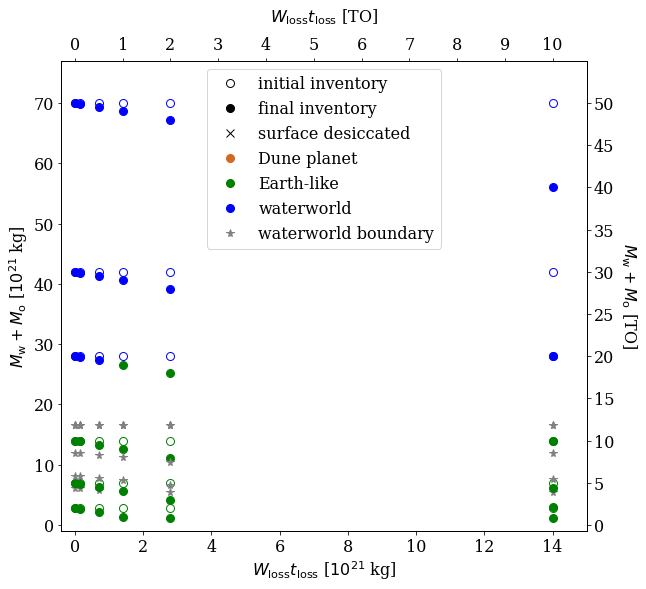

In [30]:
# Plot of total initial water inventory vs. loss rate times loss timescale.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
dr_conv = (L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year #[kg/yr]
t_loss = 1e8 #[yr]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_CA_LR)):

    # Choose corresponding colour for initial values.
    if s_initial_CA_LR[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA_LR[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA_LR[idx]*kg_conv/1000./1.0e18 < 10.0:
        init_color = 'green' #habitable
    elif s_initial_CA_LR[idx]*kg_conv/1000./1.0e18 >= 10.0:
        init_color = 'b' #waterworld
        
    if s_final_CA_LR[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_CA_LR = 'k'
        marker_CA_LR = 'x'
    elif s_final_CA_LR[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_CA_LR[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_CA_LR = 'chocolate' #Dune planet
        marker_CA_LR = 'o'
    elif s_final_CA_LR[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_CA_LR[idx]*kg_conv/1000./1.0e18 < 10.0:
        fin_color_CA_LR = 'green' #habitable
        marker_CA_LR = 'o'
    elif s_final_CA_LR[idx]*kg_conv/1000./1.0e18 >= 10.0:
        fin_color_CA_LR = 'b' #waterworld
        marker_CA_LR = 'o'

    ax1.plot((loss_rates_CA_LR[idx]*dr_conv)*t_loss/1000/1.0e18, (x_initial_CA_LR[idx]+s_initial_CA_LR[idx])*kg_conv/1000/1.0e18, color=init_color, marker='o', linestyle='', fillstyle='none', markersize=8)
    ax1.plot((loss_rates_CA_LR[idx]*dr_conv)*t_loss/1000/1.0e18, (x_final_CA_LR[idx]+s_final_CA_LR[idx])*kg_conv/1000./1.0e18, color=fin_color_CA_LR, marker=marker_CA_LR, linestyle='', markersize=8) 
    
    #Plot waterworld boundary from CA14 as dashed-grey line.
    ax1.plot((loss_rates_CA_LR[idx]*dr_conv)*t_loss/1000/1.0e18, total_ww_bdy[idx]/1000/1.0e18, linestyle='', marker='*', color='grey', markersize=8)
    
    # Plot a dashed grey line, showing the evolution path. MIGHT HAVE TO FIGURE THIS OUT
    #ax1.plot((x_path_CA[idx,:]+s_path_CA[idx,:])*kg_conv/1000./1.0e18, color='grey', linestyle='--')  
    
# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='o', linestyle='', markersize=8, label='initial inventory')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')
ax1.plot(100., 100., color='grey', marker='*', linestyle='', markersize=8, label='waterworld boundary')  

ax1.set_xlabel(r'$W_{\mathrm{loss}} t_{\mathrm{loss}}$ [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.4, 15.)
ax1.set_ylabel(r'$M_{\mathrm{w}} + M_{\mathrm{o}}$ [$10^{21}$ kg]', fontsize=16)
ax1.set_ylim(-1.,77)

ax2.set_xlim(-0.4, 15.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
ax2.set_xlabel(r'$W_{\mathrm{loss}} t_{\mathrm{loss}}$ [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel(r'$M_{\mathrm{w}} + M_{\mathrm{o}}$ [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.legend(loc='upper center', fontsize=16)

#plt.savefig('Grid_TotalWater_LossRates_CA_coloured.pdf', bbox_inches='tight')

### Plots of everything else.

In [171]:
filenums = []

for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                filenums = np.append(filenums, str(jdx)+str(kdx)+str(ldx)+str(mdx))

In [173]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
kg_conv = 2.3e-4*1.3*M_E
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
#x_initial_CA = np.zeros(len(filenums))
#s_initial_CA = np.zeros(len(filenums))
#x_initial_SS = np.zeros(len(filenums))
#s_initial_SS = np.zeros(len(filenums))
x_initial_hyb = np.zeros(len(filenums))
s_initial_hyb = np.zeros(len(filenums))

# Final water content in each reservoir
#x_final_CA = np.zeros(len(filenums))
#s_final_CA = np.zeros(len(filenums))
#x_final_SS = np.zeros(len(filenums))
#s_final_SS = np.zeros(len(filenums))
x_final_hyb = np.zeros(len(filenums))
s_final_hyb = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_hyb_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
#x_path_CA = np.zeros((len(filenums),len(tmp_data)))
#s_path_CA = np.zeros((len(filenums),len(tmp_data)))
#x_path_SS = np.zeros((len(filenums),len(tmp_data)))
#s_path_SS = np.zeros((len(filenums),len(tmp_data)))
x_path_hyb = np.zeros((len(filenums),len(tmp_data)))
s_path_hyb = np.zeros((len(filenums),len(tmp_data)))

#T_path_CA = np.zeros((len(filenums),len(tmp_data)))
#T_path_SS = np.zeros((len(filenums),len(tmp_data)))
T_path_hyb = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
#T_initial_CA = np.zeros(len(filenums))
#T_initial_SS = np.zeros(len(filenums))
T_initial_hyb = np.zeros(len(filenums))
#T_final_CA = np.zeros(len(filenums))
#T_final_SS = np.zeros(len(filenums))
T_final_hyb = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
#x_zero_count_CA = 0.
#s_zero_count_CA = 0.
#both_zero_count_CA = 0.
#x_zero_count_SS = 0.
#s_zero_count_SS = 0.
#both_zero_count_SS = 0.
x_zero_count_hyb = 0.
s_zero_count_hyb = 0.
both_zero_count_hyb = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    #save_file = 'cycling_CA_grid_test' + filenums[idx] + '.txt' #change this to see different results
    #filename = os.path.join(save_path, save_file)
    #tmp_data = np.loadtxt(filename)
    #T_path_CA[idx,:] = tmp_data[:,1]
    #x_path_CA[idx,:] = tmp_data[:,2]
    #s_path_CA[idx,:] = tmp_data[:,3]
    
    #save_file = 'cycling_SS_grid_test' + filenums[idx] + '.txt' #change this to see different results
    #filename = os.path.join(save_path, save_file)
    #tmp_data = np.loadtxt(filename)
    #T_path_SS[idx,:] = tmp_data[:,1]
    #x_path_SS[idx,:] = tmp_data[:,2]
    #s_path_SS[idx,:] = tmp_data[:,3]
    
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_hyb[idx,:] = tmp_data[:,1]
    x_path_hyb[idx,:] = tmp_data[:,2]
    s_path_hyb[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    #x_initial_CA[idx] = x_path_CA[idx,0]
    #s_initial_CA[idx] = s_path_CA[idx,0]
    #x_initial_SS[idx] = x_path_SS[idx,0]
    #s_initial_SS[idx] = s_path_SS[idx,0]
    x_initial_hyb[idx] = x_path_hyb[idx,0]
    s_initial_hyb[idx] = s_path_hyb[idx,0]
    
    #T_initial_CA[idx] = T_path_CA[idx,0]
    #T_initial_SS[idx] = T_path_SS[idx,0]
    T_initial_hyb[idx] = T_path_hyb[idx,0]
    
    #T_final_CA[idx] = T_path_CA[idx,-1]
    #T_final_SS[idx] = T_path_SS[idx,-1]
    T_final_hyb[idx] = T_path_hyb[idx,-1]
    
    # Check for zeros.
    #if x_path_CA[idx,-1] <= tolerance and s_path_CA[idx,-1] <= tolerance:
    #    both_zero_count_CA = both_zero_count_CA + 1.
    #    x_final_CA[idx] = 0.
    #    s_final_CA[idx] = 0.
    #elif x_path_CA[idx,-1] <= tolerance:
    #    x_zero_count_CA = x_zero_count_CA + 1.
    #    x_final_CA[idx] = 0.
    #    s_final_CA[idx] = s_path_CA[idx,-1]
    #elif s_path_CA[idx,-1] <= tolerance:
    #    s_zero_count_CA = s_zero_count_CA + 1.
    #    s_final_CA[idx] = 0.
    #    x_final_CA[idx] = x_path_CA[idx,-1]
    #else: #neither is zero; save normally
    #    x_final_CA[idx] = x_path_CA[idx,-1]
    #    s_final_CA[idx] = s_path_CA[idx,-1]
        
    #if x_path_SS[idx,-1] <= tolerance and s_path_SS[idx,-1] <= tolerance:
    #    both_zero_count_SS = both_zero_count_SS + 1.
    #    x_final_SS[idx] = 0.
    #    s_final_SS[idx] = 0.
    #elif x_path_SS[idx,-1] <= tolerance:
    #    x_zero_count_SS = x_zero_count_SS + 1.
    #    x_final_SS[idx] = 0.
    #    s_final_SS[idx] = s_path_SS[idx,-1]
    #elif s_path_SS[idx,-1] <= tolerance:
    #    s_zero_count_SS = s_zero_count_SS + 1.
    #    s_final_SS[idx] = 0.
    #    x_final_SS[idx] = x_path_SS[idx,-1]
    #else: #neither is zero; save normally
    #    x_final_SS[idx] = x_path_SS[idx,-1]
    #    s_final_SS[idx] = s_path_SS[idx,-1]
        
    if x_path_hyb[idx,-1] <= tolerance and s_path_hyb[idx,-1] <= tolerance:
        both_zero_count_hyb = both_zero_count_hyb + 1.
        x_final_hyb[idx] = 0.
        s_final_hyb[idx] = 0.
    elif x_path_hyb[idx,-1] <= tolerance:
        x_zero_count_hyb = x_zero_count_hyb + 1.
        x_final_hyb[idx] = 0.
        s_final_hyb[idx] = s_path_hyb[idx,-1]
    elif s_path_hyb[idx,-1] <= tolerance:
        s_zero_count_hyb = s_zero_count_hyb + 1.
        s_final_hyb[idx] = 0.
        x_final_hyb[idx] = x_path_hyb[idx,-1]
    else: #neither is zero; save normally
        x_final_hyb[idx] = x_path_hyb[idx,-1]
        s_final_hyb[idx] = s_path_hyb[idx,-1]
        
#print('CA zeros: ', 'x: ', x_zero_count_CA, 's: ', s_zero_count_CA, 'both: ', both_zero_count_CA)
#print('SS zeros: ', 'x: ', x_zero_count_SS, 's: ', s_zero_count_SS, 'both: ', both_zero_count_SS)
print('hyb zeros: ', 'x: ', x_zero_count_hyb, 's: ', s_zero_count_hyb, 'both: ', both_zero_count_hyb)

hyb zeros:  x:  0.0 s:  0.0 both:  0.0


## Read in results from the a) cool mantle, b) hot mantle, c) initial T_ref mantle T-dependent sims, to be plotted for comparison.

In [33]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_coolermantle/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_SS_cool = np.zeros(len(filenums))
s_initial_SS_cool = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_SS_cool = np.zeros(len(filenums))
s_final_SS_cool = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_SS_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_SS_cool = np.zeros((len(filenums),len(tmp_data)))
s_path_SS_cool = np.zeros((len(filenums),len(tmp_data)))

T_path_SS_cool = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_SS_cool = np.zeros(len(filenums))
T_final_SS_cool = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_SS_cool = 0.
s_zero_count_SS_cool = 0.
both_zero_count_SS_cool = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_SS_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_SS_cool[idx,:] = tmp_data[:,1]
    x_path_SS_cool[idx,:] = tmp_data[:,2]
    s_path_SS_cool[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_SS_cool[idx] = x_path_SS_cool[idx,0]
    s_initial_SS_cool[idx] = s_path_SS_cool[idx,0]
    
    T_initial_SS_cool[idx] = T_path_SS_cool[idx,0]
    
    T_final_SS_cool[idx] = T_path_SS_cool[idx,-1]
    
    # Check for zeros.
    if x_path_SS_cool[idx,-1] <= tolerance and s_path_SS_cool[idx,-1] <= tolerance:
        both_zero_count_SS_cool = both_zero_count_SS_cool + 1.
        x_final_SS_cool[idx] = 0.
        s_final_SS_cool[idx] = 0.
    elif x_path_SS_cool[idx,-1] <= tolerance:
        x_zero_count_SS_cool = x_zero_count_SS_cool + 1.
        x_final_SS_cool[idx] = 0.
        s_final_SS_cool[idx] = s_path_SS_cool[idx,-1]
    elif s_path_SS_cool[idx,-1] <= tolerance:
        s_zero_count_SS_cool = s_zero_count_SS_cool + 1.
        s_final_SS_cool[idx] = 0.
        x_final_SS_cool[idx] = x_path_SS_cool[idx,-1]
    else: #neither is zero; save normally
        x_final_SS_cool[idx] = x_path_SS_cool[idx,-1]
        s_final_SS_cool[idx] = s_path_SS_cool[idx,-1]
        
print('SS (cooler mantle) zeros: ', 'x: ', x_zero_count_SS_cool, 's: ', s_zero_count_SS_cool, 'both: ', both_zero_count_SS_cool)

SS (cooler mantle) zeros:  x:  0.0 s:  0.0 both:  0.0


In [34]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_hottermantle/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_SS_hot = np.zeros(len(filenums))
s_initial_SS_hot = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_SS_hot = np.zeros(len(filenums))
s_final_SS_hot = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_SS_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_SS_hot = np.zeros((len(filenums),len(tmp_data)))
s_path_SS_hot = np.zeros((len(filenums),len(tmp_data)))

T_path_SS_hot = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_SS_hot = np.zeros(len(filenums))
T_final_SS_hot = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_SS_hot = 0.
s_zero_count_SS_hot = 0.
both_zero_count_SS_hot = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_SS_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_SS_hot[idx,:] = tmp_data[:,1]
    x_path_SS_hot[idx,:] = tmp_data[:,2]
    s_path_SS_hot[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_SS_hot[idx] = x_path_SS_hot[idx,0]
    s_initial_SS_hot[idx] = s_path_SS_hot[idx,0]
    
    T_initial_SS_hot[idx] = T_path_SS_hot[idx,0]
    
    T_final_SS_hot[idx] = T_path_SS_hot[idx,-1]
    
    # Check for zeros.
    if x_path_SS_hot[idx,-1] <= tolerance and s_path_SS_hot[idx,-1] <= tolerance:
        both_zero_count_SS_hot = both_zero_count_SS_hot + 1.
        x_final_SS_hot[idx] = 0.
        s_final_SS_hot[idx] = 0.
    elif x_path_SS_hot[idx,-1] <= tolerance:
        x_zero_count_SS_hot = x_zero_count_SS_hot + 1.
        x_final_SS_hot[idx] = 0.
        s_final_SS_hot[idx] = s_path_SS_hot[idx,-1]
    elif s_path_SS_hot[idx,-1] <= tolerance:
        s_zero_count_SS_hot = s_zero_count_SS_hot + 1.
        s_final_SS_hot[idx] = 0.
        x_final_SS_hot[idx] = x_path_SS_hot[idx,-1]
    else: #neither is zero; save normally
        x_final_SS_hot[idx] = x_path_SS_hot[idx,-1]
        s_final_SS_hot[idx] = s_path_SS_hot[idx,-1]
        
print('SS (hotter mantle) zeros: ', 'x: ', x_zero_count_SS_hot, 's: ', s_zero_count_SS_hot, 'both: ', both_zero_count_SS_hot)

SS (hotter mantle) zeros:  x:  0.0 s:  0.0 both:  0.0


In [35]:
# Read in data files to figure out final x and s fractions.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_Tref/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_SS_Tref = np.zeros(len(filenums))
s_initial_SS_Tref = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_SS_Tref = np.zeros(len(filenums))
s_final_SS_Tref = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_SS_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_SS_Tref = np.zeros((len(filenums),len(tmp_data)))
s_path_SS_Tref = np.zeros((len(filenums),len(tmp_data)))

T_path_SS_Tref = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_SS_Tref = np.zeros(len(filenums))
T_final_SS_Tref = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_SS_Tref = 0.
s_zero_count_SS_Tref = 0.
both_zero_count_SS_Tref = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_SS_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_SS_Tref[idx,:] = tmp_data[:,1]
    x_path_SS_Tref[idx,:] = tmp_data[:,2]
    s_path_SS_Tref[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_SS_Tref[idx] = x_path_SS_Tref[idx,0]
    s_initial_SS_Tref[idx] = s_path_SS_Tref[idx,0]
    
    T_initial_SS_Tref[idx] = T_path_SS_Tref[idx,0]
    
    T_final_SS_Tref[idx] = T_path_SS_Tref[idx,-1]
    
    # Check for zeros.
    if x_path_SS_Tref[idx,-1] <= tolerance and s_path_SS_Tref[idx,-1] <= tolerance:
        both_zero_count_SS_Tref = both_zero_count_SS_Tref + 1.
        x_final_SS_Tref[idx] = 0.
        s_final_SS_Tref[idx] = 0.
    elif x_path_SS_Tref[idx,-1] <= tolerance:
        x_zero_count_SS_Tref = x_zero_count_SS_Tref + 1.
        x_final_SS_Tref[idx] = 0.
        s_final_SS_Tref[idx] = s_path_SS_Tref[idx,-1]
    elif s_path_SS_Tref[idx,-1] <= tolerance:
        s_zero_count_SS_Tref = s_zero_count_SS_Tref + 1.
        s_final_SS_Tref[idx] = 0.
        x_final_SS_Tref[idx] = x_path_SS_Tref[idx,-1]
    else: #neither is zero; save normally
        x_final_SS_Tref[idx] = x_path_SS_Tref[idx,-1]
        s_final_SS_Tref[idx] = s_path_SS_Tref[idx,-1]
        
print('SS (T_ref) zeros: ', 'x: ', x_zero_count_SS_Tref, 's: ', s_zero_count_SS_Tref, 'both: ', both_zero_count_SS_Tref)

SS (T_ref) zeros:  x:  0.0 s:  0.0 both:  0.0


## Plot viscosity over time for different initial mantle temp T-dependent runs, to see if they converge on a single value.

In [47]:
t_array = np.arange(0,len(tmp_data))

# Calculate viscosities for each run.
eta_array_SS = np.zeros((len(filenums),len(tmp_data)))
eta_array_SS_cool = np.zeros((len(filenums),len(tmp_data)))
eta_array_SS_hot = np.zeros((len(filenums),len(tmp_data)))
eta_array_SS_Tref = np.zeros((len(filenums),len(tmp_data)))
                             
for idx in range(0,len(filenums)):
    
    for jdx in range(0,len(tmp_data)):
        
        eta_array_SS[idx,jdx] = eta(T_path_SS[idx,jdx], x_path_SS[idx,jdx], params1, params2, params3)
        eta_array_SS_cool[idx,jdx] = eta(T_path_SS_cool[idx,jdx], x_path_SS_cool[idx,jdx], params1, params2, params3)
        eta_array_SS_hot[idx,jdx] = eta(T_path_SS_hot[idx,jdx], x_path_SS_hot[idx,jdx], params1, params2, params3)
        eta_array_SS_Tref[idx,jdx] = eta(T_path_SS_Tref[idx,jdx], x_path_SS_Tref[idx,jdx], params1, params2, params3)                        

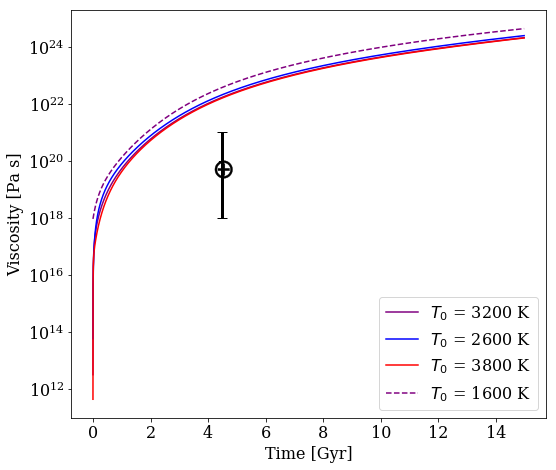

In [48]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

idx = -1 #choose which set of simulations to plot
plt.semilogy(t_array*28700./1e9, eta_array_SS[idx,:], linestyle='-', color='purple', label=r'$T_0$ = 3200 K')
plt.semilogy(t_array*28700./1e9, eta_array_SS_cool[idx,:], linestyle='-', color='blue', label=r'$T_0$ = 2600 K')
plt.semilogy(t_array*28700./1e9, eta_array_SS_hot[idx,:], linestyle='-', color='red', label=r'$T_0$ = 3800 K')
plt.semilogy(t_array*28700./1e9, eta_array_SS_Tref[idx,:], linestyle='--', color='purple', label=r'$T_0$ = 1600 K')

# Viscosity of Earth's mantle today
plt.semilogy(4.5, 5e19, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.4)
asym_yerr = [[4.9e19],[9.5e20]]
plt.errorbar(4.5, 5e19, yerr=asym_yerr, ecolor='k', capsize=5, linewidth=3)

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Viscosity [Pa s]', fontsize=16)
plt.legend(loc='lower right', fontsize=16)
#plt.savefig('Grid_MantleTemp_SS_viscosity.pdf', bbox_inches='tight')

## Plot mantle temp, mantle water, viscosity one plot (3 vertical panels) for no loss, maximum tested initial water (50 TO surface, 12 TO mantle).

In [254]:
# Read in files into an array, to be plotted.

save_path_1 = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_2Tref_noloss/'
save_path_2 = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_coolermantle_noloss/'
save_path_3 = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_hottermantle_noloss/'
save_path_4 = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_Tref_noloss/'

tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Need length of data for the following arrays.
save_file = 'cycling_SS_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path_1, save_file)
tmp_data = np.loadtxt(filename)

# Time array -- all share the same time array, so only need one.
t_path_SS_tmps = np.zeros(len(tmp_data))

# Overall evolution path for each simulation -- mantle water, temperature, viscosity.
x_path_SS_temps = np.zeros((4,len(tmp_data)))
T_path_SS_temps = np.zeros((4,len(tmp_data)))
eta_path_SS_temps = np.zeros((4,len(tmp_data)))

# All 4 files for this run.
filename_1 = os.path.join(save_path_1, save_file)
filename_2 = os.path.join(save_path_2, save_file)
filename_3 = os.path.join(save_path_3, save_file)
filename_4 = os.path.join(save_path_4, save_file)

# Read data into arrays, and calculate viscosity.
# Normal (2*Tref)
tmp_data = np.loadtxt(filename_1)
t_path_SS_temps = tmp_data[:,0]
T_path_SS_temps[0,:] = tmp_data[:,1]
x_path_SS_temps[0,:] = tmp_data[:,2]

# Cooler (2600 K)
tmp_data = np.loadtxt(filename_2)
T_path_SS_temps[1,:] = tmp_data[:,1]
x_path_SS_temps[1,:] = tmp_data[:,2]

# Hotter (3800 K)
tmp_data = np.loadtxt(filename_3)
T_path_SS_temps[2,:] = tmp_data[:,1]
x_path_SS_temps[2,:] = tmp_data[:,2]

# Tref (1600 K)
tmp_data = np.loadtxt(filename_4)
T_path_SS_temps[3,:] = tmp_data[:,1]
x_path_SS_temps[3,:] = tmp_data[:,2]
    
for idx in range(0,4):
    
    for jdx in range(0,len(tmp_data)):
        
        eta_path_SS_temps[idx,jdx] = eta(T_path_SS_temps[idx,jdx], x_path_SS_temps[idx,jdx], params1, params2, params3)

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


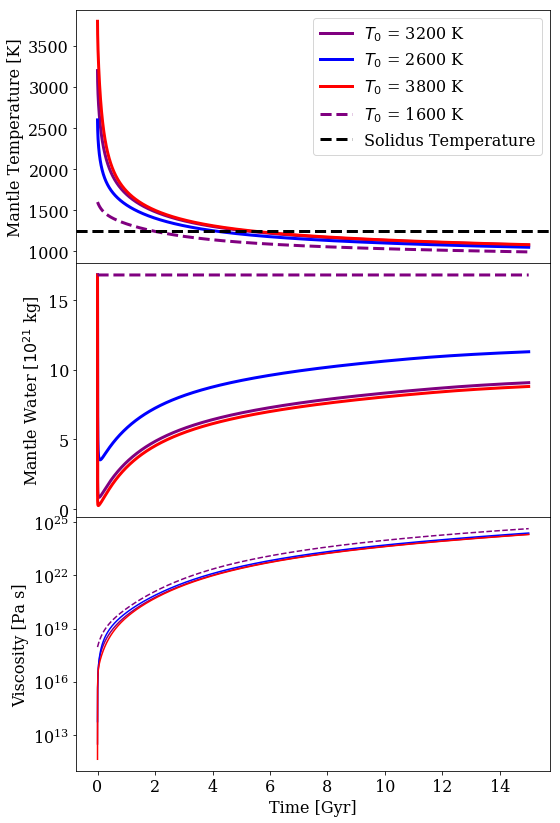

In [263]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,14))
plt.tight_layout()
ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

colors_array = ['purple', 'blue', 'red', 'purple']
lines_array = ['-', '-', '-', '--']
labels_array = [r'$T_0$ = 3200 K', r'$T_0$ = 2600 K', r'$T_0$ = 3800 K', r'$T_0$ = 1600 K']

ax1 = plt.subplot(3,1,1)
# Mantle temperature
for idx in range(0,4):
    plt.plot(t_path_SS_temps/tau(M_E,params1,params2,params3)/year/1.0e9, (T_path_SS_temps[idx,:]*T_ref), linewidth=3, color=colors_array[idx], linestyle=lines_array[idx], label=labels_array[idx])
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
plt.legend(loc='upper right', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
    
ax2 = plt.subplot(3,1,2)
for idx in range(0,4):
    plt.plot(t_path_SS_temps/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_SS_temps[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color=colors_array[idx], linestyle=lines_array[idx])#, label='3200 K')
plt.ylabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
    
ax3 = plt.subplot(3,1,3)
for idx in range(0,4):
    plt.semilogy(t_path_SS_temps/tau(M_E,params1,params2,params3)/year/1.0e9, eta_path_SS_temps[idx,:], color=colors_array[idx], linestyle=lines_array[idx])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Viscosity [Pa s]', fontsize=16)
#plt.ylim([1e11,1.5e25])

#plt.savefig('SS_MantleTemp_Water_Viscosity_linearx.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


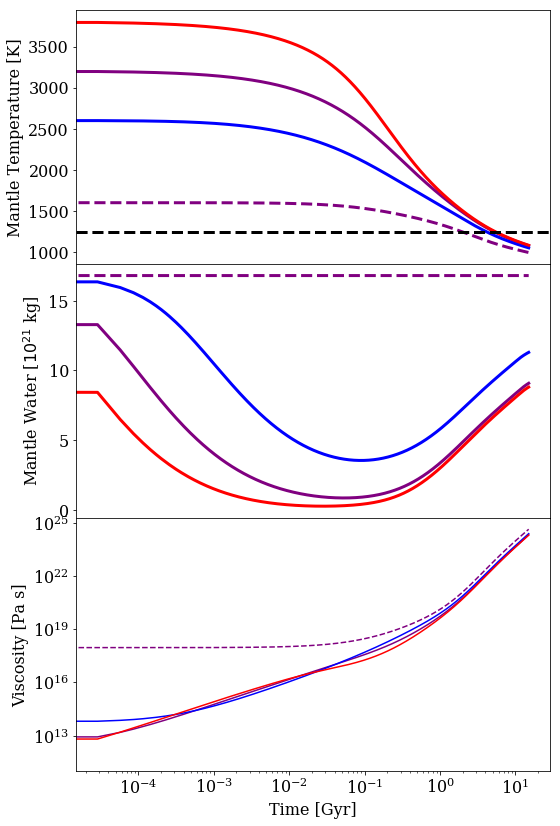

In [262]:
# Same as above, but x-axis on a log scale.
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,14))
plt.tight_layout()
ax = [fig.add_subplot(3,1,i+1) for i in range(3)]
fig.subplots_adjust(hspace=0)

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

colors_array = ['purple', 'blue', 'red', 'purple']
lines_array = ['-', '-', '-', '--']
labels_array = [r'$T_0$ = 3200 K', r'$T_0$ = 2600 K', r'$T_0$ = 3800 K', r'$T_0$ = 1600 K']

ax1 = plt.subplot(3,1,1)
# Mantle temperature
for idx in range(0,4):
    plt.semilogx(t_path_SS_temps/tau(M_E,params1,params2,params3)/year/1.0e9, (T_path_SS_temps[idx,:]*T_ref), linewidth=3, color=colors_array[idx], linestyle=lines_array[idx], label=labels_array[idx])
plt.axhline(y=T_sol_dry, color='k', linestyle='--', linewidth=3, label='Solidus Temperature')
#plt.legend(loc='upper right', fontsize=16)
plt.ylabel('Mantle Temperature [K]', fontsize=16)
    
ax2 = plt.subplot(3,1,2)
for idx in range(0,4):
    plt.semilogx(t_path_SS_temps/tau(M_E,params1,params2,params3)/year/1.0e9, (x_path_SS_temps[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color=colors_array[idx], linestyle=lines_array[idx])#, label='3200 K')
plt.ylabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
    
ax3 = plt.subplot(3,1,3)
for idx in range(0,4):
    plt.loglog(t_path_SS_temps/tau(M_E,params1,params2,params3)/year/1.0e9, eta_path_SS_temps[idx,:], color=colors_array[idx], linestyle=lines_array[idx])
plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel('Viscosity [Pa s]', fontsize=16)
#plt.ylim([1e11,1.5e25])

#plt.savefig('SS_MantleTemp_Water_Viscosity_logx.pdf', bbox_inches='tight')

Text(0, 0.5, 'Water Mass [$10^{21}$ kg]')

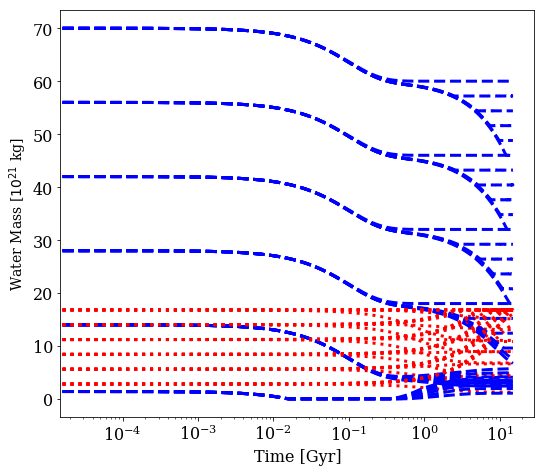

In [108]:
# Try to plot hatched regions of all simulations.
# Just plot all simulations first?

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

for idx in range(0,len(filenums)):
    
    # XXXX THESE TIME ARRAYS ARE WRONG(ISH). NEED TO ACTUALLY USE TAU IF INCLUDING IN PAPER. XXXX
    plt.semilogx(t_array*28700./1e9, (x_path_CA[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':')#, label='Mantle')
    plt.semilogx(t_array*28700./1e9, (s_path_CA[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--')#, label='Surface')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=14)

Text(0, 0.5, 'Water Mass [$10^{21}$ kg]')

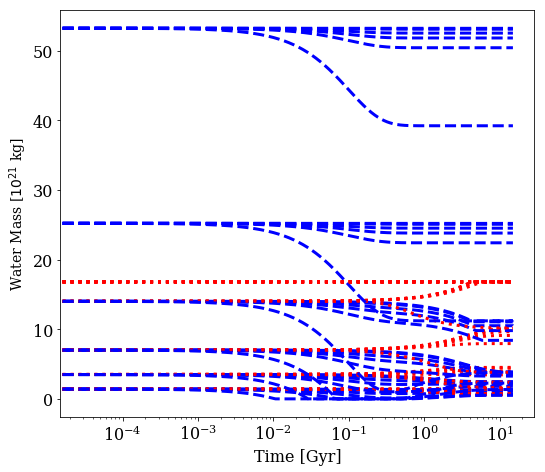

In [109]:
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

for idx in range(0,len(filenums)):
    
    # XXXX THESE TIME ARRAYS ARE WRONG(ISH). NEED TO ACTUALLY USE TAU IF INCLUDING IN PAPER. XXXX
    plt.semilogx(t_array*28700./1e9, (x_path_CA_LR[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':')#, label='Mantle')
    plt.semilogx(t_array*28700./1e9, (s_path_CA_LR[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--')#, label='Surface')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=14)

In [103]:
print(len(filenums))

36


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


(0.5177457188199589, 522000)

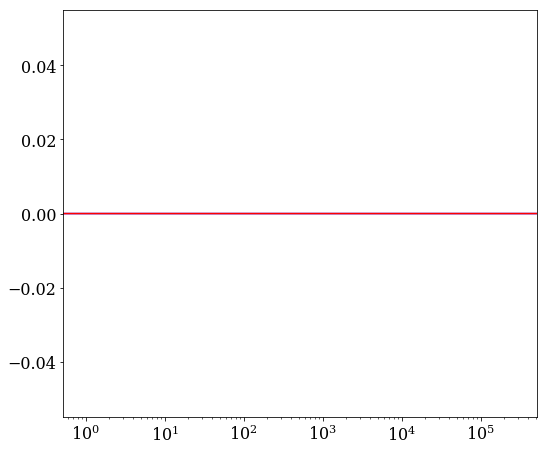

In [59]:
t_array = np.arange(0,len(tmp_data))

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()
plt.semilogx(t_array, s_path_CA[34,:], 'b')
plt.semilogx(t_array, x_path_CA[34,:], 'r')
plt.xlim([0,len(tmp_data)])

## Read in results for different hybrid runs.

In [31]:
# Hybrid, loss rate 0.01*default

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_0d01_default/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb_0d01 = np.zeros(len(filenums))
s_initial_hyb_0d01 = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_hyb_0d01 = np.zeros(len(filenums))
s_final_hyb_0d01 = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_hyb_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb_0d01 = np.zeros((len(filenums),len(tmp_data)))
s_path_hyb_0d01 = np.zeros((len(filenums),len(tmp_data)))

T_path_hyb_0d01 = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_hyb_0d01 = np.zeros(len(filenums))
T_final_hyb_0d01 = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb_0d01 = 0.
s_zero_count_hyb_0d01 = 0.
both_zero_count_hyb_0d01 = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_hyb_0d01[idx,:] = tmp_data[:,1]
    x_path_hyb_0d01[idx,:] = tmp_data[:,2]
    s_path_hyb_0d01[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_hyb_0d01[idx] = x_path_hyb_0d01[idx,0]
    s_initial_hyb_0d01[idx] = s_path_hyb_0d01[idx,0]
    
    T_initial_hyb_0d01[idx] = T_path_hyb_0d01[idx,0]
    
    T_final_hyb_0d01[idx] = T_path_hyb_0d01[idx,-1]
    
    # Check for zeros.
    if x_path_hyb_0d01[idx,-1] <= tolerance and s_path_hyb_0d01[idx,-1] <= tolerance:
        both_zero_count_hyb_0d01 = both_zero_count_hyb_0d01 + 1.
        x_final_hyb_0d01[idx] = 0.
        s_final_hyb_0d01[idx] = 0.
    elif x_path_hyb_0d01[idx,-1] <= tolerance:
        x_zero_count_hyb_0d01 = x_zero_count_hyb_0d01 + 1.
        x_final_hyb_0d01[idx] = 0.
        s_final_hyb_0d01[idx] = s_path_hyb_0d01[idx,-1]
    elif s_path_hyb_0d01[idx,-1] <= tolerance:
        s_zero_count_hyb_0d01 = s_zero_count_hyb_0d01 + 1.
        s_final_hyb_0d01[idx] = 0.
        x_final_hyb_0d01[idx] = x_path_hyb_0d01[idx,-1]
    else: #neither is zero; save normally
        x_final_hyb_0d01[idx] = x_path_hyb_0d01[idx,-1]
        s_final_hyb_0d01[idx] = s_path_hyb_0d01[idx,-1]
        
print('Hybrid (0.01*default loss rate) zeros: ', 'x: ', x_zero_count_hyb_0d01, 's: ', s_zero_count_hyb_0d01, 'both: ', both_zero_count_hyb_0d01)

Hybrid (0.01*default loss rate) zeros:  x:  0.0 s:  0.0 both:  0.0


In [32]:
# Hybrid, loss rate 0.1*default

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_0d1_default/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb_0d1 = np.zeros(len(filenums))
s_initial_hyb_0d1 = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_hyb_0d1 = np.zeros(len(filenums))
s_final_hyb_0d1 = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_hyb_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb_0d1 = np.zeros((len(filenums),len(tmp_data)))
s_path_hyb_0d1 = np.zeros((len(filenums),len(tmp_data)))

T_path_hyb_0d1 = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_hyb_0d1 = np.zeros(len(filenums))
T_final_hyb_0d1 = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb_0d1 = 0.
s_zero_count_hyb_0d1 = 0.
both_zero_count_hyb_0d1 = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_hyb_0d1[idx,:] = tmp_data[:,1]
    x_path_hyb_0d1[idx,:] = tmp_data[:,2]
    s_path_hyb_0d1[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_hyb_0d1[idx] = x_path_hyb_0d1[idx,0]
    s_initial_hyb_0d1[idx] = s_path_hyb_0d1[idx,0]
    
    T_initial_hyb_0d1[idx] = T_path_hyb_0d1[idx,0]
    
    T_final_hyb_0d1[idx] = T_path_hyb_0d1[idx,-1]
    
    # Check for zeros.
    if x_path_hyb_0d1[idx,-1] <= tolerance and s_path_hyb_0d1[idx,-1] <= tolerance:
        both_zero_count_hyb_0d1 = both_zero_count_hyb_0d1 + 1.
        x_final_hyb_0d1[idx] = 0.
        s_final_hyb_0d1[idx] = 0.
    elif x_path_hyb_0d1[idx,-1] <= tolerance:
        x_zero_count_hyb_0d1 = x_zero_count_hyb_0d1 + 1.
        x_final_hyb_0d1[idx] = 0.
        s_final_hyb_0d1[idx] = s_path_hyb_0d1[idx,-1]
    elif s_path_hyb_0d1[idx,-1] <= tolerance:
        s_zero_count_hyb_0d1 = s_zero_count_hyb_0d1 + 1.
        s_final_hyb_0d1[idx] = 0.
        x_final_hyb_0d1[idx] = x_path_hyb_0d1[idx,-1]
    else: #neither is zero; save normally
        x_final_hyb_0d1[idx] = x_path_hyb_0d1[idx,-1]
        s_final_hyb_0d1[idx] = s_path_hyb_0d1[idx,-1]
        
print('Hybrid (0.1*default loss rate) zeros: ', 'x: ', x_zero_count_hyb_0d1, 's: ', s_zero_count_hyb_0d1, 'both: ', both_zero_count_hyb_0d1)

Hybrid (0.1*default loss rate) zeros:  x:  0.0 s:  0.0 both:  0.0


In [39]:
# Hybrid, loss rate 10*default

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_10_default/'
#save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_noloss/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb_10 = np.zeros(len(filenums))
s_initial_hyb_10 = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_hyb_10 = np.zeros(len(filenums))
s_final_hyb_10 = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_hyb_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb_10 = np.zeros((len(filenums),len(tmp_data)))
s_path_hyb_10 = np.zeros((len(filenums),len(tmp_data)))

T_path_hyb_10 = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_hyb_10 = np.zeros(len(filenums))
T_final_hyb_10 = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb_10 = 0.
s_zero_count_hyb_10 = 0.
both_zero_count_hyb_10 = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_hyb_10[idx,:] = tmp_data[:,1]
    x_path_hyb_10[idx,:] = tmp_data[:,2]
    s_path_hyb_10[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_hyb_10[idx] = x_path_hyb_10[idx,0]
    s_initial_hyb_10[idx] = s_path_hyb_10[idx,0]
    
    T_initial_hyb_10[idx] = T_path_hyb_10[idx,0]
    
    T_final_hyb_10[idx] = T_path_hyb_10[idx,-1]
    
    # Check for zeros.
    if x_path_hyb_10[idx,-1] <= tolerance and s_path_hyb_10[idx,-1] <= tolerance:
        both_zero_count_hyb_10 = both_zero_count_hyb_10 + 1.
        x_final_hyb_10[idx] = 0.
        s_final_hyb_10[idx] = 0.
    elif x_path_hyb_10[idx,-1] <= tolerance:
        x_zero_count_hyb_10 = x_zero_count_hyb_10 + 1.
        x_final_hyb_10[idx] = 0.
        s_final_hyb_10[idx] = s_path_hyb_10[idx,-1]
    elif s_path_hyb_10[idx,-1] <= tolerance:
        s_zero_count_hyb_10 = s_zero_count_hyb_10 + 1.
        s_final_hyb_10[idx] = 0.
        x_final_hyb_10[idx] = x_path_hyb_10[idx,-1]
    else: #neither is zero; save normally
        x_final_hyb_10[idx] = x_path_hyb_10[idx,-1]
        s_final_hyb_10[idx] = s_path_hyb_10[idx,-1]
        
print('Hybrid (10*default loss rate) zeros: ', 'x: ', x_zero_count_hyb_10, 's: ', s_zero_count_hyb_10, 'both: ', both_zero_count_hyb_10)

Hybrid (10*default loss rate) zeros:  x:  0.0 s:  0.0 both:  0.0


## Read in results for full grid search of the hybrid model.

In [151]:
filenums = [] #filenumbers, for reading in files
W_loss_array_hyb = [] #array of W_loss, to be plotted
t_loss_array_hyb = [] #array of t_loss, to be plotted

for jdx in range(0, len(initial_s_array)):
    
    for kdx in range(0, len(initial_x_array)):
        
        for ldx in range(0, len(loss_factor_array)):
            
            for mdx in range(0, len(loss_time_array)):
                
                filenums = np.append(filenums, str(jdx)+str(kdx)+str(ldx)+str(mdx))
                
                W_loss_array_hyb = np.append(W_loss_array_hyb, loss_factor_array[ldx])
                t_loss_array_hyb = np.append(t_loss_array_hyb, loss_time_array[mdx])

In [52]:
# Hybrid, loss rate 10*default

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_fullgrid/'
tolerance = 1.29e16/kg_conv #anything below this, no water (<~0.00001 TO)

# Initial water content in each reservoir
x_initial_hyb_full = np.zeros(len(filenums))
s_initial_hyb_full = np.zeros(len(filenums))

# Final water content in each reservoir
x_final_hyb_full = np.zeros(len(filenums))
s_final_hyb_full = np.zeros(len(filenums))

# Loss rates
W_loss_hyb_full = np.zeros(len(filenums))
t_loss_hyb_full = np.zeros(len(filenums))

# Need length of data for the following arrays.
save_file = 'cycling_hyb_grid_test' + '0000' + '.txt' #just need length so file number doesn't matter here
filename = os.path.join(save_path, save_file)
tmp_data = np.loadtxt(filename)

# Time array, based on the length of the data files.
t_array = np.arange(0,len(tmp_data))

# Overall evolution path for each reservoir & mantle temperature.
x_path_hyb_full = np.zeros((len(filenums),len(tmp_data)))
s_path_hyb_full = np.zeros((len(filenums),len(tmp_data)))

T_path_hyb_full = np.zeros((len(filenums),len(tmp_data)))

# Initial and final mantle temperatures (needed for stagnant lid check)
T_initial_hyb_full = np.zeros(len(filenums))
T_final_hyb_full = np.zeros(len(filenums))

# How many reach exactly zero in one/both reservoir/s at the end?
x_zero_count_hyb_full = 0.
s_zero_count_hyb_full = 0.
both_zero_count_hyb_full = 0.

for idx in range(0,len(filenums)):
    # Read in data files for each model, and save them as the evolutionary path.
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    T_path_hyb_full[idx,:] = tmp_data[:,1]
    x_path_hyb_full[idx,:] = tmp_data[:,2]
    s_path_hyb_full[idx,:] = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    x_initial_hyb_full[idx] = x_path_hyb_full[idx,0]
    s_initial_hyb_full[idx] = s_path_hyb_full[idx,0]
    
    T_initial_hyb_full[idx] = T_path_hyb_full[idx,0]
    
    T_final_hyb_full[idx] = T_path_hyb_full[idx,-1]
    
    # Check for zeros.
    if x_path_hyb_full[idx,-1] <= tolerance and s_path_hyb_full[idx,-1] <= tolerance:
        both_zero_count_hyb_full = both_zero_count_hyb_full + 1.
        x_final_hyb_full[idx] = 0.
        s_final_hyb_full[idx] = 0.
    elif x_path_hyb_full[idx,-1] <= tolerance:
        x_zero_count_hyb_full = x_zero_count_hyb_full + 1.
        x_final_hyb_full[idx] = 0.
        s_final_hyb_full[idx] = s_path_hyb_full[idx,-1]
    elif s_path_hyb_full[idx,-1] <= tolerance:
        s_zero_count_hyb_full = s_zero_count_hyb_full + 1.
        s_final_hyb_full[idx] = 0.
        x_final_hyb_full[idx] = x_path_hyb_full[idx,-1]
    else: #neither is zero; save normally
        x_final_hyb_full[idx] = x_path_hyb_full[idx,-1]
        s_final_hyb_full[idx] = s_path_hyb_full[idx,-1]
        
print('Hybrid (full grid) zeros: ', 'x: ', x_zero_count_hyb_full, 's: ', s_zero_count_hyb_full, 'both: ', both_zero_count_hyb_full)

Hybrid (full grid) zeros:  x:  0.0 s:  23.0 both:  0.0


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=10000000.0, right=10000000.0
  self.set_xlim(upper, lower, auto=None)


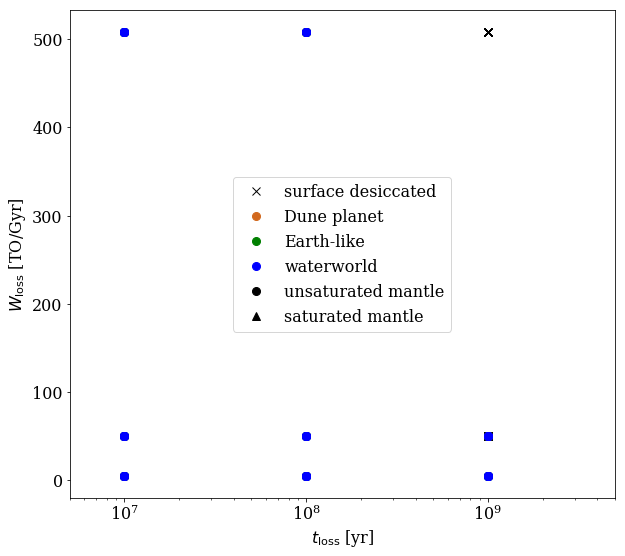

In [95]:
# Plot of W_loss vs. t_loss.
# Points coloured based on surface water.
# Symbol indicates saturated mantle.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
TO_Gyr_conv = 1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year) #W_loss in [TO/Gyr]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_final_hyb_full)):
        
    # Choose corresponding colour for final values, based on surface water content.
    if s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_full = 'k'
        marker_hyb_full = 'x'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_full = 'chocolate' #Dune planet
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = '^' #saturated mantle 
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_full = 'green' #habitable
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = '^' #saturated mantle
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_full = 'b' #waterworld    
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = '^' #saturated mantle
    
    ax1.semilogx(t_loss_array_hyb[idx], W_loss_array_hyb[idx]*TO_Gyr_conv, color=fin_color_hyb_full, marker=marker_hyb_full, linestyle='', markersize=8) 
    
# Handles for legend only
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='unsaturated mantle')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='saturated mantle')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
#ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'$t_{\mathrm{loss}}$ [yr]', fontsize=16)
ax1.set_ylabel(r'$W_{\mathrm{loss}}$ [TO/Gyr]', fontsize=16)
ax1.set_xlim(5.0e6, 5.0e9)
#ax1.set_ylim(-1., 77.)

#plt.grid(which='both')
ax1.legend(loc='center', fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured_noloss.pdf', bbox_inches='tight')

In [93]:
print((x_final_hyb_full[0]*kg_conv/1000./1.0e18)<(12*1.4))

True


Text(0.7, 53, 'loss')

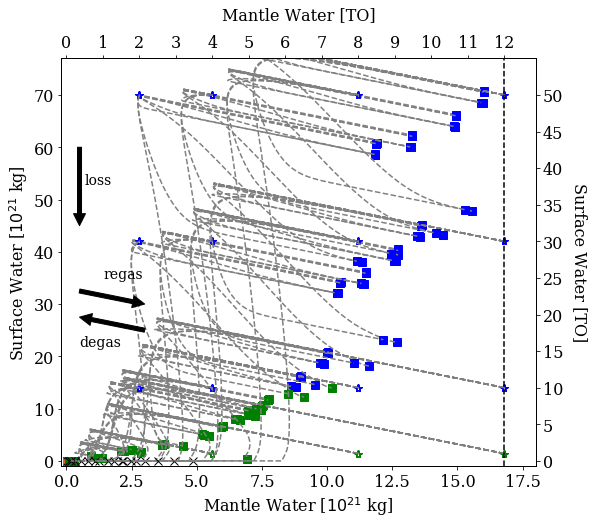

In [68]:
# What do the paths of the above plot look like, and the spacing of the points in surface vs. mantle space?

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_full)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color_hyb_full = 'chocolate' #Dune planet
    elif s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color_hyb_full = 'green' #habitable
    elif s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color_hyb_full = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_full = 'k'
        marker_hyb_full = 'x'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_full = 'chocolate' #Dune planet
        marker_hyb_full = 's'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_full = 'green' #habitable
        marker_hyb_full = 's'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_full = 'b' #waterworld
        marker_hyb_full = 's'
    
    ax1.plot(x_initial_hyb_full[idx]*kg_conv/1000./1.0e18, s_initial_hyb_full[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color_hyb_full, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb_full[idx]*kg_conv/1000./1.0e18, s_final_hyb_full[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_full, marker=marker_hyb_full, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_hyb_full[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_full[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

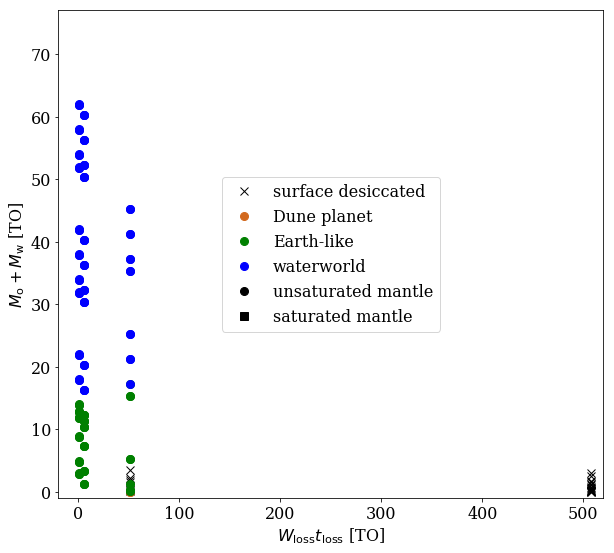

In [98]:
# The above plots are pretty rough... let's try total water vs. W_loss*t_loss.
# Colour based on final surface water.
# Symbol based on whether mantle is saturated or not.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
TO_Gyr_conv = 1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year) #W_loss in [TO/Gyr]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_final_hyb_full)):
        
    # Choose corresponding colour for final values, based on surface water content.
    if s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_full = 'k'
        marker_hyb_full = 'x'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_full = 'chocolate' #Dune planet
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = '^' #saturated mantle
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_full = 'green' #habitable
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = '^' #saturated mantle
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_full = 'b' #waterworld
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = '^' #saturated mantle

    ax1.plot((W_loss_array_hyb[idx]*TO_Gyr_conv)*(t_loss_array_hyb[idx]/1.0e9), (x_final_hyb_full[idx]+s_final_hyb_full[idx])*kg_conv/1000./1.0e18/1.4, color=fin_color_hyb_full, marker=marker_hyb_full, linestyle='', markersize=8) 
    
# Handles for legend only
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='unsaturated mantle')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='saturated mantle')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
#ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'$W_{\mathrm{loss}} t_{\mathrm{loss}}$ [TO]', fontsize=16)
ax1.set_ylabel(r'$M_{\mathrm{o}}+M_{\mathrm{w}}$ [TO]', fontsize=16)
ax1.set_xlim(-20, 520)
ax1.set_ylim(-1., 77.)

#plt.grid(which='both')
ax1.legend(loc='center', fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured_noloss.pdf', bbox_inches='tight')

In [ ]:
print((W_loss_array_hyb*TO_Gyr_conv)*(t_loss_array_hyb/1.0e9))

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.


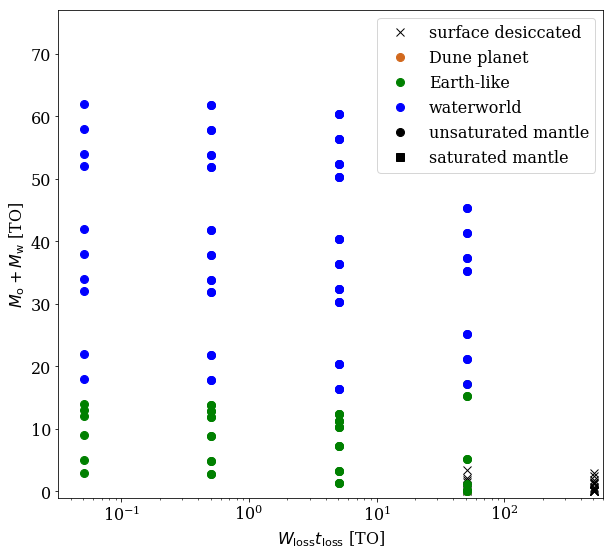

In [164]:
# Same as above, but x-axis on a log scale.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
TO_Gyr_conv = 1.4e21/1e9/((L_MOR(M_E)*(0.1/year)*x_h*rho_c*chi*d_hE)*year) #W_loss in [TO/Gyr]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_final_hyb_full)):
        
    # Choose corresponding colour for final values, based on surface water content.
    if s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_full = 'k'
        marker_hyb_full = 'x'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_full = 'chocolate' #Dune planet
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = 's' #saturated mantle
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_full = 'green' #habitable
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = 's' #saturated mantle
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_full = 'b' #waterworld
        #Saturated mantle check
        if x_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 12.0*1.4:
            marker_hyb_full = 'o'
        elif x_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 12.0*1.4:
            marker_hyb_full = 's' #saturated mantle

    ax1.semilogx((W_loss_array_hyb[idx]*TO_Gyr_conv)*(t_loss_array_hyb[idx]/1.0e9), (x_final_hyb_full[idx]+s_final_hyb_full[idx])*kg_conv/1000./1.0e18/1.4, color=fin_color_hyb_full, marker=marker_hyb_full, linestyle='', markersize=8) 
    
# Handles for legend only
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='unsaturated mantle')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='saturated mantle')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
#ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'$W_{\mathrm{loss}} t_{\mathrm{loss}}$ [TO]', fontsize=16)
ax1.set_ylabel(r'$M_{\mathrm{o}}+M_{\mathrm{w}}$ [TO]', fontsize=16)
ax1.set_xlim(-20, 600)
ax1.set_ylim(-1., 77.)

#plt.grid(which='both')
ax1.legend(loc='upper right', fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Full_Parameter_Search_hyb_totalwater_loss.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured_noloss.pdf', bbox_inches='tight')

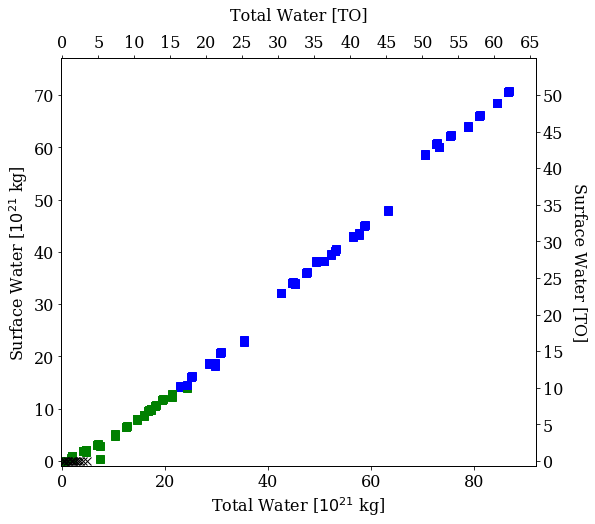

In [163]:
# Plot of surface water vs. total water -- see if it helps support conclusions

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_full)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color_hyb_full = 'chocolate' #Dune planet
    elif s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color_hyb_full = 'green' #habitable
    elif s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color_hyb_full = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_full = 'k'
        marker_hyb_full = 'x'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_full = 'chocolate' #Dune planet
        marker_hyb_full = 's'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_full = 'green' #habitable
        marker_hyb_full = 's'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_full = 'b' #waterworld
        marker_hyb_full = 's'
    
    #ax1.plot(x_initial_hyb_full[idx]*kg_conv/1000./1.0e18, s_initial_hyb_full[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color_hyb_full, marker='*', linestyle='', markersize=8)
    ax1.plot((x_final_hyb_full[idx]+s_final_hyb_full[idx])*kg_conv/1000./1.0e18, s_final_hyb_full[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_full, marker=marker_hyb_full, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_hyb_full[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_full[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
#ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Total Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 92.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 92.)
ax2.set_xticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0, 84.0, 91.0])
ax2.set_xticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65'])
ax2.set_xlabel('Total Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Full_Parameter_Search_hyb_totalwater_surfacewater.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
/Users/admin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


(0.00137888541216316, 77.0)

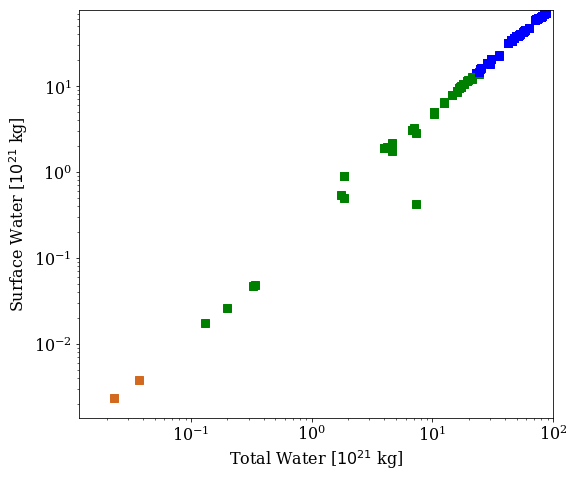

In [116]:
# Same as above, but don't double the axes so I can zoom on specific regions
# NOTE: If log-log, desiccated surfaces (0) aren't shown.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_full)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color_hyb_full = 'chocolate' #Dune planet
    elif s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color_hyb_full = 'green' #habitable
    elif s_initial_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color_hyb_full = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_full = 'k'
        marker_hyb_full = 'x'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_full = 'chocolate' #Dune planet
        marker_hyb_full = 's'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_full[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_full = 'green' #habitable
        marker_hyb_full = 's'
    elif s_final_hyb_full[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_full = 'b' #waterworld
        marker_hyb_full = 's'
    
    #ax1.plot(x_initial_hyb_full[idx]*kg_conv/1000./1.0e18, s_initial_hyb_full[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color_hyb_full, marker='*', linestyle='', markersize=8)
    ax1.loglog((x_final_hyb_full[idx]+s_final_hyb_full[idx])*kg_conv/1000./1.0e18, s_final_hyb_full[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_full, marker=marker_hyb_full, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_hyb_full[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_full[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
#ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Total Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 100.)
ax1.set_ylim(-1., 77.)

#ax2.set_xlim(-0.2, 92.)
#ax2.set_xticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0, 84.0, 91.0])
#ax2.set_xticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55', '60', '65'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 77.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

## All other plots

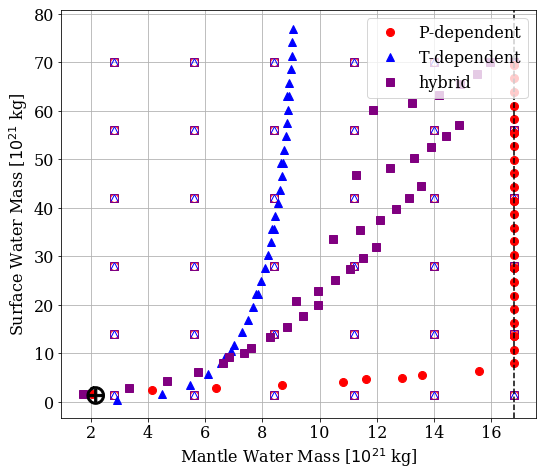

In [23]:
# Plot s vs x (in kg), on a log scale.
# Use different symbols for different models.

# Also plot initial conditions as open symbols, and connect to the final corresponding s/x.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]

plt.plot(x_initial_CA*kg_conv/1000./1.0e18, s_initial_CA*kg_conv/1000./1.0e18,  fillstyle='none', color='r', marker='o', linestyle='', markersize=8)
plt.plot(x_initial_SS*kg_conv/1000./1.0e18, s_initial_SS*kg_conv/1000./1.0e18,  fillstyle='none', color='b', marker='^', linestyle='', markersize=8)
plt.plot(x_initial_hyb*kg_conv/1000./1.0e18, s_initial_hyb*kg_conv/1000./1.0e18,  fillstyle='none', color='purple', marker='s', linestyle='', markersize=8)
plt.plot(x_final_CA*kg_conv/1000./1.0e18, s_final_CA*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8, label='P-dependent')
plt.plot(x_final_SS*kg_conv/1000./1.0e18, s_final_SS*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8, label='T-dependent')
plt.plot(x_final_hyb*kg_conv/1000./1.0e18, s_final_hyb*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8, label='hybrid')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20)
#plt.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
plt.legend(loc='upper right', fontsize=16)
#plt.savefig('Final_Water_parametertest_norestrictions.pdf')
#plt.savefig('Final_Water_parametertest.pdf')

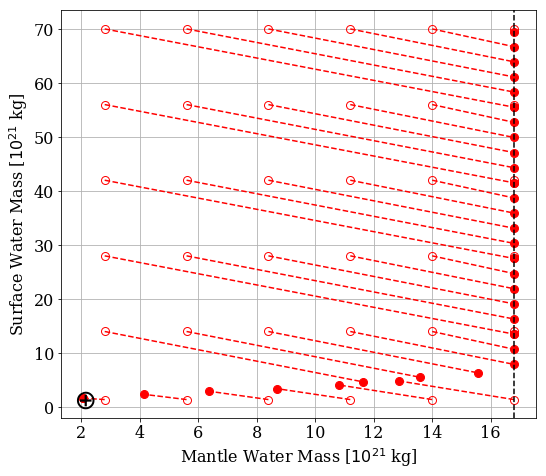

In [24]:
# Plot open marker, then filled marker, then a line connecting the two.

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_CA)):
    plt.plot(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='r', marker='o', linestyle='', markersize=8)
    plt.plot(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)
    plt.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='r', linestyle='--')
plt.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
#plt.axhline(y=50*1.4, color='k', linestyle='--')#, label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
#plt.legend(loc='upper right', fontsize=16) 
#plt.savefig('Parameter_Search_CA_Model.pdf')


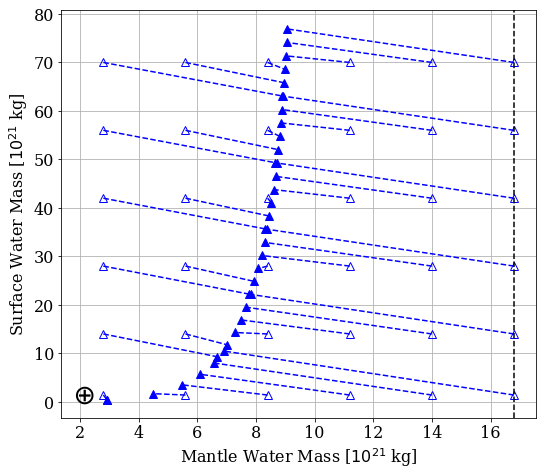

In [25]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_SS)):
    plt.plot(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='b', marker='^', linestyle='', markersize=8)
    plt.plot(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8)
    plt.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='b', linestyle='--')
plt.plot(x_final_SS[0]*kg_conv/1000./1.0e18, s_final_SS[0]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8)#, label='P-dependent')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
#plt.axhline(y=50*1.4, color='k', linestyle='--')#, label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
#plt.legend(loc='upper right', fontsize=16) 
#plt.savefig('Parameter_Search_SS_Model.pdf')

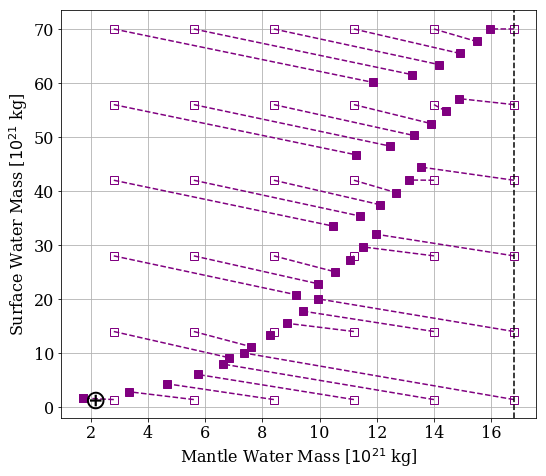

In [26]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_hyb)):
    plt.plot(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='purple', marker='s', linestyle='', markersize=8)
    plt.plot(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8)
    plt.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='purple', linestyle='--')
plt.plot(x_final_hyb[0]*kg_conv/1000./1.0e18, s_final_hyb[0]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8)#, label='P-dependent')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
#plt.axhline(y=50*1.4, color='k', linestyle='--')#, label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
#plt.legend(loc='upper right', fontsize=16) 
#plt.savefig('Parameter_Search_hyb_Model.pdf')

In [ ]:
%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
for idx in range(0,len(x_initial_hyb)):
    plt.plot(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='r', marker='o', linestyle='', markersize=8)
    plt.plot(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)
    plt.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='r', linestyle='--')
    plt.plot(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='b', marker='^', linestyle='', markersize=8)
    plt.plot(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8)
    plt.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='b', linestyle='--')
    plt.plot(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color='purple', marker='s', linestyle='', markersize=8)
    plt.plot(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8)
    plt.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='purple', linestyle='--')
plt.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8, label='P-dependent')
plt.plot(x_final_SS[0]*kg_conv/1000./1.0e18, s_final_SS[0]*kg_conv/1000./1.0e18, color='b', marker='^', linestyle='', markersize=8, label='T-dependent')
plt.plot(x_final_hyb[0]*kg_conv/1000./1.0e18, s_final_hyb[0]*kg_conv/1000./1.0e18, color='purple', marker='s', linestyle='', markersize=8, label='hybrid')
plt.plot(1.5*1.4, 1.4, color='k', marker='$\oplus$', markersize=20, markeredgewidth=0.01)
#plt.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
plt.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')
plt.xlabel(r'Mantle Water Mass [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'Surface Water Mass [$10^{21}$ kg]', fontsize=16)
plt.grid(which='both')
plt.legend(bbox_to_anchor=(1.0, 0.6), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_all_Models.pdf', bbox_inches='tight')

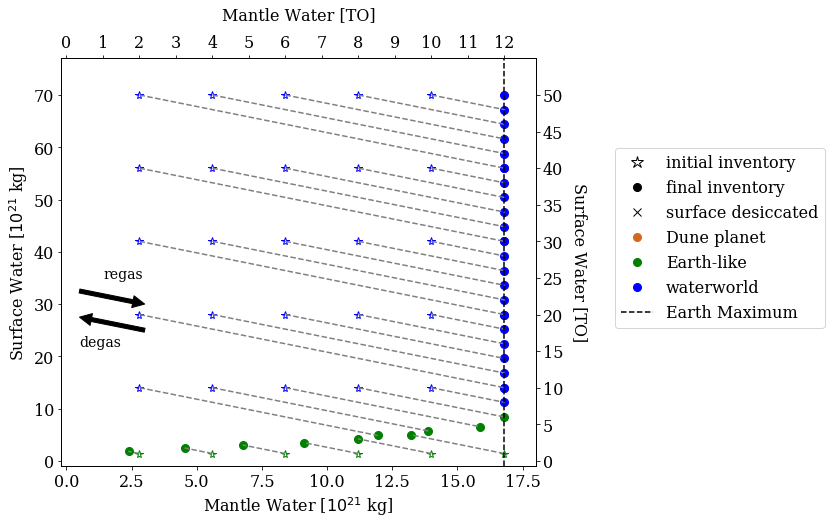

In [44]:
# 1) SEPARATE AXIS TITLES INDICATING THE NUMBER OF OCEANS OF WATER ON SURFACE/IN MANTLE
# 2) COLOUR-CODED POINTS BASED ON WHERE THEY FALL ON THE PLOT (NOTE: LIMITS NOT FINALIZED)
# 3) GREY LINES JOINING THE INITIAL/FINAL PARAMETERS
# 4) ARROWS INDICATING DIRECTION OF DEGASSING, REGASSING, LOSS IN PLOT

# A) SEAFLOOR PRESSURE DEPENDENT ONLY

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_CA)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for CA model.
    # Choose corresponding colour for final values, for CA model.
    if s_final_CA[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_CA = 'k'
        marker_CA = 'x'
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_CA = 'chocolate' #Dune planet
        marker_CA = 'o'
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_CA = 'green' #habitable
        marker_CA = 'o'
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_CA = 'b' #waterworld
        marker_CA = 'o'
    
    ax1.plot(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color=fin_color_CA, marker=marker_CA, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_CA[idx,:]*kg_conv/1000./1.0e18, s_path_CA[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line connecting initial and final water inventories.
    #ax1.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured_noloss.pdf', bbox_inches='tight')

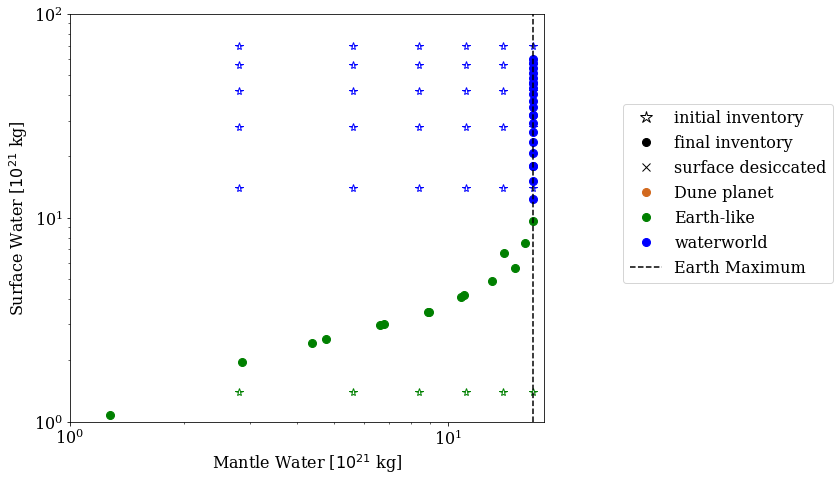

In [265]:
# Same as above, but log-log plot instead.
# 4) ARROWS INDICATING DIRECTION OF DEGASSING, REGASSING, LOSS IN PLOT

# A) SEAFLOOR PRESSURE DEPENDENT ONLY

%matplotlib inline
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_CA)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for CA model.
    # Choose corresponding colour for final values, for CA model.
    if s_final_CA[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_CA = 'k'
        marker_CA = 'x'
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_CA = 'chocolate' #Dune planet
        marker_CA = 'o'
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_CA = 'green' #habitable
        marker_CA = 'o'
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_CA = 'b' #waterworld
        marker_CA = 'o'
    
    ax1.loglog(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color=fin_color_CA, marker=marker_CA, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.loglog(x_path_CA[idx,:]*kg_conv/1000./1.0e18, s_path_CA[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line connecting initial and final water inventories.
    #ax1.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0, 18.)
ax1.set_ylim(1.0, 1.0e2)

#ax2.set_xlim(1.0, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 77.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured_loglog.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_CA_coloured_noloss.pdf', bbox_inches='tight')

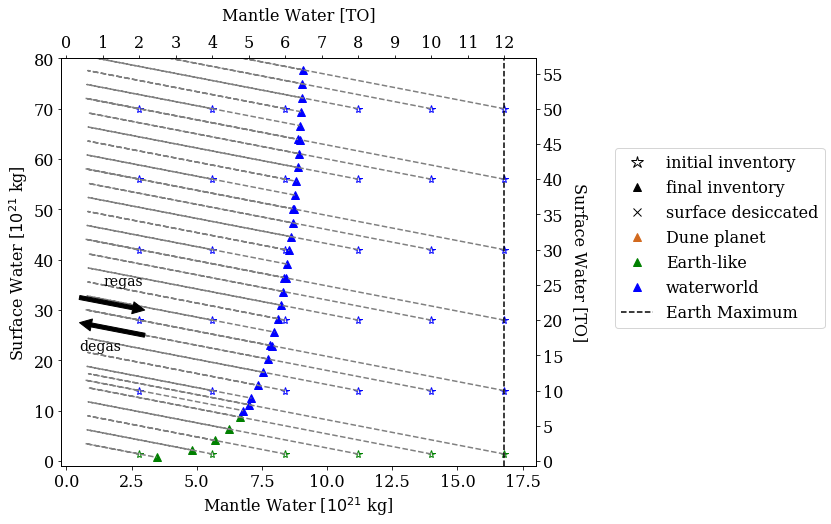

In [45]:
# B) MANTLE TEMPERATURE DEPENDENT ONLY

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS = 'k'
        marker_SS = 'x'
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS = 'chocolate' #Dune planet
        marker_SS = '^'
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS[idx]*kg_conv/1000./1.0e18 < 10.0:
        fin_color_SS = 'green' #habitable
        marker_SS = '^'
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 >= 10.0:
        fin_color_SS = 'b' #waterworld
        marker_SS = '^'
    
    ax1.plot(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color=fin_color_SS, marker=marker_SS, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_SS[idx,:]*kg_conv/1000./1.0e18, s_path_SS[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 80.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 80.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_nolegend.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_SS_coloured_noloss.pdf', bbox_inches='tight')

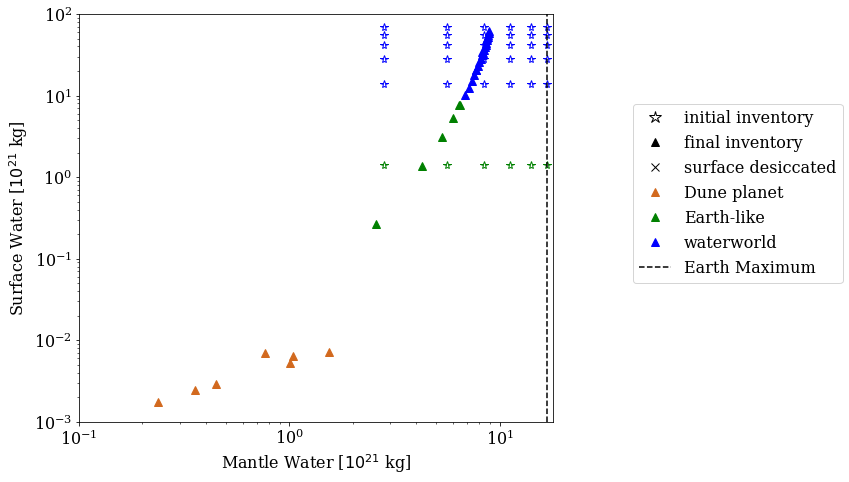

In [267]:
# Same as above, but log-log.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS = 'k'
        marker_SS = 'x'
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS = 'chocolate' #Dune planet
        marker_SS = '^'
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS = 'green' #habitable
        marker_SS = '^'
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS = 'b' #waterworld
        marker_SS = '^'
    
    ax1.loglog(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color=fin_color_SS, marker=marker_SS, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_SS[idx,:]*kg_conv/1000./1.0e18, s_path_SS[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0e-1, 18.)
ax1.set_ylim(1.0e-3, 1.0e2)

#ax2.set_xlim(-0.2, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 80.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_loglog.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_noloss.pdf', bbox_inches='tight')

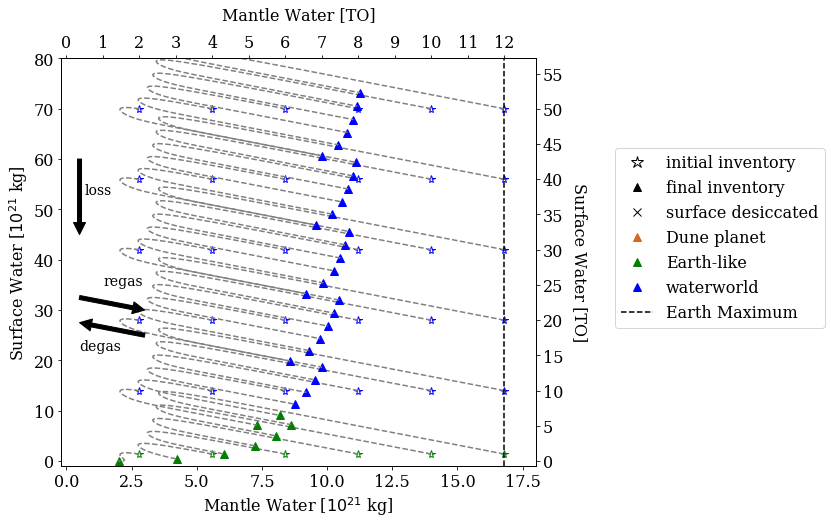

In [271]:
# B2) T-dependent, comparing default mantle temp. vs. cooler mantle temp.
## Try just cooler mantle one for now, join them in paper.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
#ax = [fig.add_subplot(2,i+1,1) for i in range(2)]

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#fig.subplots_adjust(hspace=0)
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS_cool)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS_cool[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS_cool = 'k'
        marker_SS_cool = 'x'
    elif s_final_SS_cool[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS_cool[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS_cool = 'chocolate' #Dune planet
        marker_SS_cool = '^'
    elif s_final_SS_cool[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS_cool[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS_cool = 'green' #habitable
        marker_SS_cool = '^'
    elif s_final_SS_cool[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS_cool = 'b' #waterworld
        marker_SS_cool = '^'
    
    ax1.plot(x_initial_SS_cool[idx]*kg_conv/1000./1.0e18, s_initial_SS_cool[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_SS_cool[idx]*kg_conv/1000./1.0e18, s_final_SS_cool[idx]*kg_conv/1000./1.0e18, color=fin_color_SS_cool, marker=marker_SS_cool, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_SS_cool[idx,:]*kg_conv/1000./1.0e18, s_path_SS_cool[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 80.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 80.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_coolermantle.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_coolermantle_nolegend.pdf', bbox_inches='tight')

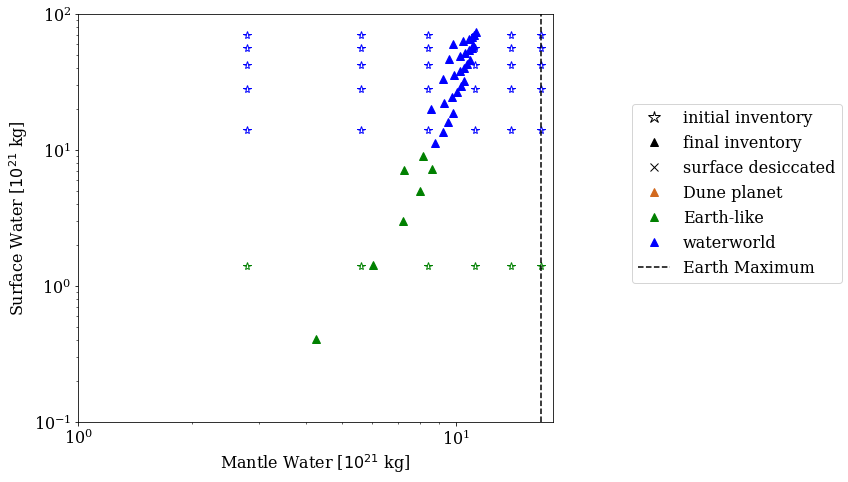

In [273]:
# Same as above but log-log.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
#ax = [fig.add_subplot(2,i+1,1) for i in range(2)]

ax1 = plt.subplot(1,1,1)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#fig.subplots_adjust(hspace=0)
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS_cool)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS_cool[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS_cool = 'k'
        marker_SS_cool = 'x'
    elif s_final_SS_cool[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS_cool[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS_cool = 'chocolate' #Dune planet
        marker_SS_cool = '^'
    elif s_final_SS_cool[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS_cool[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS_cool = 'green' #habitable
        marker_SS_cool = '^'
    elif s_final_SS_cool[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS_cool = 'b' #waterworld
        marker_SS_cool = '^'
    
    ax1.loglog(x_initial_SS_cool[idx]*kg_conv/1000./1.0e18, s_initial_SS_cool[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_SS_cool[idx]*kg_conv/1000./1.0e18, s_final_SS_cool[idx]*kg_conv/1000./1.0e18, color=fin_color_SS_cool, marker=marker_SS_cool, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_SS_cool[idx,:]*kg_conv/1000./1.0e18, s_path_SS_cool[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0, 18.)
ax1.set_ylim(1.0e-1, 1.0e2)

#ax2.set_xlim(-0.2, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 80.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
plt.savefig('Grid_Parameter_Search_SS_coloured_coolermantle_loglog.pdf', bbox_inches='tight')

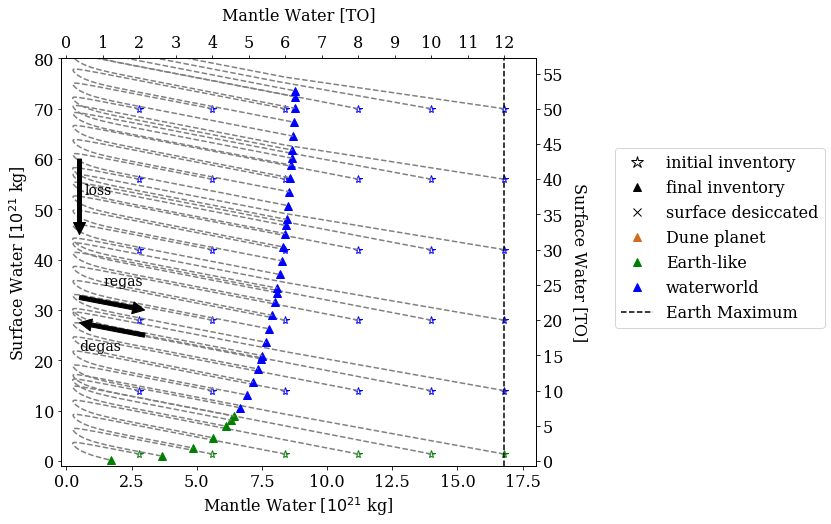

In [274]:
# B3) T-dependent, comparing default mantle temp. vs. hotter mantle temp.
## Try just hotter mantle one for now, join them in paper.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
#ax = [fig.add_subplot(2,i+1,1) for i in range(2)]

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#fig.subplots_adjust(hspace=0)
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS_hot)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS_hot[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS_hot = 'k'
        marker_SS_hot = 'x'
    elif s_final_SS_hot[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS_hot[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS_hot = 'chocolate' #Dune planet
        marker_SS_hot = '^'
    elif s_final_SS_hot[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS_hot[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS_hot = 'green' #habitable
        marker_SS_hot = '^'
    elif s_final_SS_hot[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS_hot = 'b' #waterworld
        marker_SS_hot = '^'
    
    ax1.plot(x_initial_SS_hot[idx]*kg_conv/1000./1.0e18, s_initial_SS_hot[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_SS_hot[idx]*kg_conv/1000./1.0e18, s_final_SS_hot[idx]*kg_conv/1000./1.0e18, color=fin_color_SS_hot, marker=marker_SS_hot, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_SS_hot[idx,:]*kg_conv/1000./1.0e18, s_path_SS_hot[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 80.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 80.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_SS_coloured_hottermantle.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_hottermantle_nolegend.pdf', bbox_inches='tight')

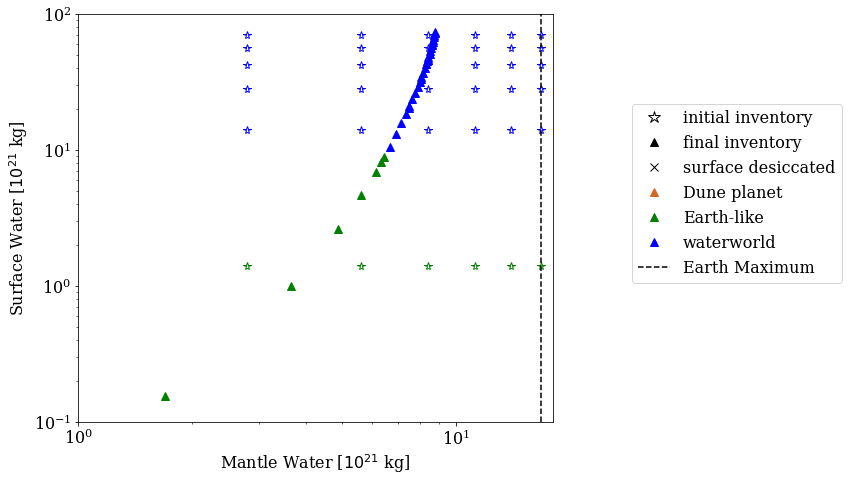

In [275]:
# Same as above, but log-log.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
#ax = [fig.add_subplot(2,i+1,1) for i in range(2)]

ax1 = plt.subplot(1,1,1)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#fig.subplots_adjust(hspace=0)
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS_hot)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS_hot[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS_hot = 'k'
        marker_SS_hot = 'x'
    elif s_final_SS_hot[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS_hot[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS_hot = 'chocolate' #Dune planet
        marker_SS_hot = '^'
    elif s_final_SS_hot[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS_hot[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS_hot = 'green' #habitable
        marker_SS_hot = '^'
    elif s_final_SS_hot[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS_hot = 'b' #waterworld
        marker_SS_hot = '^'
    
    ax1.loglog(x_initial_SS_hot[idx]*kg_conv/1000./1.0e18, s_initial_SS_hot[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_SS_hot[idx]*kg_conv/1000./1.0e18, s_final_SS_hot[idx]*kg_conv/1000./1.0e18, color=fin_color_SS_hot, marker=marker_SS_hot, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_SS_hot[idx,:]*kg_conv/1000./1.0e18, s_path_SS_hot[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0, 18.)
ax1.set_ylim(1.0e-1, 1.0e2)

#ax2.set_xlim(-0.2, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 80.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
plt.savefig('Grid_Parameter_Search_SS_coloured_hottermantle_loglog.pdf', bbox_inches='tight')

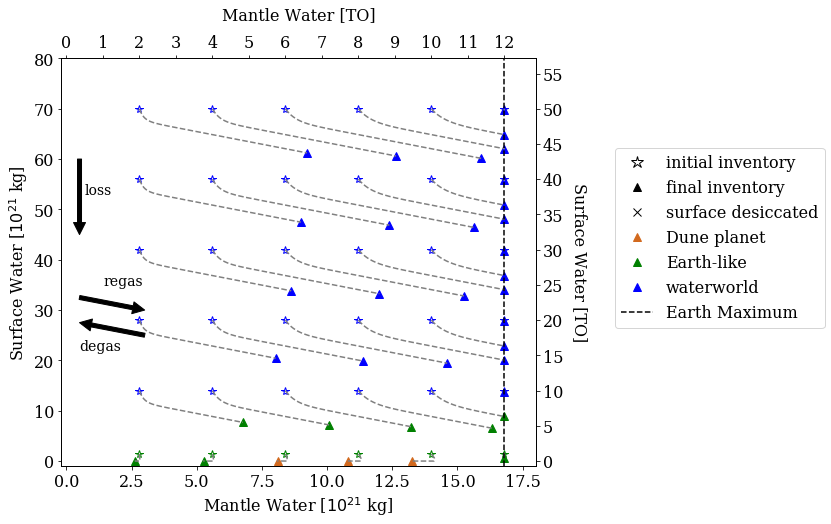

In [36]:
# B4) T-dependent, comparing default mantle temp. vs. initial mantle temp = T_ref.
## Try just T_ref mantle one for now, join them in paper.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
#ax = [fig.add_subplot(2,i+1,1) for i in range(2)]

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#fig.subplots_adjust(hspace=0)
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS_Tref)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS_Tref = 'k'
        marker_SS_Tref = 'x'
    elif s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS_Tref = 'chocolate' #Dune planet
        marker_SS_Tref = '^'
    elif s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS_Tref = 'green' #habitable
        marker_SS_Tref = '^'
    elif s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS_Tref = 'b' #waterworld
        marker_SS_Tref = '^'
    
    ax1.plot(x_initial_SS_Tref[idx]*kg_conv/1000./1.0e18, s_initial_SS_Tref[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_SS_Tref[idx]*kg_conv/1000./1.0e18, s_final_SS_Tref[idx]*kg_conv/1000./1.0e18, color=fin_color_SS_Tref, marker=marker_SS_Tref, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_SS_Tref[idx,:]*kg_conv/1000./1.0e18, s_path_SS_Tref[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 80.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 80.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_SS_coloured_Tref.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_SS_coloured_Tref_nolegend.pdf', bbox_inches='tight')

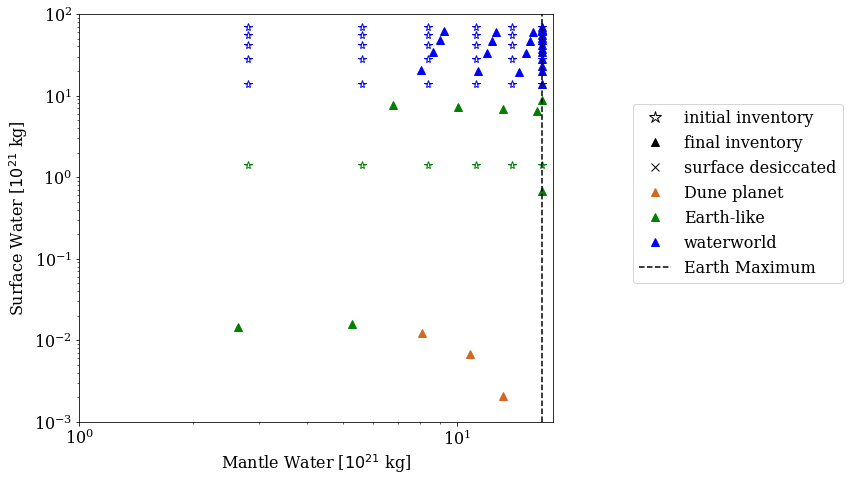

In [37]:
# Same as above, but log-log.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
#ax = [fig.add_subplot(2,i+1,1) for i in range(2)]

ax1 = plt.subplot(1,1,1)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#fig.subplots_adjust(hspace=0)
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_SS_Tref)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_SS_Tref = 'k'
        marker_SS_Tref = 'x'
    elif s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS_Tref = 'chocolate' #Dune planet
        marker_SS_Tref = '^'
    elif s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS_Tref = 'green' #habitable
        marker_SS_Tref = '^'
    elif s_final_SS_Tref[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS_Tref = 'b' #waterworld
        marker_SS_Tref = '^'
    
    ax1.loglog(x_initial_SS_Tref[idx]*kg_conv/1000./1.0e18, s_initial_SS_Tref[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_SS_Tref[idx]*kg_conv/1000./1.0e18, s_final_SS_Tref[idx]*kg_conv/1000./1.0e18, color=fin_color_SS_Tref, marker=marker_SS_Tref, linestyle='', markersize=8) 
  
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_SS_Tref[idx,:]*kg_conv/1000./1.0e18, s_path_SS_Tref[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')

    # Plot a straight line showing the evolution path.
    #ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='^', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='^', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='^', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0, 18.)
ax1.set_ylim(1.0e-3, 1.0e2)

#ax2.set_xlim(-0.2, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 80.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
plt.savefig('Grid_Parameter_Search_SS_coloured_Tref_loglog.pdf', bbox_inches='tight')

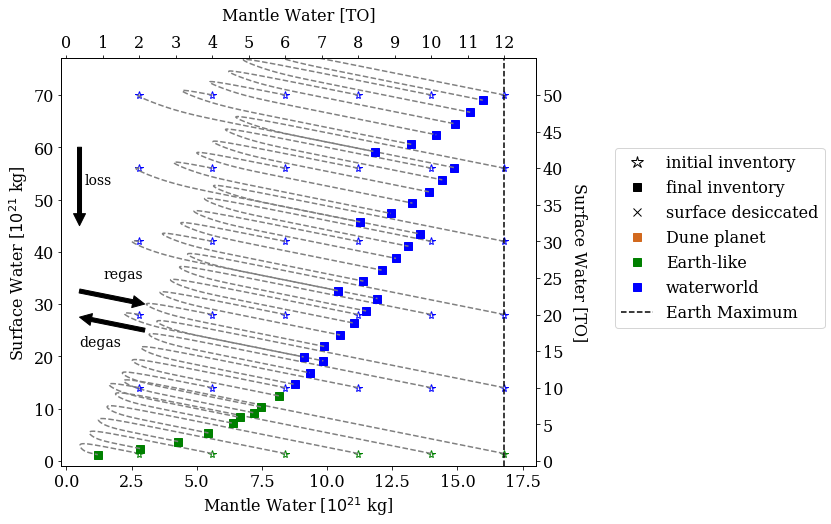

In [175]:
# C) HYBRID ONLY

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb = 'k'
        marker_hyb = 'x'
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb = 'chocolate' #Dune planet
        marker_hyb = 's'
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb = 'green' #habitable
        marker_hyb = 's'
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb = 'b' #waterworld
        marker_hyb = 's'
    
    ax1.plot(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb, marker=marker_hyb, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_hyb[idx,:]*kg_conv/1000./1.0e18, s_path_hyb[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_hyb_coloured.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

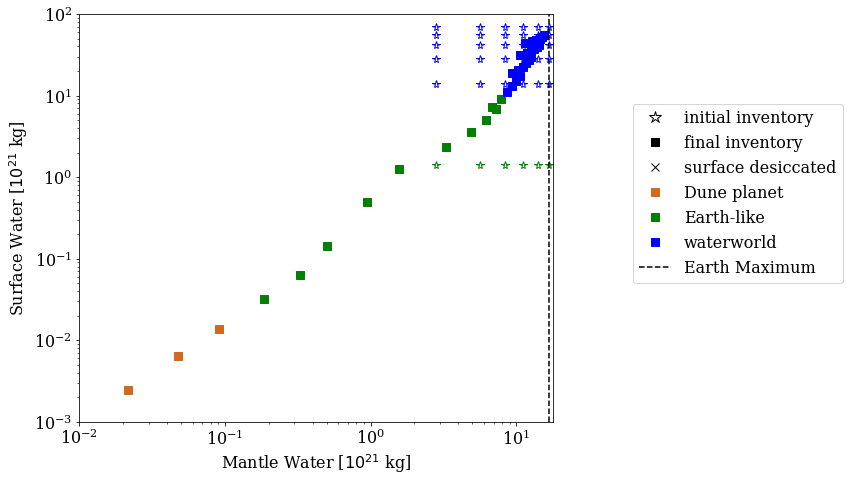

In [39]:
# Same as above, but log-log.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb = 'k'
        marker_hyb = 'x'
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb = 'chocolate' #Dune planet
        marker_hyb = 's'
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb = 'green' #habitable
        marker_hyb = 's'
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb = 'b' #waterworld
        marker_hyb = 's'
    
    ax1.loglog(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb, marker=marker_hyb, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_hyb[idx,:]*kg_conv/1000./1.0e18, s_path_hyb[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0e-2, 18.)
ax1.set_ylim(1.0e-3, 1.0e2)

#ax2.set_xlim(-0.2, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 77.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_hyb_coloured_loglog.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

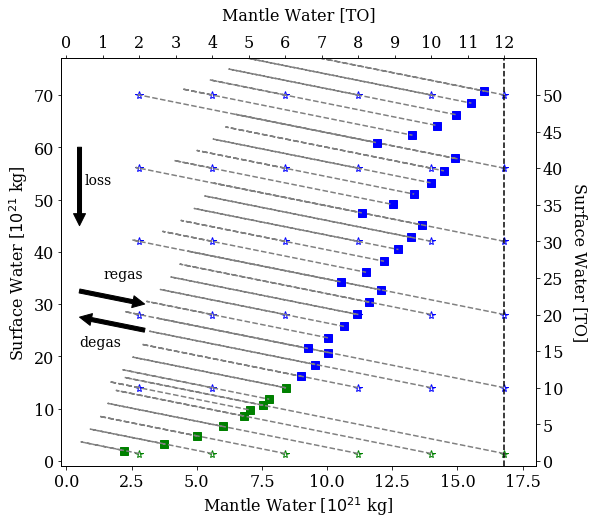

In [75]:
# C2) HYBRID, 0.01*default loss rate

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_0d01)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_0d01 = 'k'
        marker_hyb_0d01 = 'x'
    elif s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_0d01 = 'chocolate' #Dune planet
        marker_hyb_0d01 = 's'
    elif s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_0d01 = 'green' #habitable
        marker_hyb_0d01 = 's'
    elif s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_0d01 = 'b' #waterworld
        marker_hyb_0d01 = 's'
    
    ax1.plot(x_initial_hyb_0d01[idx]*kg_conv/1000./1.0e18, s_initial_hyb_0d01[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb_0d01[idx]*kg_conv/1000./1.0e18, s_final_hyb_0d01[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_0d01, marker=marker_hyb_0d01, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_hyb_0d01[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_0d01[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_0d01_default_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

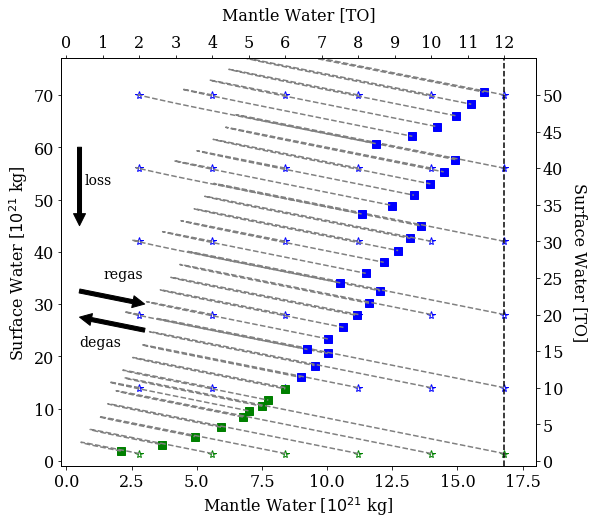

In [74]:
# C3) HYBRID, 0.1*default loss rate

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_0d1)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_0d1 = 'k'
        marker_hyb_0d1 = 'x'
    elif s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_0d1 = 'chocolate' #Dune planet
        marker_hyb_0d1 = 's'
    elif s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_0d1 = 'green' #habitable
        marker_hyb_0d1 = 's'
    elif s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_0d1 = 'b' #waterworld
        marker_hyb_0d1 = 's'
    
    ax1.plot(x_initial_hyb_0d1[idx]*kg_conv/1000./1.0e18, s_initial_hyb_0d1[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb_0d1[idx]*kg_conv/1000./1.0e18, s_final_hyb_0d1[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_0d1, marker=marker_hyb_0d1, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_hyb_0d1[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_0d1[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_hyb_coloured_0d1_default_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

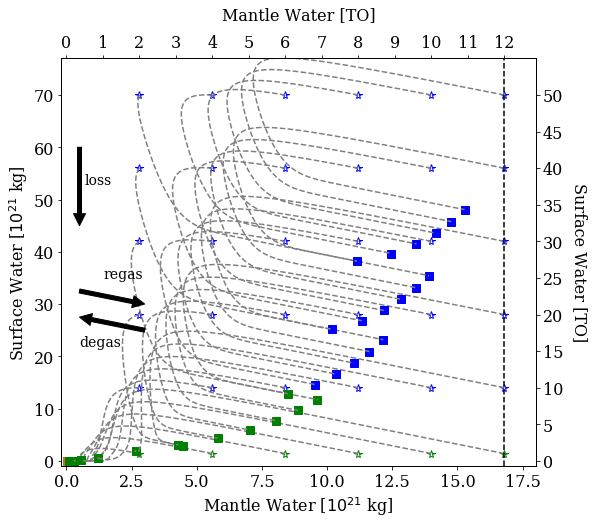

In [73]:
# C4) HYBRID, 10*default loss rate

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_10)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_10[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_10 = 'k'
        marker_hyb_10 = 'x'
    elif s_final_hyb_10[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_10[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_10 = 'chocolate' #Dune planet
        marker_hyb_10 = 's'
    elif s_final_hyb_10[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_10[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_10 = 'green' #habitable
        marker_hyb_10 = 's'
    elif s_final_hyb_10[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_10 = 'b' #waterworld
        marker_hyb_10 = 's'
    
    ax1.plot(x_initial_hyb_10[idx]*kg_conv/1000./1.0e18, s_initial_hyb_10[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb_10[idx]*kg_conv/1000./1.0e18, s_final_hyb_10[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_10, marker=marker_hyb_10, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    ax1.plot(x_path_hyb_10[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_10[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_10_default.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_10_default_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

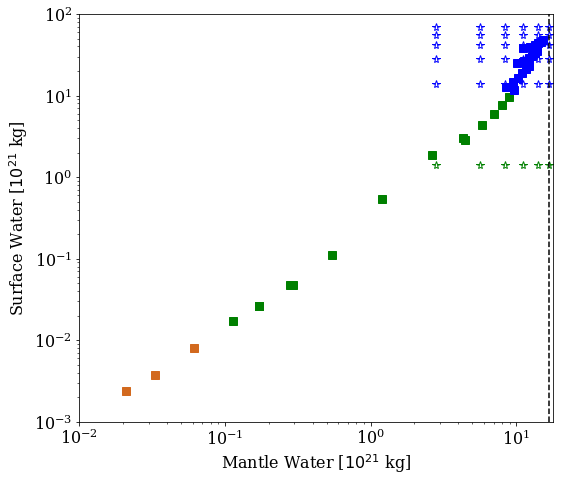

In [44]:
# Same as above, but log-log.

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
#ax2 = ax1.twiny()
#ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_10[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_10 = 'k'
        marker_hyb_10 = 'x'
    elif s_final_hyb_10[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_10[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_10 = 'chocolate' #Dune planet
        marker_hyb_10 = 's'
    elif s_final_hyb_10[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_10[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_10 = 'green' #habitable
        marker_hyb_10 = 's'
    elif s_final_hyb_10[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_10 = 'b' #waterworld
        marker_hyb_10 = 's'
    
    ax1.loglog(x_initial_hyb_10[idx]*kg_conv/1000./1.0e18, s_initial_hyb_10[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.loglog(x_final_hyb_10[idx]*kg_conv/1000./1.0e18, s_final_hyb_10[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_10, marker=marker_hyb_10, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_hyb[idx,:]*kg_conv/1000./1.0e18, s_path_hyb[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(1.0e-2, 18.)
ax1.set_ylim(1.0e-3, 1.0e2)

#ax2.set_xlim(-0.2, 18.)
#ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
#ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
#ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

#ax3.set_ylim(-1., 77.)
#ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
#ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
#ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

#ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
#ax1.text(1.4, 35, 'regas', fontsize=14)
#ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
#ax1.text(0.5, 22, 'degas', fontsize=14)
#ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
#ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
plt.savefig('Grid_Parameter_Search_hyb_coloured_loglog_10_default.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

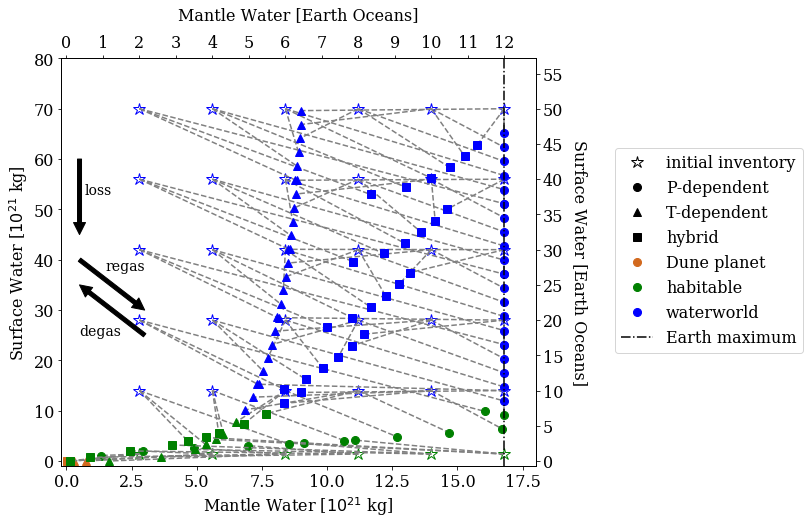

In [52]:
# D) ALL ON THE SAME PLOT

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]

for idx in range(0,len(x_initial_CA)):
        
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld
        
    # Choose corresponding colour for final values, for CA model.
    if s_final_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_CA = 'chocolate' #Dune planet
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_CA[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_CA = 'green' #habitable
    elif s_final_CA[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_CA = 'b' #waterworld
        
    # Choose corresponding colour for final values, for SS model.
    if s_final_SS[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_SS = 'chocolate' #Dune planet
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_SS[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_SS = 'green' #habitable
    elif s_final_SS[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_SS = 'b' #waterworld
        
    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb = 'chocolate' #Dune planet
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb = 'green' #habitable
    elif s_final_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb = 'b' #waterworld
       
    ax1.plot([x_initial_CA[idx]*kg_conv/1000./1.0e18, x_final_CA[idx]*kg_conv/1000./1.0e18], [s_initial_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
    ax1.plot(x_initial_CA[idx]*kg_conv/1000./1.0e18, s_initial_CA[idx]*kg_conv/1000./1.0e18, fillstyle='none', color=init_color, marker='*', linestyle='', markersize=12)
    ax1.plot(x_final_CA[idx]*kg_conv/1000./1.0e18, s_final_CA[idx]*kg_conv/1000./1.0e18, color=fin_color_CA, marker='o', linestyle='', markersize=8) 
    
    ax1.plot([x_initial_SS[idx]*kg_conv/1000./1.0e18, x_final_SS[idx]*kg_conv/1000./1.0e18], [s_initial_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
    #ax1.plot(x_initial_SS[idx]*kg_conv/1000./1.0e18, s_initial_SS[idx]*kg_conv/1000./1.0e18, color=init_color, marker='*', linestyle='', markersize=12)
    ax1.plot(x_final_SS[idx]*kg_conv/1000./1.0e18, s_final_SS[idx]*kg_conv/1000./1.0e18, color=fin_color_SS, marker='^', linestyle='', markersize=8) 
    
    ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
    #ax1.plot(x_initial_hyb[idx]*kg_conv/1000./1.0e18, s_initial_hyb[idx]*kg_conv/1000./1.0e18, color=init_color, marker='*', linestyle='', markersize=12)
    ax1.plot(x_final_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb, marker='s', linestyle='', markersize=8) 

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='o', linestyle='', markersize=8, label='P-dependent')
ax1.plot(100., 100., color='k', marker='^', linestyle='', markersize=8, label='T-dependent')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='hybrid')
#ax1.plot(100., 100., color='gold', marker='o',linestyle='', markersize=8, label='stagnant lid')
ax1.plot(100., 100., color='chocolate', marker='o', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='o', linestyle='', markersize=8, label='habitable')
ax1.plot(100., 100., color='b', marker='o', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='-.', label='Earth maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 80.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [Earth Oceans]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 80.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0, 77.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50', '55'])
ax3.set_ylabel('Surface Water [Earth Oceans]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 40.), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.5, 38, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 35.), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 25, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Parameter_Grid_Search_allmodels_coloured.pdf', bbox_inches='tight')

In [ ]:
# Stagnant lid conditions for above plot -- IF EVER NEEDED AGAIN
# Must be edited for final conditions of CA, SS, hyb models (all initial conditions the same).

# Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
#    # Stagnant lid check -- NOT CURRENTLY USED
#    if eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) <= 1.0e18 or eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) >= 1.0e26:
#        init_color = 'gold' #stagnant lid
#    elif eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) > 1.0e18 and eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) < 1.0e26 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
#        init_color = 'chocolate' #Dune planet
#    elif eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) > 1.0e18 and eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) < 1.0e26 and s_initial_CA[idx]*kg_conv/1000./1.0e18 > 0.01*1.4 and s_initial_CA[idx]*kg_conv/1000./1.0e18 < 10.0:
#        init_color = 'green' #habitable
#    elif eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) > 1.0e18 and eta(T_initial_CA[idx], x_initial_CA[idx], params1, params2, params3) < 1.0e26 and s_initial_CA[idx]*kg_conv/1000./1.0e18 > 10.0:
#        init_color = 'b' #waterworld

## Test -- vary initial parameters by +/-1%, compare to unvaried results

In [142]:
# Plot |final+/-0.01 - real| vs. |initial+/-0.01 - real|, where "real" is the full default runs

# Read in data files to figure out final x and s fractions.

tolerance = 1e-21 #anything below this, no water (<1 kg of water)

#+1% runs
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_+1percent/'

# Initial water content in each reservoir
#x_initial_CA_p001 = np.zeros(len(filenums))
#s_initial_CA_p001 = np.zeros(len(filenums))
#x_initial_SS_p001 = np.zeros(len(filenums))
#s_initial_SS_p001 = np.zeros(len(filenums))
x_initial_hyb_p001 = np.zeros(len(filenums))
s_initial_hyb_p001 = np.zeros(len(filenums))

# Final water content in each reservoir
#x_final_CA_p001 = np.zeros(len(filenums))
#s_final_CA_p001 = np.zeros(len(filenums))
#x_final_SS_p001 = np.zeros(len(filenums))
#s_final_SS_p001 = np.zeros(len(filenums))
x_final_hyb_p001 = np.zeros(len(filenums))
s_final_hyb_p001 = np.zeros(len(filenums))

for idx in range(0,len(filenums)):
    # Read in data files for each model.
    #save_file = 'cycling_CA_grid_test' + filenums[idx] + '.txt' #change this to see different results
    #filename = os.path.join(save_path, save_file)
    #tmp_data = np.loadtxt(filename)
    #x_array_CA = tmp_data[:,2]
    #s_array_CA = tmp_data[:,3]
    
    #save_file = 'cycling_SS_grid_test' + filenums[idx] + '.txt' #change this to see different results
    #filename = os.path.join(save_path, save_file)
    #tmp_data = np.loadtxt(filename)
    #x_array_SS = tmp_data[:,2]
    #s_array_SS = tmp_data[:,3]
    
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    x_array_hyb = tmp_data[:,2]
    s_array_hyb = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    #x_initial_CA_p001[idx] = x_array_CA[0]
    #s_initial_CA_p001[idx] = s_array_CA[0]
    #x_initial_SS_p001[idx] = x_array_SS[0]
    #s_initial_SS_p001[idx] = s_array_SS[0]
    x_initial_hyb_p001[idx] = x_array_hyb[0]
    s_initial_hyb_p001[idx] = s_array_hyb[0]
    
    #x_final_CA_p001[idx] = x_array_CA[-1]
    #s_final_CA_p001[idx] = s_array_CA[-1]
    #x_final_SS_p001[idx] = x_array_SS[-1]
    #s_final_SS_p001[idx] = s_array_SS[-1]
    x_final_hyb_p001[idx] = x_array_hyb[-1]
    s_final_hyb_p001[idx] = s_array_hyb[-1]

    
# Difference between these runs and actual runs.
#x_initial_CA_up = np.divide(np.absolute(x_initial_CA_p001 - x_initial_CA), x_initial_CA)
#s_initial_CA_up = np.divide(np.absolute(s_initial_CA_p001 - s_initial_CA), s_initial_CA)
#x_initial_SS_up = np.divide(np.absolute(x_initial_SS_p001 - x_initial_SS), x_initial_SS)
#s_initial_SS_up = np.divide(np.absolute(s_initial_SS_p001 - s_initial_SS), s_initial_SS)
x_initial_hyb_up = np.divide(np.absolute(x_initial_hyb_p001 - x_initial_hyb), x_initial_hyb)
s_initial_hyb_up = np.divide(np.absolute(s_initial_hyb_p001 - s_initial_hyb), s_initial_hyb)

#x_final_CA_up = np.divide(np.absolute(x_final_CA_p001 - x_final_CA), x_final_CA)
#s_final_CA_up = np.divide(np.absolute(s_final_CA_p001 - s_final_CA), s_final_CA)
#x_final_SS_up = np.divide(np.absolute(x_final_SS_p001 - x_final_SS), x_final_SS)
#s_final_SS_up = np.divide(np.absolute(s_final_SS_p001 - s_final_SS), s_final_SS)
x_final_hyb_up = np.divide(np.absolute(x_final_hyb_p001 - x_final_hyb), x_final_hyb)
s_final_hyb_up = np.divide(np.absolute(s_final_hyb_p001 - s_final_hyb), s_final_hyb)

In [143]:
#-1% runs
save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid_-1percent/'

# Initial water content in each reservoir
#x_initial_CA_m001 = np.zeros(len(filenums))
#s_initial_CA_m001 = np.zeros(len(filenums))
#x_initial_SS_m001 = np.zeros(len(filenums))
#s_initial_SS_m001 = np.zeros(len(filenums))
x_initial_hyb_m001 = np.zeros(len(filenums))
s_initial_hyb_m001 = np.zeros(len(filenums))

# Final water content in each reservoir
#x_final_CA_m001 = np.zeros(len(filenums))
#s_final_CA_m001 = np.zeros(len(filenums))
#x_final_SS_m001 = np.zeros(len(filenums))
#s_final_SS_m001 = np.zeros(len(filenums))
x_final_hyb_m001 = np.zeros(len(filenums))
s_final_hyb_m001 = np.zeros(len(filenums))

for idx in range(0,len(filenums)):
    # Read in data files for each model.
    #save_file = 'cycling_CA_grid_test' + filenums[idx] + '.txt' #change this to see different results
    #filename = os.path.join(save_path, save_file)
    #tmp_data = np.loadtxt(filename)
    #x_array_CA = tmp_data[:,2]
    #s_array_CA = tmp_data[:,3]
    
    #save_file = 'cycling_SS_grid_test' + filenums[idx] + '.txt' #change this to see different results
    #filename = os.path.join(save_path, save_file)
    #tmp_data = np.loadtxt(filename)
    #x_array_SS = tmp_data[:,2]
    #s_array_SS = tmp_data[:,3]
    
    save_file = 'cycling_hyb_grid_test' + filenums[idx] + '.txt' #change this to see different results
    filename = os.path.join(save_path, save_file)
    tmp_data = np.loadtxt(filename)
    x_array_hyb = tmp_data[:,2]
    s_array_hyb = tmp_data[:,3]
    
    # Save initial and final values to corresponding arrays.
    #x_initial_CA_m001[idx] = x_array_CA[0]
    #s_initial_CA_m001[idx] = s_array_CA[0]
    #x_initial_SS_m001[idx] = x_array_SS[0]
    #s_initial_SS_m001[idx] = s_array_SS[0]
    x_initial_hyb_m001[idx] = x_array_hyb[0]
    s_initial_hyb_m001[idx] = s_array_hyb[0]
    
    #x_final_CA_m001[idx] = x_array_CA[-1]
    #s_final_CA_m001[idx] = s_array_CA[-1]
    #x_final_SS_m001[idx] = x_array_SS[-1]
    #s_final_SS_m001[idx] = s_array_SS[-1]
    x_final_hyb_m001[idx] = x_array_hyb[-1]
    s_final_hyb_m001[idx] = s_array_hyb[-1]


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, '|final - final+/-0.01| / final')

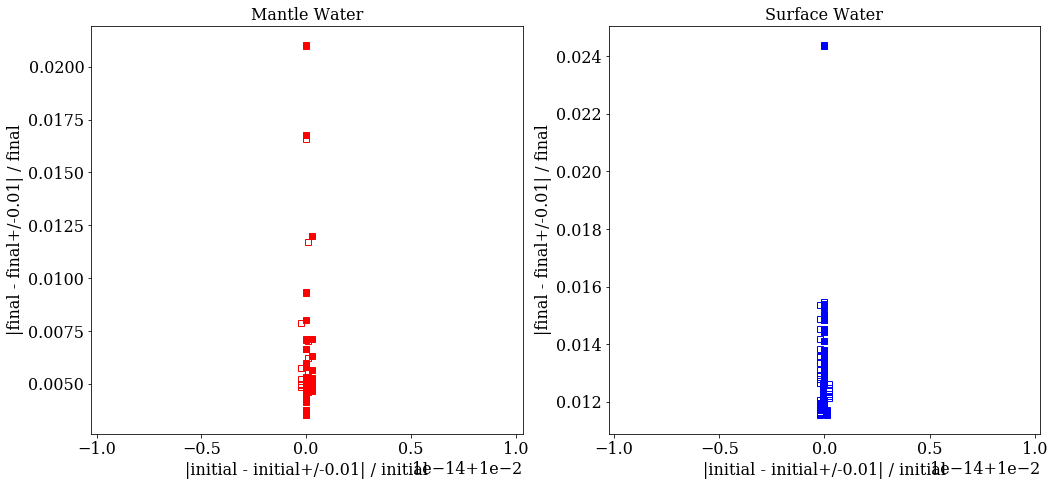

In [144]:
# Plot |final+/-0.01 - real| vs. |initial+/-0.01 - real|, where "real" is the full default runs
# NOTE: THE DIFFERENCE TESTED IS +/-0.01 OCEAN!!!

# Difference between these runs and actual runs.
#x_initial_CA_down = np.divide(np.absolute(x_initial_CA_m001 - x_initial_CA), x_initial_CA)
#s_initial_CA_down = np.divide(np.absolute(s_initial_CA_m001 - s_initial_CA), s_initial_CA)
#x_initial_SS_down = np.divide(np.absolute(x_initial_SS_m001 - x_initial_SS), x_initial_SS)
#s_initial_SS_down = np.divide(np.absolute(s_initial_SS_m001 - s_initial_SS), s_initial_SS)
x_initial_hyb_down = np.divide(np.absolute(x_initial_hyb_m001 - x_initial_hyb), x_initial_hyb)
s_initial_hyb_down = np.divide(np.absolute(s_initial_hyb_m001 - s_initial_hyb), s_initial_hyb)

#x_final_CA_down = np.divide(np.absolute(x_final_CA_m001 - x_final_CA), x_final_CA)
#s_final_CA_down = np.divide(np.absolute(s_final_CA_m001 - s_final_CA), s_final_CA)
#x_final_SS_down = np.divide(np.absolute(x_final_SS_m001 - x_final_SS), x_final_SS)
#s_final_SS_down = np.divide(np.absolute(s_final_SS_m001 - s_final_SS), s_final_SS)
x_final_hyb_down = np.divide(np.absolute(x_final_hyb_m001 - x_final_hyb), x_final_hyb)
s_final_hyb_down = np.divide(np.absolute(s_final_hyb_m001 - s_final_hyb), s_final_hyb)

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

# Mantle water
ax1 = plt.subplot(1,2,1)
#plt.plot(x_initial_CA_up, x_final_CA_up, marker='o', fillstyle='none', linestyle='', color='r', label='+0.01')
#plt.plot(x_initial_SS_up, x_final_SS_up, marker='^', fillstyle='none', linestyle='', color='r')
plt.plot(x_initial_hyb_up, x_final_hyb_up, marker='s', fillstyle='none',linestyle='', color='r')

#plt.plot(x_initial_CA_down, x_final_CA_down, marker='o', linestyle='', color='r', label='-0.01')
#plt.plot(x_initial_SS_down, x_final_SS_down, marker='^', linestyle='', color='r')
plt.plot(x_initial_hyb_down, x_final_hyb_down, marker='s', linestyle='', color='r')
#plt.legend(loc='lower right', fontsize=16)
plt.title('Mantle Water', fontsize=16)
plt.xlabel('|initial - initial+/-0.01| / initial', fontsize=16)
plt.ylabel('|final - final+/-0.01| / final', fontsize=16)

# Surface water
ax2 = plt.subplot(1,2,2)
#plt.plot(s_initial_CA_up, s_final_CA_up, marker='o', fillstyle='none', linestyle='', color='b', label='+0.01')
#plt.plot(s_initial_SS_up, s_final_SS_up, marker='^', fillstyle='none', linestyle='', color='b')
plt.plot(s_initial_hyb_up, s_final_hyb_up, marker='s', fillstyle='none',linestyle='', color='b')

#plt.plot(s_initial_CA_down, s_final_CA_down, marker='o', linestyle='', color='b', label='-0.01')
#plt.plot(s_initial_SS_down, s_final_SS_down, marker='^', linestyle='', color='b')
plt.plot(s_initial_hyb_down, s_final_hyb_down, marker='s', linestyle='', color='b')
#plt.legend(loc='right', fontsize=16)
plt.title('Surface Water', fontsize=16)
plt.xlabel('|initial - initial+/-0.01| / initial', fontsize=16)
plt.ylabel('|final - final+/-0.01| / final', fontsize=16)
#plt.savefig('Sensitivity_Grid_percentage_difference_plus_minus_0d01percent.pdf')

In [128]:
print(x_initial_CA_p001*kg_conv/1.4e21)

[ 2.02  4.04  6.06  8.08 10.1  12.12  2.02  4.04  6.06  8.08 10.1  12.12
  2.02  4.04  6.06  8.08 10.1  12.12  2.02  4.04  6.06  8.08 10.1  12.12
  2.02  4.04  6.06  8.08 10.1  12.12  2.02  4.04  6.06  8.08 10.1  12.12]


/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Text(0, 0.5, '|final - final+/-0.01| [$10^{21}$ kg]')

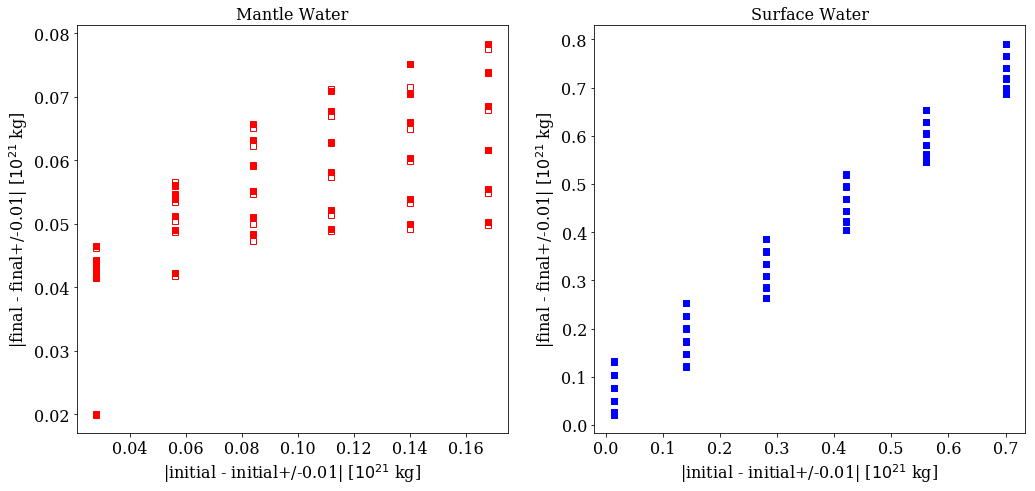

In [145]:
# Don't divide the values above.
# Difference between these runs and actual runs.

# Note: THE DIFFERENCE TESTED IS +/-0.01% OCEAN!!!

#x_initial_CA_up = np.absolute(x_initial_CA_p001 - x_initial_CA)
#s_initial_CA_up = np.absolute(s_initial_CA_p001 - s_initial_CA)
#x_initial_SS_up = np.absolute(x_initial_SS_p001 - x_initial_SS)
#s_initial_SS_up = np.absolute(s_initial_SS_p001 - s_initial_SS)
x_initial_hyb_up = np.absolute(x_initial_hyb_p001 - x_initial_hyb)
s_initial_hyb_up = np.absolute(s_initial_hyb_p001 - s_initial_hyb)

#x_final_CA_up = np.absolute(x_final_CA_p001 - x_final_CA)
#s_final_CA_up = np.absolute(s_final_CA_p001 - s_final_CA)
#x_final_SS_up = np.absolute(x_final_SS_p001 - x_final_SS)
#s_final_SS_up = np.absolute(s_final_SS_p001 - s_final_SS)
x_final_hyb_up = np.absolute(x_final_hyb_p001 - x_final_hyb)
s_final_hyb_up = np.absolute(s_final_hyb_p001 - s_final_hyb)

#x_initial_CA_down = np.absolute(x_initial_CA_m001 - x_initial_CA)
#s_initial_CA_down = np.absolute(s_initial_CA_m001 - s_initial_CA)
#x_initial_SS_down = np.absolute(x_initial_SS_m001 - x_initial_SS)
#s_initial_SS_down = np.absolute(s_initial_SS_m001 - s_initial_SS)
x_initial_hyb_down = np.absolute(x_initial_hyb_m001 - x_initial_hyb)
s_initial_hyb_down = np.absolute(s_initial_hyb_m001 - s_initial_hyb)

#x_final_CA_down = np.absolute(x_final_CA_m001 - x_final_CA)
#s_final_CA_down = np.absolute(s_final_CA_m001 - s_final_CA)
#x_final_SS_down = np.absolute(x_final_SS_m001 - x_final_SS)
#s_final_SS_down = np.absolute(s_final_SS_m001 - s_final_SS)
x_final_hyb_down = np.absolute(x_final_hyb_m001 - x_final_hyb)
s_final_hyb_down = np.absolute(s_final_hyb_m001 - s_final_hyb)

kg_conv = 2.3e-4*1.3*M_E #[kg]

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

# Mantle water
ax1 = plt.subplot(1,2,1)
#plt.plot(x_initial_CA_up*kg_conv/1.0e21, x_final_CA_up*kg_conv/1.0e21, marker='o', fillstyle='none', linestyle='', color='r', label='+0.01')
#plt.plot(x_initial_SS_up*kg_conv/1.0e21, x_final_SS_up*kg_conv/1.0e21, marker='^', fillstyle='none', linestyle='', color='r')
plt.plot(x_initial_hyb_up*kg_conv/1.0e21, x_final_hyb_up*kg_conv/1.0e21, marker='s', fillstyle='none',linestyle='', color='r')

#plt.plot(x_initial_CA_down*kg_conv/1.0e21, x_final_CA_down*kg_conv/1.0e21, marker='o', linestyle='', color='r', label='-0.01')
#plt.plot(x_initial_SS_down*kg_conv/1.0e21, x_final_SS_down*kg_conv/1.0e21, marker='^', linestyle='', color='r')
plt.plot(x_initial_hyb_down*kg_conv/1.0e21, x_final_hyb_down*kg_conv/1.0e21, marker='s', linestyle='', color='r')
#plt.legend(loc='upper center', fontsize=16)
plt.title('Mantle Water', fontsize=16)
plt.xlabel(r'|initial - initial+/-0.01| [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'|final - final+/-0.01| [$10^{21}$ kg]', fontsize=16)

# Surface water
ax2 = plt.subplot(1,2,2)
#plt.plot(s_initial_CA_up*kg_conv/1.0e21, s_final_CA_up*kg_conv/1.0e21, marker='o', fillstyle='none', linestyle='', color='b', label='+0.01')
#plt.plot(s_initial_SS_up*kg_conv/1.0e21, s_final_SS_up*kg_conv/1.0e21, marker='^', fillstyle='none', linestyle='', color='b')
plt.plot(s_initial_hyb_up*kg_conv/1.0e21, s_final_hyb_up*kg_conv/1.0e21, marker='s', fillstyle='none',linestyle='', color='b')

#plt.plot(s_initial_CA_down*kg_conv/1.0e21, s_final_CA_down*kg_conv/1.0e21, marker='o', linestyle='', color='b', label='-0.01')
#plt.plot(s_initial_SS_down*kg_conv/1.0e21, s_final_SS_down*kg_conv/1.0e21, marker='^', linestyle='', color='b')
plt.plot(s_initial_hyb_down*kg_conv/1.0e21, s_final_hyb_down*kg_conv/1.0e21, marker='s', linestyle='', color='b')
#plt.legend(loc='upper center', fontsize=16)
plt.title('Surface Water', fontsize=16)
plt.xlabel(r'|initial - initial+/-0.01| [$10^{21}$ kg]', fontsize=16)
plt.ylabel(r'|final - final+/-0.01| [$10^{21}$ kg]', fontsize=16)
#plt.savefig('Sensitivity_Grid_difference_plus_minus_0d01percent.pdf')

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


(-12.0, 9.0)

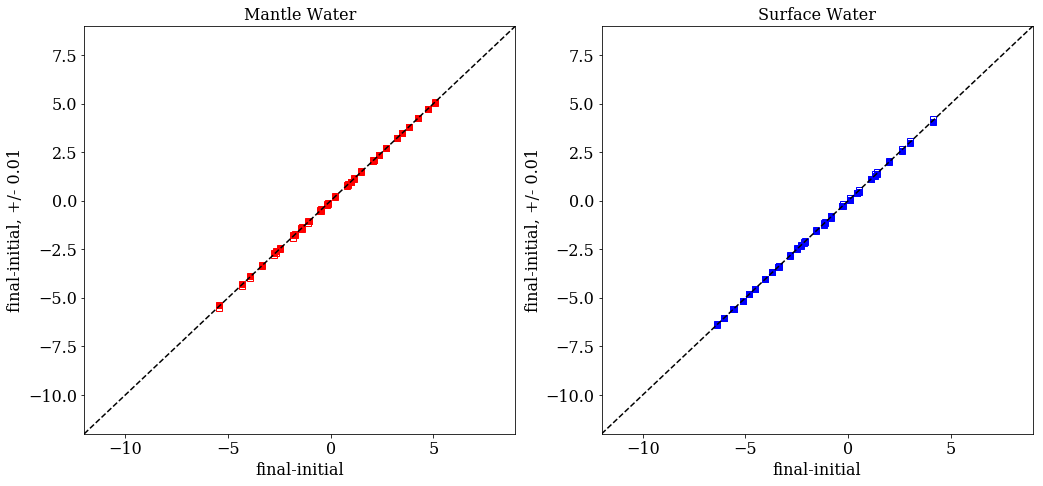

In [146]:
# Could also try plotting final - initial.
%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(17,7.5))
plt.tight_layout()
ax = [fig.add_subplot(1,2,i+1) for i in range(2)]
fig.subplots_adjust(hspace=0)

ax1 = plt.subplot(1,2,1)
#plt.plot(x_final_CA-x_initial_CA, x_final_CA_p001-x_initial_CA_p001, marker='o', fillstyle='none', linestyle='', color='r', label='+0.01')
#plt.plot(x_final_SS-x_initial_SS, x_final_SS_p001-x_initial_SS_p001, marker='^', fillstyle='none', linestyle='', color='r')
plt.plot(x_final_hyb-x_initial_hyb, x_final_hyb_p001-x_initial_hyb_p001, marker='s', fillstyle='none', linestyle='', color='r')
#plt.plot(x_final_CA-x_initial_CA, x_final_CA_m001-x_initial_CA_m001, marker='o', linestyle='', color='r', label='-0.01')
#plt.plot(x_final_SS-x_initial_SS, x_final_SS_m001-x_initial_SS_m001, marker='^', linestyle='', color='r')
plt.plot(x_final_hyb-x_initial_hyb, x_final_hyb_m001-x_initial_hyb_m001, marker='s', linestyle='', color='r')
plt.plot([-12, 10], [-12, 10], color='k', linestyle='--', marker='')
plt.xlabel('final-initial', fontsize=16)
plt.ylabel('final-initial, +/- 0.01', fontsize=16)
plt.title('Mantle Water', fontsize=16)
#plt.legend(loc='lower right', fontsize=16)
plt.xlim(-12., 9.)
plt.ylim(-12., 9.)

ax2 = plt.subplot(1,2,2)
#plt.plot(s_final_CA-s_initial_CA, s_final_CA_p001-s_initial_CA_p001, marker='o', fillstyle='none', linestyle='', color='b', label='+0.01')
#plt.plot(s_final_SS-s_initial_SS, s_final_SS_p001-s_initial_SS_p001, marker='^', fillstyle='none', linestyle='', color='b')
plt.plot(s_final_hyb-s_initial_hyb, s_final_hyb_p001-s_initial_hyb_p001, marker='s', fillstyle='none', linestyle='', color='b')
#plt.plot(s_final_CA-s_initial_CA, s_final_CA_m001-s_initial_CA_m001, marker='o', linestyle='', color='b', label='-0.01')
#plt.plot(s_final_SS-s_initial_SS, s_final_SS_m001-s_initial_SS_m001, marker='^', linestyle='', color='b')
plt.plot(s_final_hyb-s_initial_hyb, s_final_hyb_m001-s_initial_hyb_m001, marker='s', linestyle='', color='b')
plt.plot([-12, 10], [-12, 10], color='k', linestyle='--', marker='')
plt.xlabel('final-initial', fontsize=16)
plt.ylabel('final-initial, +/- 0.01', fontsize=16)
plt.title('Surface Water', fontsize=16)
#plt.legend(loc='lower right', fontsize=16)
plt.xlim(-12., 9.)
plt.ylim(-12., 9.)

Text(0.7, 53, 'loss')

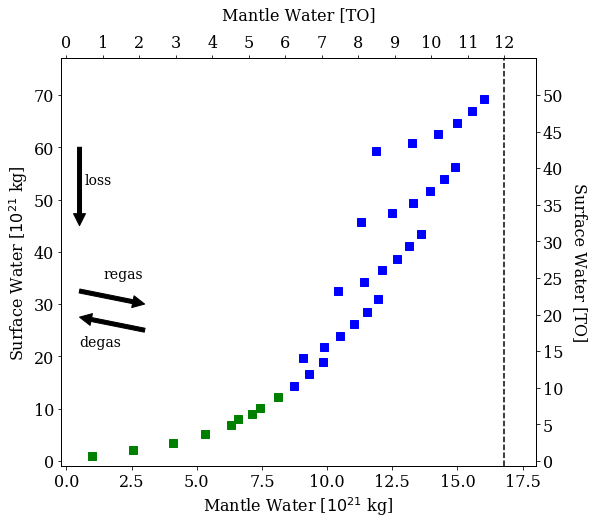

In [147]:
# Compare the surface vs. mantle plots, since these results seem like a huge spread.
# +1 percent

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_p001)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_p001[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_p001 = 'k'
        marker_hyb_p001 = 'x'
    elif s_final_hyb_p001[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_p001[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_p001 = 'chocolate' #Dune planet
        marker_hyb_p001 = 's'
    elif s_final_hyb_p001[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_p001[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_p001 = 'green' #habitable
        marker_hyb_p001 = 's'
    elif s_final_hyb_p001[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_p001 = 'b' #waterworld
        marker_hyb_p001 = 's'
    
    #ax1.plot(x_initial_hyb_up[idx]*kg_conv/1000./1.0e18, s_initial_hyb_up[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb_p001[idx]*kg_conv/1000./1.0e18, s_final_hyb_p001[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_p001, marker=marker_hyb_p001, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_hyb_10[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_10[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_10_default.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_10_default_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

Text(0.7, 53, 'loss')

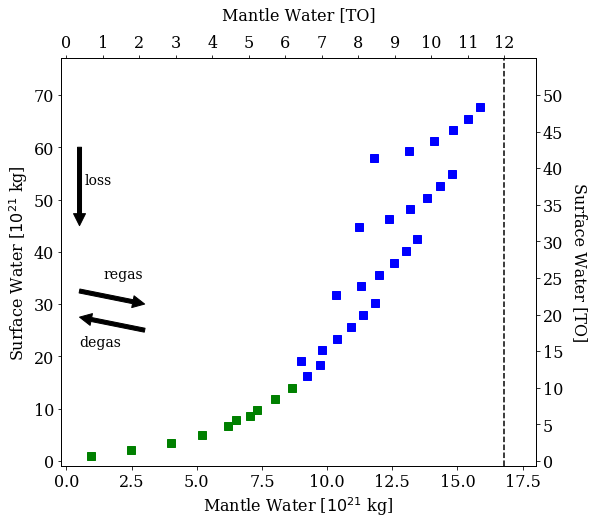

In [148]:
# Compare the surface vs. mantle plots, since these results seem like a huge spread.
# -1 percent

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax3 = ax1.twinx()
#plt.tight_layout()

kg_conv = 2.3e-4*1.3*M_E #[kg]
tolerance = (1.29e16/1.4e21)*1.4 #anything below this, no water (<~0.00001 TO)

for idx in range(0,len(x_initial_hyb_m001)):
    
    # Choose corresponding colour for initial values (NOTE: all initial conditions the same for each model.)
    if s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        init_color = 'chocolate' #Dune planet
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_initial_hyb[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        init_color = 'green' #habitable
    elif s_initial_hyb[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        init_color = 'b' #waterworld 

    # Choose corresponding colour for final values, for hybrid model.
    if s_final_hyb_m001[idx]*kg_conv/1000./1.0e18 < tolerance: #no surface water
        fin_color_hyb_m001 = 'k'
        marker_hyb_m001 = 'x'
    elif s_final_hyb_m001[idx]*kg_conv/1000./1.0e18 > tolerance and s_final_hyb_m001[idx]*kg_conv/1000./1.0e18 < 0.01*1.4:
        fin_color_hyb_m001 = 'chocolate' #Dune planet
        marker_hyb_m001 = 's'
    elif s_final_hyb_m001[idx]*kg_conv/1000./1.0e18 >= 0.01*1.4 and s_final_hyb_m001[idx]*kg_conv/1000./1.0e18 < 10.0*1.4:
        fin_color_hyb_m001 = 'green' #habitable
        marker_hyb_m001 = 's'
    elif s_final_hyb_m001[idx]*kg_conv/1000./1.0e18 >= 10.0*1.4:
        fin_color_hyb_m001 = 'b' #waterworld
        marker_hyb_m001 = 's'
    
    #ax1.plot(x_initial_hyb_down[idx]*kg_conv/1000./1.0e18, s_initial_hyb_down[idx]*kg_conv/1000./1.0e18,  fillstyle='none', color=init_color, marker='*', linestyle='', markersize=8)
    ax1.plot(x_final_hyb_m001[idx]*kg_conv/1000./1.0e18, s_final_hyb_m001[idx]*kg_conv/1000./1.0e18, color=fin_color_hyb_m001, marker=marker_hyb_m001, linestyle='', markersize=8) 
    
    # Plot a dashed grey line, showing the evolution path.
    #ax1.plot(x_path_hyb_10[idx,:]*kg_conv/1000./1.0e18, s_path_hyb_10[idx,:]*kg_conv/1000./1.0e18, color='grey', linestyle='--')
    
    #ax1.plot([x_initial_hyb[idx]*kg_conv/1000./1.0e18, x_final_hyb[idx]*kg_conv/1000./1.0e18], [s_initial_hyb[idx]*kg_conv/1000./1.0e18, s_final_hyb[idx]*kg_conv/1000./1.0e18], color='grey', linestyle='--')
#ax1.plot(x_final_CA[0]*kg_conv/1000./1.0e18, s_final_CA[0]*kg_conv/1000./1.0e18, color='r', marker='o', linestyle='', markersize=8)#, label='P-dependent')

# Handles for legend only
ax1.plot(100., 100., color='k', fillstyle='none', marker='*', linestyle='', markersize=12, label='initial inventory')
ax1.plot(100., 100., color='k', marker='s', linestyle='', markersize=8, label='final inventory')
ax1.plot(100., 100., color='k', marker='x', linestyle='', markersize=8, label='surface desiccated')
ax1.plot(100., 100., color='chocolate', marker='s', linestyle='', markersize=8, label='Dune planet')
ax1.plot(100., 100., color='green', marker='s', linestyle='', markersize=8, label='Earth-like')
ax1.plot(100., 100., color='b', marker='s', linestyle='', markersize=8, label='waterworld')

#ax1.axhline(y=50*1.4, color='k', linestyle='--', label='Earth Maximum')
ax1.axvline(x=12*1.4, color='k', linestyle='--', label='Earth Maximum')

ax1.set_xlabel(r'Mantle Water [$10^{21}$ kg]', fontsize=16)
ax1.set_ylabel(r'Surface Water [$10^{21}$ kg]', fontsize=16)
ax1.set_xlim(-0.2, 18.)
ax1.set_ylim(-1., 77.)

ax2.set_xlim(-0.2, 18.)
ax2.set_xticks([0., 1.4, 2.8, 4.2, 5.6, 7.0, 8.4, 9.8, 11.2, 12.6, 14.0, 15.4, 16.8])
ax2.set_xticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'])
ax2.set_xlabel('Mantle Water [TO]', fontsize=16, labelpad=15)

ax3.set_ylim(-1., 77.)
ax3.set_yticks([0., 7.0, 14.0, 21.0, 28.0, 35.0, 42.0, 49.0, 56.0, 63.0, 70.0])
ax3.set_yticklabels(['0', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50'])
ax3.set_ylabel('Surface Water [TO]', fontsize=16, rotation=270, labelpad=25)

ax1.annotate("", xy=(3., 30.), xytext=(0.5, 32.5), arrowprops=dict(facecolor='k', shrink=0.)) #regassing
ax1.text(1.4, 35, 'regas', fontsize=14)
ax1.annotate("", xy=(0.5, 27.5), xytext=(3., 25.), arrowprops=dict(facecolor='k', shrink=0.)) #degassing
ax1.text(0.5, 22, 'degas', fontsize=14)
ax1.annotate("", xy=(0.5, 45.), xytext=(0.5, 60.), arrowprops=dict(facecolor='k', shrink=0.)) #loss
ax1.text(0.7, 53, 'loss', fontsize=14)

#plt.grid(which='both')
#ax1.legend(bbox_to_anchor=(1.15, 0.8), fontsize=16)
#plt.legend(loc='lower right', fontsize=16) 
#plt.savefig('Parameter_Search_blank_plot.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_10_default.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_10_default_nolegend.pdf', bbox_inches='tight')
#plt.savefig('Grid_Parameter_Search_hyb_coloured_noloss.pdf', bbox_inches='tight')

In [54]:
print(5.8e-4*M_E*0.68/1.0e21, ' kg')

2.3553568000000005  kg


In [55]:
print(2.3e-4*M_E/1.0e21, 'kg')

1.37356 kg


In [56]:
print(T_sol_dry)

1248.15


## Check if planets become desiccated during their evolution, and if they recover a surface ocean by the end.

In [149]:
# Check if planets become desiccated during their evolution, and whether they remain desiccated at 15 Gyr.
# Use the first parameter space for this.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
#tolerance_des = 1.0e-21/kg_conv #anything below this, no water (<1 kg of water)
tolerance = 1.29e16/kg_conv #surface remains desiccated at end, ~0.00001 TO (conservatively)
#mid_desiccate_CA = []
#end_desiccate_CA = []
#mid_desiccate_SS = []
#end_desiccate_SS = []
mid_desiccate_hyb = []
end_desiccate_hyb = []

for idx in range(0,len(filenums)):
    
    # Only want the first time s goes to zero, if it does, so use this check variable.
    #check_CA = 0
    #check_SS = 0
    check_hyb = 0
    
    # Check for desiccation during simulation.
    for jdx in range(0,len(s_path_hyb[idx,:])):
        
        #if s_path_CA[idx,jdx] < tolerance and check_CA == 0:
            #mid_desiccate_CA = np.append(mid_desiccate_CA, filenums[idx])
            #check_CA = 1
    
        #if s_path_SS[idx,jdx] < tolerance and check_SS == 0:
            #mid_desiccate_SS = np.append(mid_desiccate_SS, filenums[idx])
            #check_SS = 1
            
        if s_path_hyb[idx,jdx] < tolerance and check_hyb == 0:
            mid_desiccate_hyb = np.append(mid_desiccate_hyb, filenums[idx])
            check_hyb = 1
            
    # Check for desiccation at end of simulation.
    #if s_path_CA[idx,-1] < tolerance:
    #    end_desiccate_CA = np.append(end_desiccate_CA, filenums[idx])
        
    #if s_path_SS[idx,-1] < tolerance:
    #    end_desiccate_SS = np.append(end_desiccate_SS, filenums[idx])
        
    #if s_path_hyb[idx,-1] < tolerance:
    #    end_desiccate_hyb = np.append(end_desiccate_hyb, filenums[idx])
        
print('Mid-simulation desiccation: ')
#print('CA: ', mid_desiccate_CA)
#print('SS: ', mid_desiccate_SS)
print('Hyb: ', mid_desiccate_hyb)
print(' ')
print('End-of-simulation desiccation: ')
#print('CA: ', end_desiccate_CA)
#print('SS: ', end_desiccate_SS)
print('Hyb: ', end_desiccate_hyb)

Mid-simulation desiccation: 
Hyb:  []
 
End-of-simulation desiccation: 
Hyb:  []


In [161]:
# Use the full grid parameter search for this.

# Check if planets become desiccated during their evolution, and whether they remain desiccated at 15 Gyr.
# Use the first parameter space for this.

save_path = '/Users/admin/Desktop/VolatileEscapeProject/Code_Figures/param_search_grid/'
#tolerance_des = 1.0e-21/kg_conv #anything below this, no water (<1 kg of water)
tolerance = 1.29e16/kg_conv #surface remains desiccated at end, ~0.00001 TO (conservatively)
#mid_desiccate_CA = []
#end_desiccate_CA = []
#mid_desiccate_SS = []
#end_desiccate_SS = []
mid_desiccate_hyb_full = []
end_desiccate_hyb_full = []

for idx in range(0,len(filenums)):
    
    # Only want the first time s goes to zero, if it does, so use this check variable.
    #check_CA = 0
    #check_SS = 0
    check_hyb_full = 0
    
    # Check for desiccation during simulation.
    for jdx in range(0,len(s_path_hyb_full[idx,:])):
        
        #if s_path_CA[idx,jdx] < tolerance and check_CA == 0:
            #mid_desiccate_CA = np.append(mid_desiccate_CA, filenums[idx])
            #check_CA = 1
    
        #if s_path_SS[idx,jdx] < tolerance and check_SS == 0:
            #mid_desiccate_SS = np.append(mid_desiccate_SS, filenums[idx])
            #check_SS = 1
            
        if s_path_hyb_full[idx,jdx] < tolerance and check_hyb_full == 0:
            mid_desiccate_hyb_full = np.append(mid_desiccate_hyb_full, filenums[idx])
            check_hyb_full = 1
            
    # Check for desiccation at end of simulation.
    #if s_path_CA[idx,-1] < tolerance:
    #    end_desiccate_CA = np.append(end_desiccate_CA, filenums[idx])
        
    #if s_path_SS[idx,-1] < tolerance:
    #    end_desiccate_SS = np.append(end_desiccate_SS, filenums[idx])
        
    if s_path_hyb_full[idx,-1] < tolerance:
        end_desiccate_hyb_full = np.append(end_desiccate_hyb_full, filenums[idx])
        
print('Mid-simulation desiccation, full grid: ', len(mid_desiccate_hyb_full))
#print('CA: ', mid_desiccate_CA)
#print('SS: ', mid_desiccate_SS)
print('Hyb: ', mid_desiccate_hyb_full)
print(' ')
print('End-of-simulation desiccation, full grid: ', len(end_desiccate_hyb_full))
#print('CA: ', end_desiccate_CA)
#print('SS: ', end_desiccate_SS)
print('Hyb: ', end_desiccate_hyb_full)
print('Difference in length:', len(mid_desiccate_hyb_full) - len(end_desiccate_hyb_full))

Mid-simulation desiccation, full grid:  29
Hyb:  ['0012' '0021' '0022' '0112' '0121' '0122' '0212' '0221' '0222' '0312'
 '0321' '0322' '1012' '1021' '1022' '1112' '1121' '1122' '1212' '1222'
 '1322' '2022' '2122' '2222' '2322' '3022' '3122' '3222' '3322']
 
End-of-simulation desiccation, full grid:  23
Hyb:  ['0012' '0022' '0112' '0122' '0212' '0222' '0312' '0322' '1012' '1022'
 '1112' '1122' '1212' '1222' '1322' '2022' '2122' '2222' '2322' '3022'
 '3122' '3222' '3322']
Difference in length: 6


Text(0, 0.5, 'Water Mass [$10^{21}$ kg]')

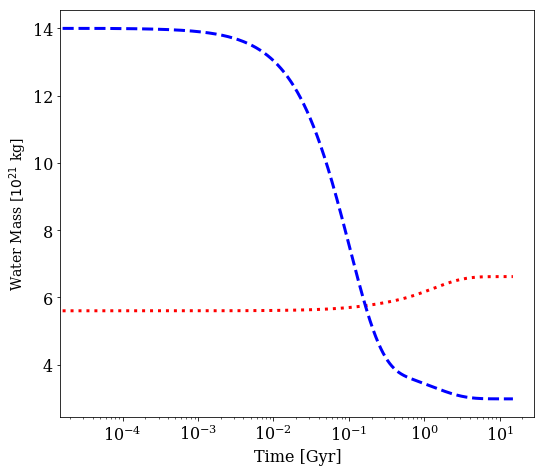

In [175]:
# Check the time-dependent cycling of the above models to see if they become desiccated in the middle.
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

idx = 7

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

# XXXX THESE TIME ARRAYS ARE WRONG(ISH). NEED TO ACTUALLY USE TAU IF INCLUDING IN PAPER. XXXX
plt.semilogx(t_array*28700./1e9, (x_path_CA[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':')#, label='Mantle')
plt.semilogx(t_array*28700./1e9, (s_path_CA[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--')#, label='Surface')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=14)

Text(0, 0.5, 'Water Mass [$10^{21}$ kg]')

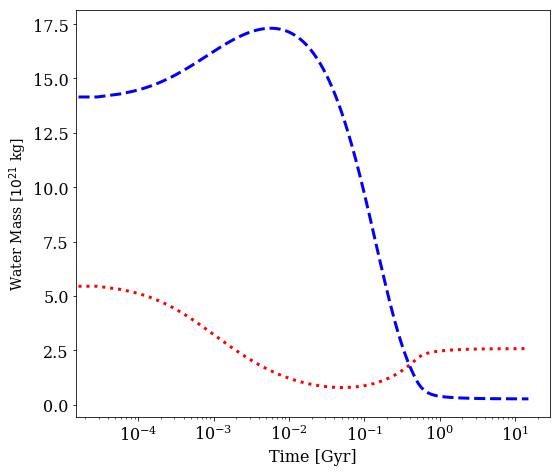

In [176]:
# Check the time-dependent cycling of the above models to see if they become desiccated in the middle.
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

idx = 7

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

# XXXX THESE TIME ARRAYS ARE WRONG(ISH). NEED TO ACTUALLY USE TAU IF INCLUDING IN PAPER. XXXX
plt.semilogx(t_array*28700./1e9, (x_path_SS[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':')#, label='Mantle')
plt.semilogx(t_array*28700./1e9, (s_path_SS[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--')#, label='Surface')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=14)

Text(0, 0.5, 'Water Mass [$10^{21}$ kg]')

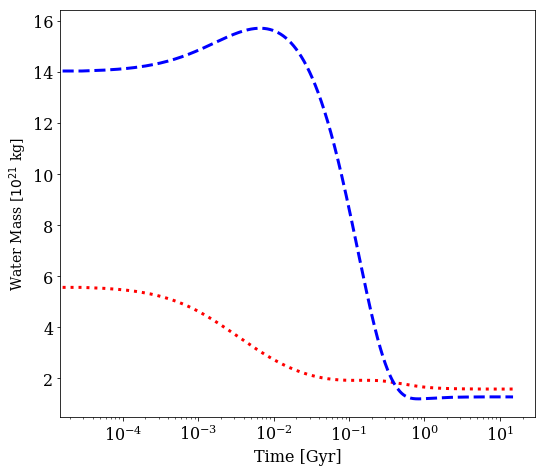

In [177]:
# Check the time-dependent cycling of the above models to see if they become desiccated in the middle.
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
fig = plt.figure(figsize=(8.5,7.5))
plt.tight_layout()

idx = 7

kg_conv = 2.3e-4*1.3*M_E #[kg] # THIS IS CORRECT, FOR BOTH X AND S!!!

# XXXX THESE TIME ARRAYS ARE WRONG(ISH). NEED TO ACTUALLY USE TAU IF INCLUDING IN PAPER. XXXX
plt.semilogx(t_array*28700./1e9, (x_path_hyb[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='r', linestyle=':')#, label='Mantle')
plt.semilogx(t_array*28700./1e9, (s_path_hyb[idx,:]*kg_conv/1000./1.0e18), linewidth=3, color='b', linestyle='--')#, label='Surface')

plt.xlabel('Time [Gyr]', fontsize=16)
plt.ylabel(r'Water Mass [$10^{21}$ kg]', fontsize=14)

In [178]:
idx = 7
print(s_path_CA[idx,-1]*kg_conv/1.4e21)
print(s_path_SS[idx,-1]*kg_conv/1.4e21)
print(s_path_hyb[idx,-1]*kg_conv/1.4e21)

2.1304314762869656
0.19101533648366786
0.9053281539600584
